In [7]:
%matplotlib inline

In [2]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
import pickle
import matplotlib.gridspec as gridspec

import os
import pdb
from loren_frank_data_processing import (make_epochs_dataframe,
                                         make_neuron_dataframe)
from src.parameters import (ANIMALS, MIN_N_NEURONS, _BRAIN_AREAS)

from src.load_data import load_data

from scripts.run_by_epoch import clusterless_thetasweeps
from tqdm.auto import tqdm

from scipy.stats import spearmanr, pearsonr
from scipy.signal import hilbert

from ZilongCode.utils import bandpassfilter

### get spikes

In [3]:
DATA_DIR = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/"

epoch_key = ('bon', 8, 4)
animal, day, epoch = epoch_key

#load lfp
lfp_filename = os.path.join(
    DATA_DIR,
    'ThetaSweepTrajectories',
    f'{animal}_{day:02d}_{epoch:02d}_lfp_info.pkl')
with open(lfp_filename, 'rb') as f:
    lfp_info = pickle.load(f)

#load multiunit firing rate
multiunit_fr_filename = os.path.join(
    DATA_DIR,
    'ThetaSweepTrajectories',
    f'{animal}_{day:02d}_{epoch:02d}_spike_info.pkl')
with open(multiunit_fr_filename, 'rb') as f:
    [spike, multiunit, multiunit_fr] = pickle.load(f)


multiunit_spikes = (np.any(~np.isnan(multiunit.values), axis=1)
                    ).astype(np.float)

### get the phase of each spike

In [4]:
def get_phase(filtered_lfp):
    
    filtered_lfp = filtered_lfp.values.squeeze()
    analytic_signal = hilbert(filtered_lfp)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    # wrap the instantaneous_phase to -pi and pi
    instantaneous_phase = np.mod(instantaneous_phase + np.pi, 2 * np.pi) - np.pi
    
    return instantaneous_phase

def get_phase_from_all_channels(epoch_key, DATA_DIR, lowcut=25, highcut=50):
    
    animal, day, epoch = epoch_key
    #load lfp
    lfp_filename = os.path.join(
        DATA_DIR,
        'ThetaSweepTrajectories',
        f'{animal}_{day:02d}_{epoch:02d}_lfp_info.pkl')
    with open(lfp_filename, 'rb') as f:
        lfp_info = pickle.load(f)
    
    phase = pd.DataFrame(index=lfp_info.index)
    for i in range(len(lfp_info.columns)):
        lfp = bandpassfilter(lfp_info.iloc[:, i], lowcut=lowcut, highcut=highcut, fs=500)
        lfp = pd.DataFrame(lfp, index=lfp_info.index)
        #store them with the same column name as the lfp_info
        phase[lfp_info.columns[i]] = get_phase(lfp)
    return phase

epoch_key = ('bon', 8, 4)
DATA_DIR = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/"

phase = get_phase_from_all_channels(epoch_key, DATA_DIR, lowcut=25, highcut=50)

#if phase.index is shorter than spike.index, then pad 0 to the missing rows
#else if phase.index is longer than spike.index, then drop the extra rows
phase = phase.reindex(spike.index, fill_value=0)


Text(0.5, 1.0, 'Spike phase histogram')

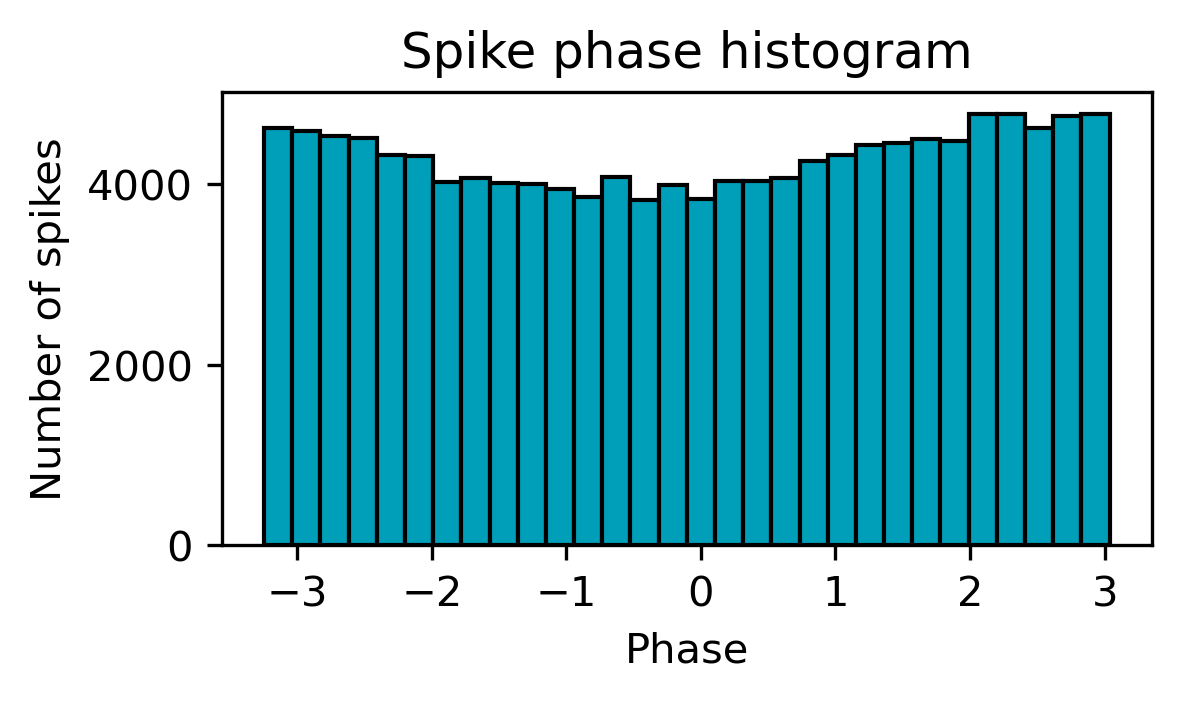

In [7]:
#calculate the number of spikes in each phase bin using the multiunit spikes and phase, which have the same dimension
phase_bins = np.linspace(-np.pi, np.pi, 31)
spike_phase = np.zeros(len(phase_bins)-1)
for i in range(len(phase_bins)-1):
    spike_phase[i] = np.sum(multiunit_spikes[(phase>=phase_bins[i]) & (phase<phase_bins[i+1])])
    
#plot the spike_phase histogram
plt.figure(figsize=(4, 2), dpi=300)
#do bar plot with facecolor #009FB9, edge color black
plt.bar(phase_bins[:-1], spike_phase, width=phase_bins[1]-phase_bins[0], facecolor='#009FB9', edgecolor='black')
plt.xlabel('Phase')
plt.ylabel('Number of spikes')
plt.title('Spike phase histogram')

### get replay trajectories and ripple times

In [183]:
epoch_key = ('gov', 9, 5)
animal, day, epoch = epoch_key

datafolder = (
    "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ReplayTrajectories"
)

#load lfp
lfp_filename = os.path.join(
    DATA_DIR,
    'ThetaSweepTrajectories',
    f'{animal}_{day:02d}_{epoch:02d}_lfp_info.pkl')
with open(lfp_filename, 'rb') as f:
    lfp_info = pickle.load(f)

#load multiunit firing rate
multiunit_fr_filename = os.path.join(
    DATA_DIR,
    'ThetaSweepTrajectories',
    f'{animal}_{day:02d}_{epoch:02d}_spike_info.pkl')
with open(multiunit_fr_filename, 'rb') as f:
    [spike, multiunit, multiunit_fr] = pickle.load(f)

phase = get_phase_from_all_channels(epoch_key, DATA_DIR, lowcut=25, highcut=50)

#if phase.index is shorter than spike.index, then pad 0 to the missing rows
#else if phase.index is longer than spike.index, then drop the extra rows
phase = phase.reindex(spike.index, fill_value=0)

multiunit_spikes = (np.any(~np.isnan(multiunit.values), axis=1)
                    ).astype(np.float)

#read the csv file and extract the first three columns
replay_info_path = os.path.join(
    datafolder,
    f"{animal}_{day:02d}_{epoch:02d}_clusterless_1D_no_interneuron_replay_info_80.csv",
)

replay_info = pd.read_csv(replay_info_path, usecols=[0, 1, 2])

with open(os.path.join(DATA_DIR, 'ReplayTrajectories', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
    Replay_traj = pickle.load(f)


#for each replay trajectory in Replay_traj, calculate te step size of two successive points
#and get the multiunit spikes in the corresponding time bin

step_size = []
multiunit_spikes_at_step_size = []
multiunit_fr_at_step_size = []
phase_at_step_size = []

times = spike.index
sum_multiunit_spikes = np.sum(multiunit_spikes, axis=1)
sum_spikes = np.sum(spike, axis=1)
step_interval = 5

for i in Replay_traj.keys():

    
    replay_start_time = replay_info.loc[replay_info['ripple_number'] == i, 'start_time'].values[0]
    #keep strings after 'days '
    replay_start_time = replay_start_time.split('days ')[1]
    #convert to time delta  
    replay_start_time = pd.to_timedelta(replay_start_time)
    
    # traj = Replay_traj[i]
    # numpoints = (len(traj)-1)//step_interval
    # for j in range(numpoints):
        
    #     #get the step size of two successive points
    #     step_size.append(np.abs(traj[(j+1)*step_interval] - traj[j*step_interval]))
    #     #get the time bin of the point by adding j*0.002 s to replay_start_time: 0.002 is the decoding time window
    #     timej_start = replay_start_time + pd.to_timedelta(j*step_interval*0.002, unit='s')
    #     timej_end = replay_start_time + pd.to_timedelta((j+1)*step_interval*0.002, unit='s')
    #     #get all the index from timej_start to timej_end in times
    #     index = times.get_indexer_for(times[(times>=timej_start) & (times<=timej_end)])
    #     #print(index)
    #     #get the multiunit spikes in the corresponding time bin using the index
    #     summed_spikes = np.sum(sum_multiunit_spikes[index])
        
    #     multiunit_spikes_at_step_size.append(summed_spikes)
    #     #get the multiunit firing rate in the corresponding time bin using the index
    #     multiunit_fr_at_step_size.append(np.mean(multiunit_fr.iloc[index]).values[0])
        
    #     #get the phase in the corresponding time bin using the index
    #     phase_subset = phase.iloc[index]
    #     multiunit_spikes_ind = multiunit_spikes[index]
    #     #turn phase_at_step_size into a vector
    #     phase_subset_vec = phase_subset.values.reshape(-1)
    #     #turn multiunit_spikes_ind into a vector
    #     multiunit_spikes_vec = multiunit_spikes_ind.reshape(-1)
    #     phase_subset_vec = np.array(phase_subset_vec)
    #     multiunit_spikes_vec = np.array(multiunit_spikes_vec)
    #     #select the phase only when multiunit_spikes_vec is 1 ()only whne there is spike event)
    #     phase_selected = phase_subset_vec[multiunit_spikes_vec==1]
    #     #calculate the circular mean of phase_selected which is a vector
    #     mean_phase = np.angle(np.mean(np.exp(1j*phase_selected)))
    #     #get the average phase when multiunit_spikes_vec is 1
    #     phase_at_step_size.append(mean_phase)        
    
    # replay_end_time = replay_info.loc[replay_info['ripple_number'] == i, 'end_time'].values[0]
    # #print timej_end, replay_end_time, and the difference between them
    # #print(timej_end, replay_end_time, replay_end_time-timej_end)
    
    
    traj = Replay_traj[i]
    
    stepsize=3
    unitlength = 10
    
    #each bin is unitlength, next bin is advanced by stepsize
    for j in range(0, len(traj)-unitlength-stepsize, stepsize):    
        ave_traj_in_previous_bin = np.mean(traj[j:j+unitlength])
        ave_traj_in_next_bin = np.mean(traj[j+stepsize:j+stepsize+unitlength])
        step_size.append(np.abs(ave_traj_in_next_bin - ave_traj_in_previous_bin))
        
        #get the time bin of the point by adding j*0.002 s to replay_start_time: 0.002 is the decoding time window
        timej_start = replay_start_time + pd.to_timedelta(j*0.002, unit='s')
        timej_end = replay_start_time + pd.to_timedelta((j+stepsize+unitlength)*0.002, unit='s')
        
        #get all the index from timej_start to timej_end in times
        index = times.get_indexer_for(times[(times>=timej_start) & (times<=timej_end)])
        #print(index)
        #get the multiunit spikes in the corresponding time bin using the index
        summed_spikes = np.sum(sum_multiunit_spikes[index])
        
        multiunit_spikes_at_step_size.append(summed_spikes)
        #get the multiunit firing rate in the corresponding time bin using the index
        multiunit_fr_at_step_size.append(np.mean(multiunit_fr.iloc[index]).values[0])
        
        #get the phase in the corresponding time bin using the index
        phase_subset = phase.iloc[index]
        multiunit_spikes_ind = multiunit_spikes[index]
        #turn phase_at_step_size into a vector
        phase_subset_vec = phase_subset.values.reshape(-1)
        #turn multiunit_spikes_ind into a vector
        multiunit_spikes_vec = multiunit_spikes_ind.reshape(-1)
        phase_subset_vec = np.array(phase_subset_vec)
        multiunit_spikes_vec = np.array(multiunit_spikes_vec)
        #select the phase only when multiunit_spikes_vec is 1 ()only whne there is spike event)
        phase_selected = phase_subset_vec[multiunit_spikes_vec==1]
        #calculate the circular mean of phase_selected which is a vector
        mean_phase = np.angle(np.mean(np.exp(1j*phase_selected)))
        #get the average phase when multiunit_spikes_vec is 1
        phase_at_step_size.append(mean_phase)        
    
    replay_end_time = replay_info.loc[replay_info['ripple_number'] == i, 'end_time'].values[0]
    #print timej_end, replay_end_time, and the difference between them
    print(timej_end, replay_end_time, replay_end_time-timej_end)
    
    


0 days 03:11:06.063467 0 days 03:11:06.069467247 0 days 00:00:00.006000
0 days 03:11:07.100800 0 days 03:11:07.105467284 0 days 00:00:00.004666
0 days 03:11:07.374133 0 days 03:11:07.376800627 0 days 00:00:00.002666
0 days 03:11:09.760800 0 days 03:11:09.766134047 0 days 00:00:00.005333
0 days 03:11:41.892801 0 days 03:11:41.899468541 0 days 00:00:00.006666
0 days 03:12:07.509469 0 days 03:12:07.512802799 0 days 00:00:00.003333
0 days 03:12:08.646802 0 days 03:12:08.649469507 0 days 00:00:00.002666
0 days 03:12:10.264802 0 days 03:12:10.266802898 0 days 00:00:00.002000
0 days 03:12:20.204803 0 days 03:12:20.211469924 0 days 00:00:00.006666
0 days 03:12:21.187469 0 days 03:12:21.192803293 0 days 00:00:00.005333
0 days 03:12:35.582137 0 days 03:12:35.585470479 0 days 00:00:00.003333
0 days 03:12:35.825470 0 days 03:12:35.828803822 0 days 00:00:00.003333
0 days 03:12:36.694803 0 days 03:12:36.702137186 0 days 00:00:00.007333
0 days 03:12:59.728804 0 days 03:12:59.730804685 0 days 00:00:00

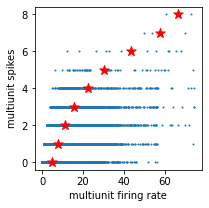

In [28]:
#plot spikes vs multiunit spikes in scatter plot
plt.figure(figsize=(3,3))
plt.scatter(multiunit_fr, sum_multiunit_spikes, s=1)
#for each value of sum_multiunit_spikes, find the median of multiunit_fr and plot as a star in the plot
for i in np.unique(sum_multiunit_spikes):
    plt.scatter(np.mean(multiunit_fr[sum_multiunit_spikes==i]), i, marker='*', s=100, c='r')
plt.xlabel('multiunit firing rate')
plt.ylabel('multiunit spikes')
plt.show()

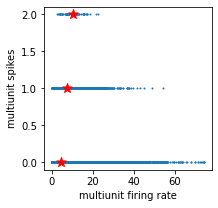

In [30]:
#plot spikes vs multiunit spikes in scatter plot
plt.figure(figsize=(3,3))
plt.scatter(multiunit_fr, sum_spikes, s=1)
#for each value of sum_multiunit_spikes, find the median of multiunit_fr and plot as a star in the plot
for i in np.unique(sum_spikes):
    plt.scatter(np.median(multiunit_fr[sum_multiunit_spikes==i]), i, marker='*', s=100, c='r')
plt.xlabel('multiunit firing rate')
plt.ylabel('multiunit spikes')
plt.show()

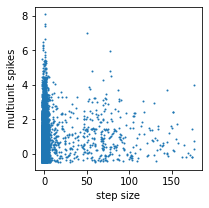

In [103]:
#plot step_size vs multiunit_spikes_at_step_size as scatter plot, #jitter step_size +-0.5 for visualization
plt.figure(figsize=(3, 3))
plt.scatter(np.array(step_size)+np.random.uniform(-2.5, 2.5, len(step_size)), multiunit_spikes_at_step_size+np.random.uniform(-0.5, 0.5, len(multiunit_spikes_at_step_size)), s=1)
plt.xlabel('step size')
plt.ylabel('multiunit spikes')
plt.show()

### get the stepsize, multiunit spikes, and phase information for each replay trajectory for all animals

In [4]:

def get_stepsize_multiunitspikes_phase(epoch_key, DATA_DIR, 
                                       unitlength=10, step_interval=3,
                                       distance_threshold=40, traj_length_threshold=0, 
                                       lowcut=25, highcut=50):
    animal, day, epoch = epoch_key
        
    #get multiunit spikes under folder: ThetaSweepTrajectories
    #load multiunit firing rate
    multiunit_fr_filename = os.path.join(
        DATA_DIR,
        'ThetaSweepTrajectories',
        f'{animal}_{day:02d}_{epoch:02d}_spike_info.pkl')
    with open(multiunit_fr_filename, 'rb') as f:
        [spike, multiunit, multiunit_fr] = pickle.load(f)
    
    multiunit_spikes = (np.any(~np.isnan(multiunit.values), axis=1)
                        ).astype(np.float)
    
    #get phase foor all lfp channels
    phase = get_phase_from_all_channels(epoch_key, DATA_DIR, lowcut=lowcut, highcut=highcut)
    phase = phase.reindex(spike.index, fill_value=0)
    
    #get ripple time from csv file under folder: ReplayTrajectories
    replay_info_path = os.path.join(
        DATA_DIR,
        'ReplayTrajectories/'
        f"{animal}_{day:02d}_{epoch:02d}_clusterless_1D_no_interneuron_replay_info_80.csv",
    )
    
    #read the csv file and extract the first three columns
    replay_info = pd.read_csv(replay_info_path, usecols=[0, 1, 2])

    #get the replay trajectory from pkl file under folder: ReplayTrajectories
    with open(os.path.join(DATA_DIR, 'ReplayTrajectories', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)

    #for each replay trajectory in Replay_traj, calculate te step size of two successive points
    #and get the multiunit spikes in the corresponding time bin
    step_size = []
    multiunit_spikes_at_step_size = []
    multiunit_fr_at_step_size = []
    phase_at_step_size = []
    times = spike.index
    sum_multiunit_spikes = np.sum(multiunit_spikes, axis=1)

    for i in Replay_traj.keys():
        #get the start time of the replay trajectory
        replay_start_time = replay_info.loc[replay_info['ripple_number'] == i, 'start_time'].values[0]
        #keep strings after 'days '
        replay_start_time = replay_start_time.split('days ')[1]
        #convert to time delta  
        replay_start_time = pd.to_timedelta(replay_start_time)
     
        traj = Replay_traj[i]
        
        #if event is less than 10 steos or the start-to-end distacne is less than 80 cm, then skip
        if len(traj) < traj_length_threshold:
            continue
        #filterout the replay trajectory with start-to-end distance that is less than 40 cm
        if np.abs(traj[-1]-traj[0]) < distance_threshold:
            continue
        
        
        # traj = Replay_traj[i]
        # numpoints = (len(traj)-1)//step_interval
        # for j in range(numpoints):
        #     #get the step size of two successive points
        #     step_size.append(np.abs(traj[(j+1)*step_interval] - traj[j*step_interval]))
        #     #get the time bin of the point by adding j*0.002 s to replay_start_time: 0.002 is the decoding time window
        #     timej_start = replay_start_time + pd.to_timedelta(j*step_interval*0.002, unit='s')
        #     timej_end = replay_start_time + pd.to_timedelta((j+1)*step_interval*0.002, unit='s')
        
    
        #each bin is unitlength, next bin is advanced by stepsize
        for j in range(0, len(traj)-unitlength-step_interval, step_interval):    
            ave_traj_in_previous_bin = np.mean(traj[j:j+unitlength])
            ave_traj_in_next_bin = np.mean(traj[j+step_interval:j+step_interval+unitlength])
            step_size.append(np.abs(ave_traj_in_next_bin - ave_traj_in_previous_bin))
            
            #get the time bin of the point by adding j*0.002 s to replay_start_time: 0.002 is the decoding time window
            timej_start = replay_start_time + pd.to_timedelta(j*0.002, unit='s')
            timej_end = replay_start_time + pd.to_timedelta((j+step_interval+unitlength)*0.002, unit='s')   
                 
            #get all the index from timej_start to timej_end in times
            index = times.get_indexer_for(times[(times>=timej_start) & (times<=timej_end)])
            #print(index)
            #get the multiunit spikes in the corresponding time bin using the index
            summed_spikes = np.sum(sum_multiunit_spikes[index])
            
            multiunit_spikes_at_step_size.append(summed_spikes)
            #get the multiunit firing rate in the corresponding time bin using the index
            multiunit_fr_at_step_size.append(np.mean(multiunit_fr.iloc[index]).values[0])
            
            #get the phase in the corresponding time bin using the index
            phase_subset = phase.iloc[index]
            multiunit_spikes_ind = multiunit_spikes[index]
            #turn phase_at_step_size into a vector
            phase_subset_vec = phase_subset.values.reshape(-1)
            #turn multiunit_spikes_ind into a vector
            multiunit_spikes_vec = multiunit_spikes_ind.reshape(-1)
            phase_subset_vec = np.array(phase_subset_vec)
            multiunit_spikes_vec = np.array(multiunit_spikes_vec)
            #select the phase only when multiunit_spikes_vec is 1 ()only whne there is spike event)
            phase_selected = phase_subset_vec[multiunit_spikes_vec==1]
            #calculate the circular mean of phase_selected which is a vector
            mean_phase = np.angle(np.mean(np.exp(1j*phase_selected)))
            #get the average phase when multiunit_spikes_vec is 1
            phase_at_step_size.append(mean_phase)
        
        replay_end_time = replay_info.loc[replay_info['ripple_number'] == i, 'end_time'].values[0]
        #print timej_end, replay_end_time, and the difference between them
        #print(timej_end, replay_end_time, replay_end_time-timej_end)
            
    return [np.array(step_size), np.array(multiunit_spikes_at_step_size), np.array(multiunit_fr_at_step_size), np.array(phase_at_step_size)]

0 days 03:23:58.763104 0 days 03:23:58.765104369 0 days 00:00:00.002000
0 days 03:24:00.087104 0 days 03:24:00.090437751 0 days 00:00:00.003333
0 days 03:24:25.511105 0 days 03:24:25.514438687 0 days 00:00:00.003333
0 days 03:24:46.242439 0 days 03:24:46.243106116 0 days 00:00:00.000666
0 days 03:26:55.621777 0 days 03:26:55.624444210 0 days 00:00:00.002666
0 days 03:27:43.735112 0 days 03:27:43.738445980 0 days 00:00:00.003333
0 days 03:28:23.241780 0 days 03:28:23.243114100 0 days 00:00:00.001333
0 days 03:28:48.898448 0 days 03:28:48.899781711 0 days 00:00:00.001333
0 days 03:29:18.963116 0 days 03:29:18.966449484 0 days 00:00:00.003333
0 days 03:30:32.925785 0 days 03:30:32.928452205 0 days 00:00:00.002666
0 days 03:30:49.429119 0 days 03:30:49.432452812 0 days 00:00:00.003333
0 days 03:30:52.009786 0 days 03:30:52.012452907 0 days 00:00:00.002666
0 days 03:31:21.501787 0 days 03:31:21.504453992 0 days 00:00:00.002666
0 days 03:31:21.661787 0 days 03:31:21.664453998 0 days 00:00:00

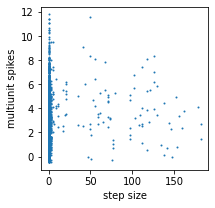

Text(0, 0.5, 'Step size (cm)')

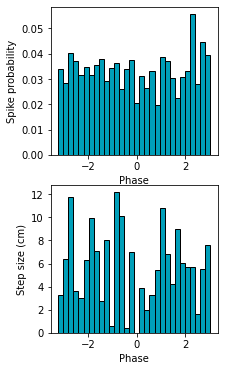

In [224]:
epoch_key = ('gov', 8, 6)
DATA_DIR = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/"

results = get_stepsize_multiunitspikes_phase(epoch_key, DATA_DIR, 
                                             unitlength=1, step_interval=1,
                                             distance_threshold=40, traj_length_threshold=0, 
                                             lowcut=25, highcut=50)

step_size, multiunit_spikes_at_step_size, multiunit_fr_at_step_size, phase_at_step_size = results

#plot step_size vs multiunit_spikes_at_step_size as scatter plot, #jitter step_size +-0.5 for visualization
plt.figure(figsize=(3, 3))
plt.scatter(np.array(step_size), multiunit_spikes_at_step_size+np.random.uniform(-0.5, 0.5, len(multiunit_spikes_at_step_size)), s=1)
plt.xlabel('step size')
plt.ylabel('multiunit spikes')
plt.show()

#plot the spike histogram in each phase bin
phase_bins = np.linspace(-np.pi, np.pi, 31)
spike_phase = np.zeros(len(phase_bins)-1)
step_phase = np.zeros(len(phase_bins)-1)
for i in range(len(phase_bins)-1):
    summed_spike_i = np.sum(multiunit_spikes_at_step_size[(phase_at_step_size>=phase_bins[i]) & (phase_at_step_size<phase_bins[i+1])])
    spike_phase[i] = summed_spike_i/np.sum(multiunit_spikes_at_step_size)
    
    mean_step_i = np.mean(step_size[(phase_at_step_size>=phase_bins[i]) & (phase_at_step_size<phase_bins[i+1])])
    step_phase[i] = mean_step_i
    
#plot the spike_phase histogram
plt.figure(figsize=(3, 6))
plt.subplot(2, 1, 1)
#do bar plot with facecolor #009FB9, edge color black
plt.bar(phase_bins[:-1], spike_phase, width=phase_bins[1]-phase_bins[0], facecolor='#009FB9', edgecolor='black')
plt.xlabel('Phase')
plt.ylabel('Spike probability')

plt.subplot(2, 1, 2)
#do bar plot with facecolor #009FB9, edge color black
plt.bar(phase_bins[:-1], step_phase, width=phase_bins[1]-phase_bins[0], facecolor='#009FB9', edgecolor='black')
plt.xlabel('Phase')
plt.ylabel('Step size (cm)')



In [5]:
epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)

neuron_info = neuron_info.loc[
(neuron_info.type == 'principal') &
(neuron_info.numspikes > 100) &
neuron_info.area.isin(_BRAIN_AREAS)]

n_neurons = (neuron_info
                .groupby(['animal', 'day', 'epoch'])
                .neuron_id
                .agg(len)
                .rename('n_neurons')
                .to_frame())

epoch_info = epoch_info.join(n_neurons)
is_w_track = (epoch_info.environment
                .isin(['TrackA', 'TrackB', 'WTrackA', 'WTrackB']))
is_animal = epoch_info.index.isin(['bon', 'fra', 'gov', 'dud', 'con', 'Cor', 'dav', 'egy', 'cha'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                is_animal
                )

#%%
DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'
#initialize the dictionary to store the step size, multiunit spikes and multiunit firing rate for each epoch
all_step_size = {}
all_multiunit_spikes_at_step_size = {}
all_multiunit_fr_at_step_size = {}
all_phase_at_step_size = {}

unitlength=1; step_interval=1; lowcut=25; highcut=50; distance_threshold=40

#check if the pickle file already exists
#if yes, then load the pickle file
#if no, then calculate the step size, multiunit spikes and multiunit firing rate for each epoch
savefolder = os.path.join(DATA_DIR, 'anti_phase_corrrelation_results')
filename = os.path.join(savefolder, f'anti_phase_corrrelation_results_unitlength{unitlength}_step_interval{step_interval}_lowcut{lowcut}_highcut{highcut}_distance_threshold{distance_threshold}.pkl')

if os.path.exists(filename):
    with open(filename, 'rb') as f:
        [all_step_size, all_multiunit_spikes_at_step_size, all_multiunit_fr_at_step_size, all_phase_at_step_size] = pickle.load(f)

else:
    for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
        animal, day, epoch = epoch_key
        
        #print(epoch_key)
        
    # step_size, multiunit_spikes_at_step_size, multiunit_fr_at_step_size, phase_at_step_size = get_stepsize_multiunitspikes_phase(epoch_key, DATA_DIR, step_interval=10)

        results = get_stepsize_multiunitspikes_phase(epoch_key, DATA_DIR, 
                                                    unitlength=unitlength, step_interval=step_interval,
                                                    distance_threshold=40, traj_length_threshold=0, 
                                                    lowcut=lowcut, highcut=highcut)

        step_size, multiunit_spikes_at_step_size, multiunit_fr_at_step_size, phase_at_step_size = results

        #save the step size, multiunit spikes and multiunit firing rate for each epoch
        all_step_size[epoch_key] = step_size
        all_multiunit_spikes_at_step_size[epoch_key] = multiunit_spikes_at_step_size
        all_multiunit_fr_at_step_size[epoch_key] = multiunit_fr_at_step_size
        all_phase_at_step_size[epoch_key] = phase_at_step_size

    #save all_step_size, all_multiunit_spikes_at_step_size, all_multiunit_fr_at_step_size, all_phase_at_step_size
    #into a pickle file to be used in other scripts
    savefolder = os.path.join(DATA_DIR, 'anti_phase_corrrelation_results')

    #set filename including unitlength step_interval lowcut highcut
    filename = os.path.join(savefolder, f'anti_phase_corrrelation_results_unitlength{unitlength}_step_interval{step_interval}_lowcut{lowcut}_highcut{highcut}_distance_threshold{distance_threshold}.pkl')

    with open(filename, 'wb') as f:
        pickle.dump([all_step_size, all_multiunit_spikes_at_step_size, all_multiunit_fr_at_step_size, all_phase_at_step_size], f)


### check the anti-phase correlation between step size and spikes at gamma phase: merge cross all animals

epochs: 100%|██████████| 140/140 [00:00<00:00, 6416.88it/s]


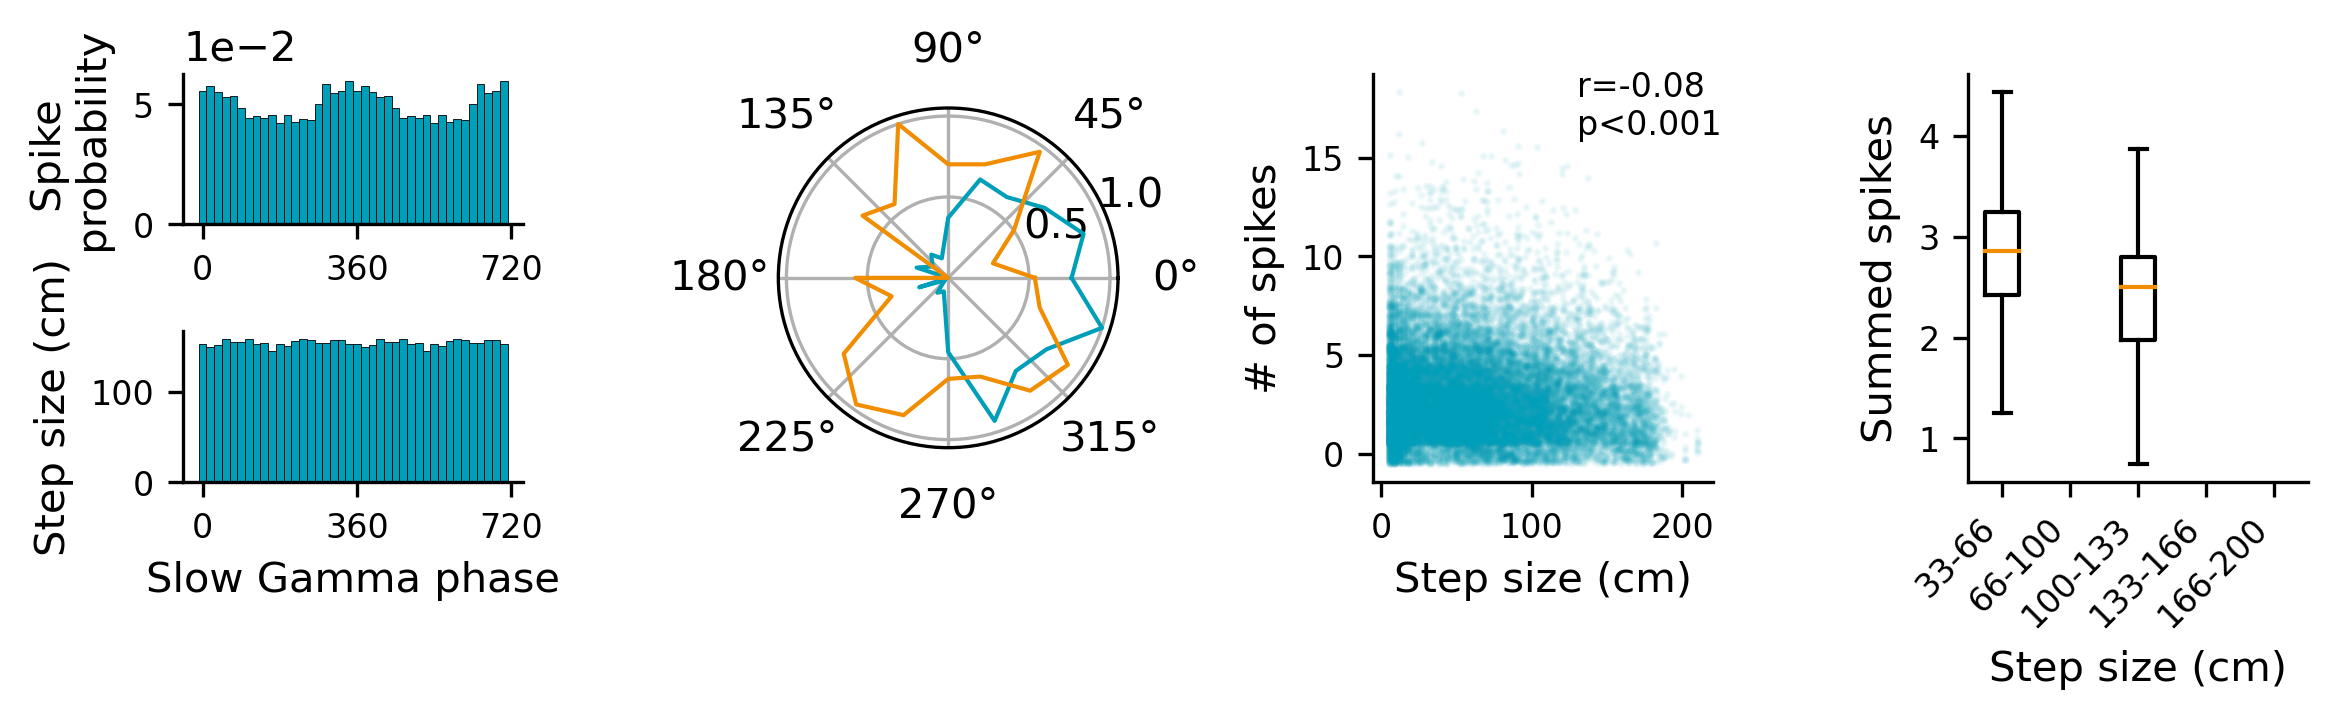

In [11]:
#merge values in all_step_size and all_multiunit_spikes_at_step_size into a list and plot step_size vs multiunit_spikes_at_step_size as scatter plot
all_step_size_list = []
all_multiunit_spikes_at_step_size_list = []
all_phase_at_step_size_list = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    all_step_size_list.extend(all_step_size[epoch_key])
    all_multiunit_spikes_at_step_size_list.extend(all_multiunit_spikes_at_step_size[epoch_key])
    all_phase_at_step_size_list.extend(all_phase_at_step_size[epoch_key])

#remove points with all_step_size_list<1 for better visualization
all_step_size_list = np.array(all_step_size_list)
all_multiunit_spikes_at_step_size_list = np.array(all_multiunit_spikes_at_step_size_list)
all_phase_at_step_size_list = np.array(all_phase_at_step_size_list)

thres = 5
all_step_size_array= all_step_size_list[all_step_size_list>thres]
all_multiunit_spikes_at_step_size_array = all_multiunit_spikes_at_step_size_list[all_step_size_list>thres]
all_phase_at_step_size_array = all_phase_at_step_size_list[all_step_size_list>thres]

fig = plt.figure(figsize=(8, 2.5), dpi=300)
gs = gridspec.GridSpec(2, 4)

labelsize = 10
ticksize = 8

#plot all_multiunit_spikes_at_step_size_array at each phase bin
phase_bins = np.linspace(-np.pi, np.pi, 21)
spike_phase = np.zeros(len(phase_bins)-1)
step_phase = np.zeros(len(phase_bins)-1)
for i in range(len(phase_bins)-1):
    summed_spike_i = np.sum(all_multiunit_spikes_at_step_size_array[(all_phase_at_step_size_array>=phase_bins[i]) & (all_phase_at_step_size_array<phase_bins[i+1])])
    spike_phase[i] = summed_spike_i/np.sum(all_multiunit_spikes_at_step_size_array)
    
    step_i = all_step_size_array[(all_phase_at_step_size_array>=phase_bins[i]) & (all_phase_at_step_size_array<phase_bins[i+1])]
    
    #get the mean value of top 10% step size
    step_i = np.sort(step_i)
    step_i = step_i[-int(len(step_i)*0.1):]
    mean_step_i = np.mean(step_i)
    #mean_step_i = np.mean(all_step_size_array[(all_phase_at_step_size_array>=phase_bins[i]) & (all_phase_at_step_size_array<phase_bins[i+1])])
    step_phase[i] = mean_step_i
    
#scatter plot
ax1 = plt.subplot(gs[0,0])
#do bar plot with facecolor #009FB9, edge color black. repeat two cycles to make the bar plot continuous. set edgelinewidth=0.5
ax1.bar(phase_bins[:-1]+np.pi, spike_phase, width=phase_bins[1]-phase_bins[0], facecolor='#009FB9', edgecolor='black', linewidth=0.2)
ax1.bar(phase_bins[:-1]+3*np.pi, spike_phase, width=phase_bins[1]-phase_bins[0], facecolor='#009FB9', edgecolor='black', linewidth=0.2)

#set x tciks from [0, 2*pi, 4*pi] to [0, 360, 720] degree
ax1.set_xticks([0, 2*np.pi, 4*np.pi])
ax1.set_xticklabels(['0', '360', '720'], fontsize=ticksize)



ax1.set_ylabel('Spike \n probability', fontsize=labelsize)
#y ticks in scientific notation
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

############################################################################################################

ax2 = plt.subplot(gs[1,0])
#plot all_step_size_array at each phase bin
#do bar plot with facecolor #009FB9, edge color black
ax2.bar(phase_bins[:-1]+np.pi, step_phase, width=phase_bins[1]-phase_bins[0], facecolor='#009FB9', edgecolor='black', linewidth=0.2)
ax2.bar(phase_bins[:-1]+3*np.pi, step_phase, width=phase_bins[1]-phase_bins[0], facecolor='#009FB9', edgecolor='black', linewidth=0.2)

#set x tciks from [0, 2*pi, 4*pi] to [0, 360, 720] degree
ax2.set_xticks([0, 2*np.pi, 4*np.pi])
ax2.set_xticklabels(['0', '360', '720'], fontsize=ticksize)

ax2.set_xlabel('Slow Gamma phase', fontsize=labelsize)
ax2.set_ylabel('Step size (cm)', fontsize=labelsize)

############################################################################################################

#change the histogram plot into a polor plot with different colors for spike_phase and step_phase
ax3 = plt.subplot(gs[:,1], projection='polar')
#normalize spike_phase and step_phase by dividing the sum of them BEFORE plotting bu subtracting the minimum value and dividing by the range
spike_phase_norm = (spike_phase-np.min(spike_phase))/(np.max(spike_phase)-np.min(spike_phase))
step_phase_norm = (step_phase-np.min(step_phase))/(np.max(step_phase)-np.min(step_phase))

#plot spike_phase as a polar plot with the end linked to the start
ax3.plot(np.linspace(0, 2*np.pi, len(spike_phase_norm)+1), np.append(spike_phase_norm, spike_phase_norm[0]), color='#009FB9', linewidth=1)
#plot step_phase as a polar plot with the end linked to the start
ax3.plot(np.linspace(0, 2*np.pi, len(step_phase_norm)+1), np.append(step_phase_norm, step_phase_norm[0]), color='#F18D00', linewidth=1)
#add an arrow represent the circular weighted mean of spike_phase_norm
#mean_spike_phase = np.angle(np.mean(np.exp(1j*phase_at_step_size)))

############################################################################################################

#scatter plot
ax4 = plt.subplot(gs[:,2])

ax4.scatter(all_step_size_array, 
            all_multiunit_spikes_at_step_size_array+np.random.uniform(-0.5, 0.5, len(all_multiunit_spikes_at_step_size_array)),
            s=1, c='#009FB9', alpha=0.05)

#check the person correlation between step size and multiunit spikes and add p abd r values to the plot, with p values as scientific notation
from scipy.stats import pearsonr
r, p = pearsonr(all_step_size_array, all_multiunit_spikes_at_step_size_array)
if p<0.001:
    ax4.text(0.6, 0.85, f'r={r:.2f}\np<0.001', transform=plt.gca().transAxes, fontsize=ticksize)
else:
    ax4.text(0.6, 0.85, f'r={r:.2f}\np={p:.3f}', transform=plt.gca().transAxes, fontsize=ticksize)

ax4.set_xlabel('Step size (cm)', fontsize=labelsize)
ax4.set_ylabel('# of spikes', fontsize=labelsize)

############################################################################################################

#merge the step size, multiunit spikes and multiunit firing rate from epochs under each animal each day into a list
all_step_size_perday = {}
all_multiunit_spikes_at_step_size_perday = {}
all_multiunit_fr_at_step_size_perday = {}
all_phase_at_step_size_perday = {}

for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    all_step_size_perday.setdefault((animal, day), []).extend(all_step_size[epoch_key])
    all_multiunit_spikes_at_step_size_perday.setdefault((animal, day), []).extend(all_multiunit_spikes_at_step_size[epoch_key])
    all_multiunit_fr_at_step_size_perday.setdefault((animal, day), []).extend(all_multiunit_fr_at_step_size[epoch_key])
    all_phase_at_step_size_perday.setdefault((animal, day), []).extend(all_phase_at_step_size[epoch_key])

ax5 = plt.subplot(gs[:,3])

all_bined_multiunitspikeS = {}
for animal_day in all_step_size_perday.keys():
    stepsizeS = np.array(all_step_size_perday[animal_day])
    multiunitspikeS = np.array(all_multiunit_spikes_at_step_size_perday[animal_day])
    #split stepsizeS into 10 bins, in each bin, count the number of multiunit spikes
    
    bins = np.linspace(0, 200, 7)
    #get the index of the bin that each stepsizeS belongs to
    inds = np.digitize(stepsizeS, bins)
    #get the number of multiunit spikes in each bin
    multiunitspikeS_binned = [np.mean(multiunitspikeS[inds==i]) for i in range(1, len(bins))]
    
    all_bined_multiunitspikeS[animal_day] = multiunitspikeS_binned[1:]

#convert the dictionary to numpy array
all_bined_multiunitspikeS_array = np.array(list(all_bined_multiunitspikeS.values()))
    
#plot box plot with mean and std, change the color of mean to red, remove the median line
ax5.boxplot(all_bined_multiunitspikeS_array, showmeans=True, meanline=True, showfliers=False, 
            flierprops=dict(markersize=3), 
            meanprops=dict(color='#F18D00', linestyle='-', linewidth=1), 
            medianprops=dict(color='#009FB9', alpha=0))

#set the xlabels for each bin using values in bins
ax5.set_xticklabels([f'{int(bins[i])}-{int(bins[i+1])}' for i in range(1, len(bins)-1)], rotation=45, ha='right')

ax5.set_xlabel('Step size (cm)', fontsize=labelsize)
ax5.set_ylabel('Summed spikes', fontsize=labelsize)
#yticks in scientific notation
ax5.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

#for all axes, set tick size as ticksize, set x and y tick label size as labelsize
#remove top and right spines
for ax in [ax1, ax2, ax4, ax5]:
    ax.tick_params(axis='both', which='major', labelsize=ticksize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()

Text(0, 0.5, 'Summed spikes')

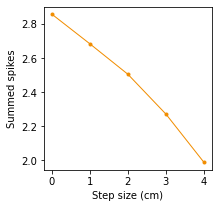

In [17]:
#plot mean value of all_bined_multiunitspikeS_array
plt.figure(figsize=(3, 3))
plt.plot(np.nanmean(all_bined_multiunitspikeS_array, axis=0), color='#F18D00', linewidth=1, linestyle='-', marker='o', markersize=3)
plt.xlabel('Step size (cm)')
plt.ylabel('Summed spikes')

### check the anti-phase correlation between step size and spikes at gamma phase: mrege across days for each animal

epochs: 100%|██████████| 140/140 [00:00<00:00, 51758.71it/s]


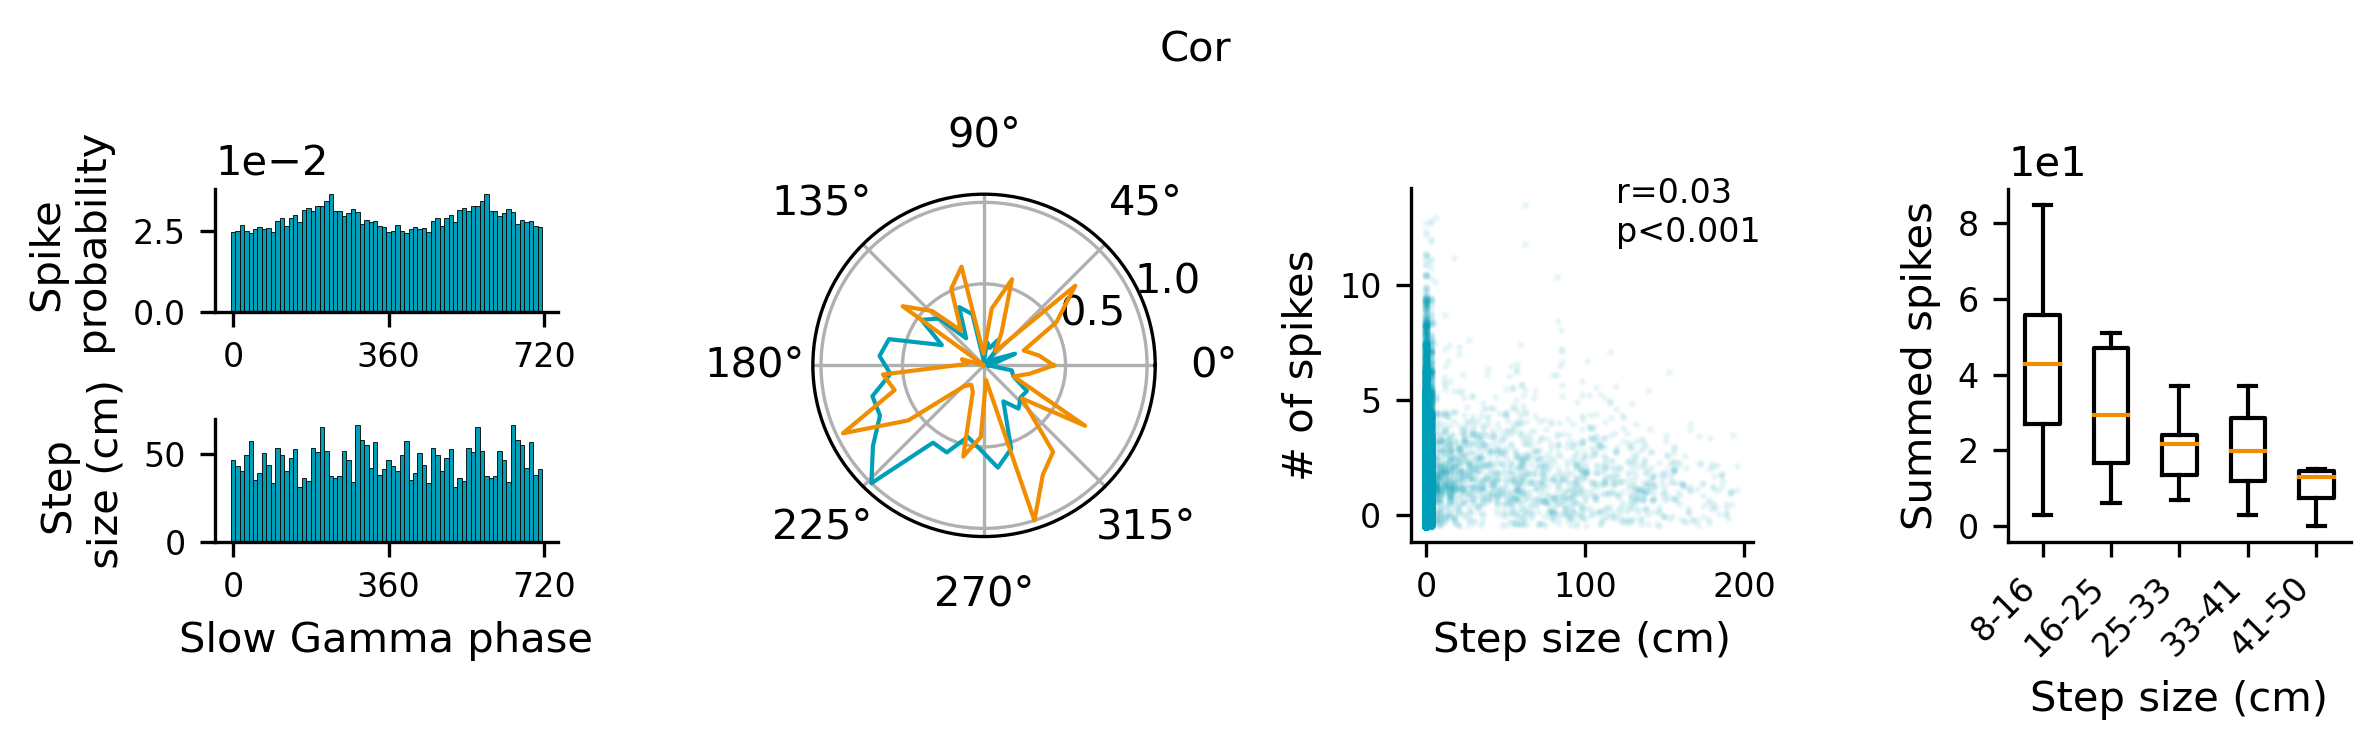

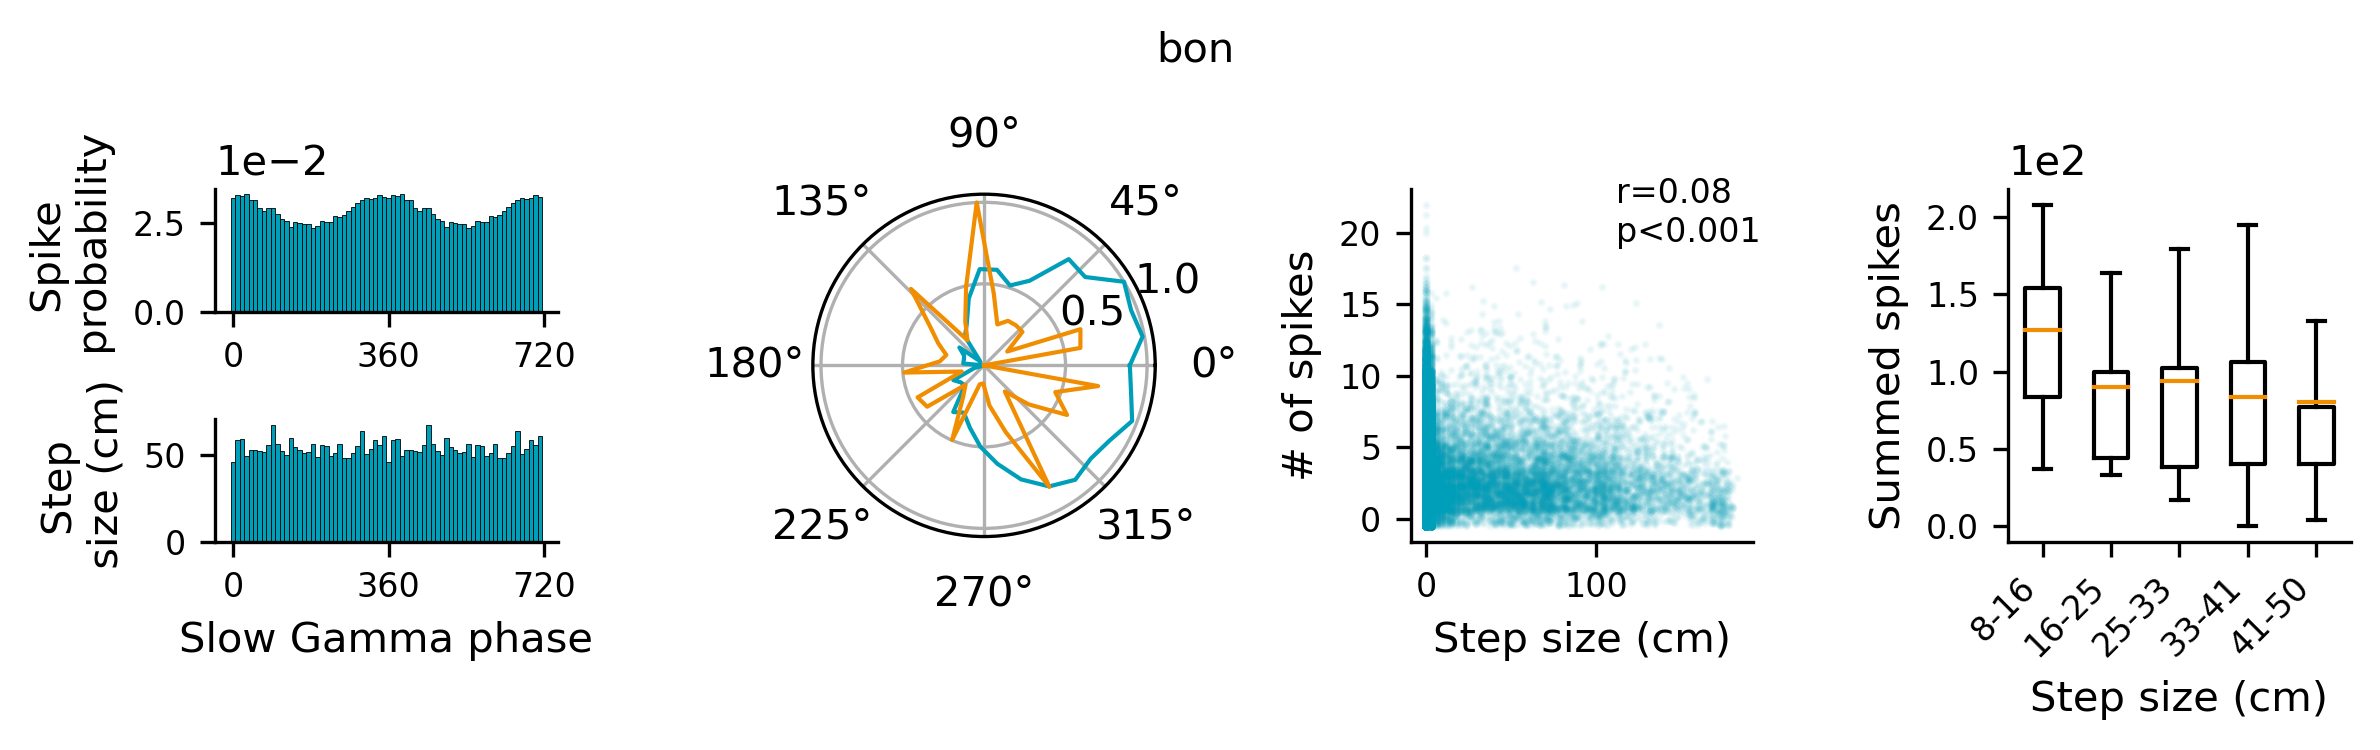

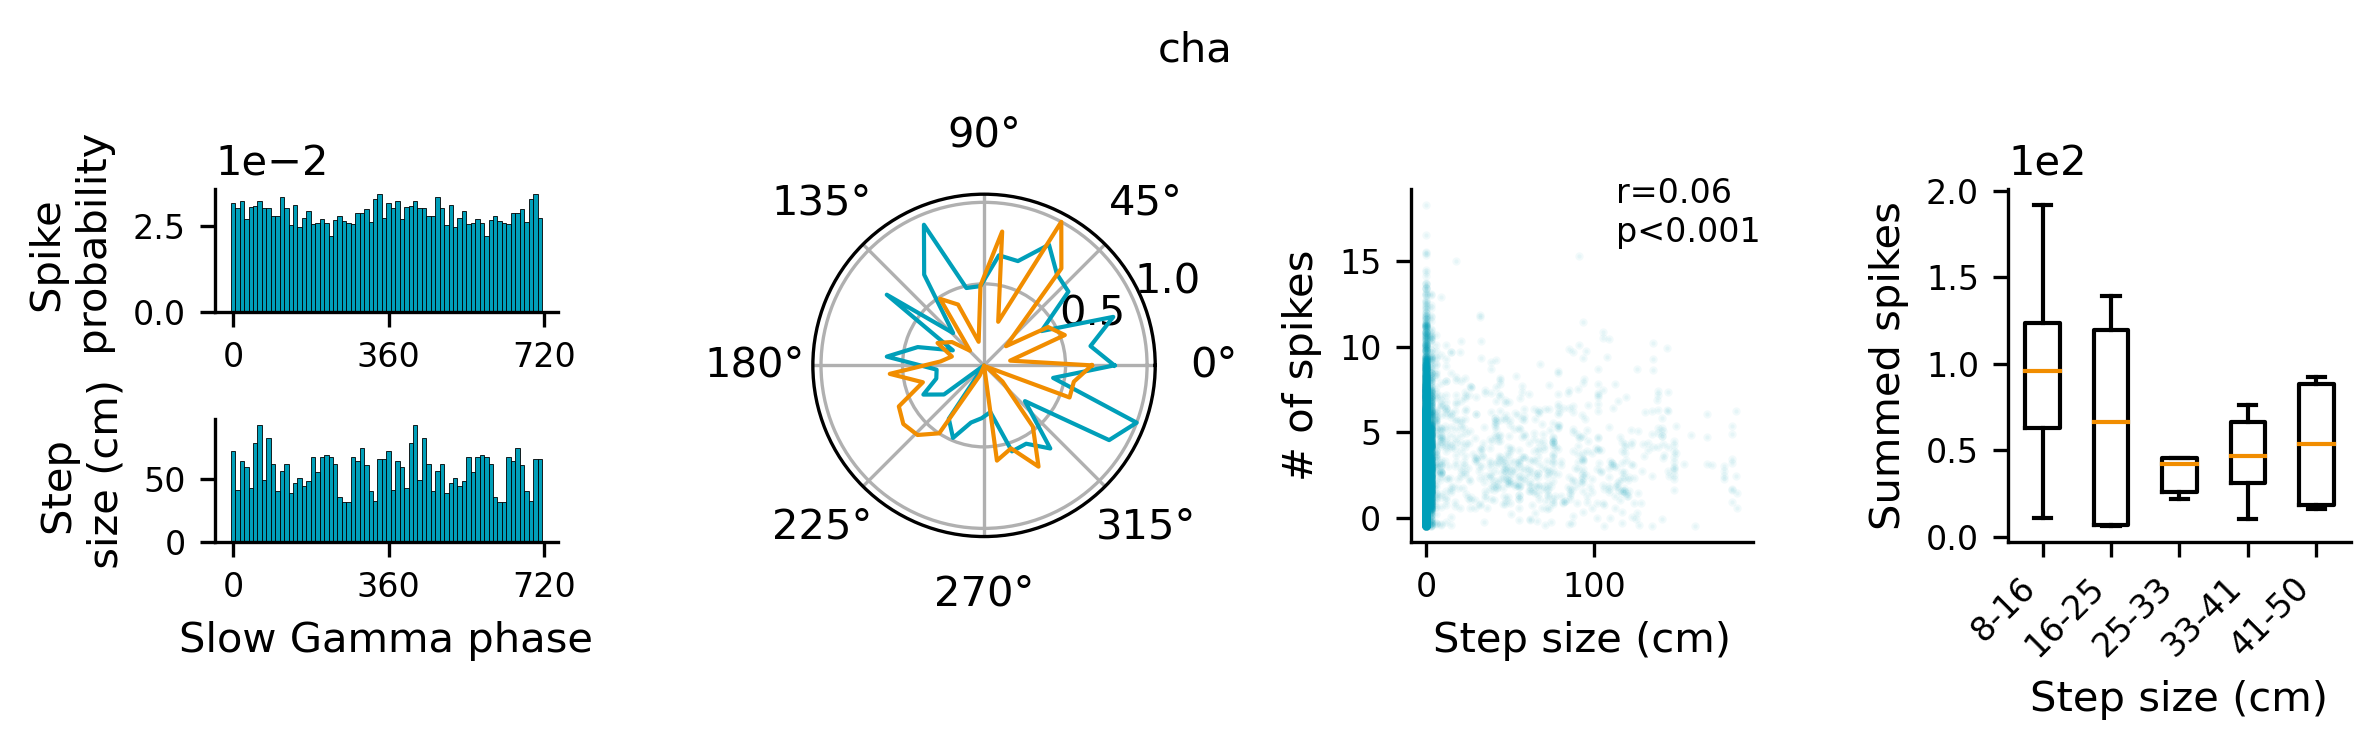

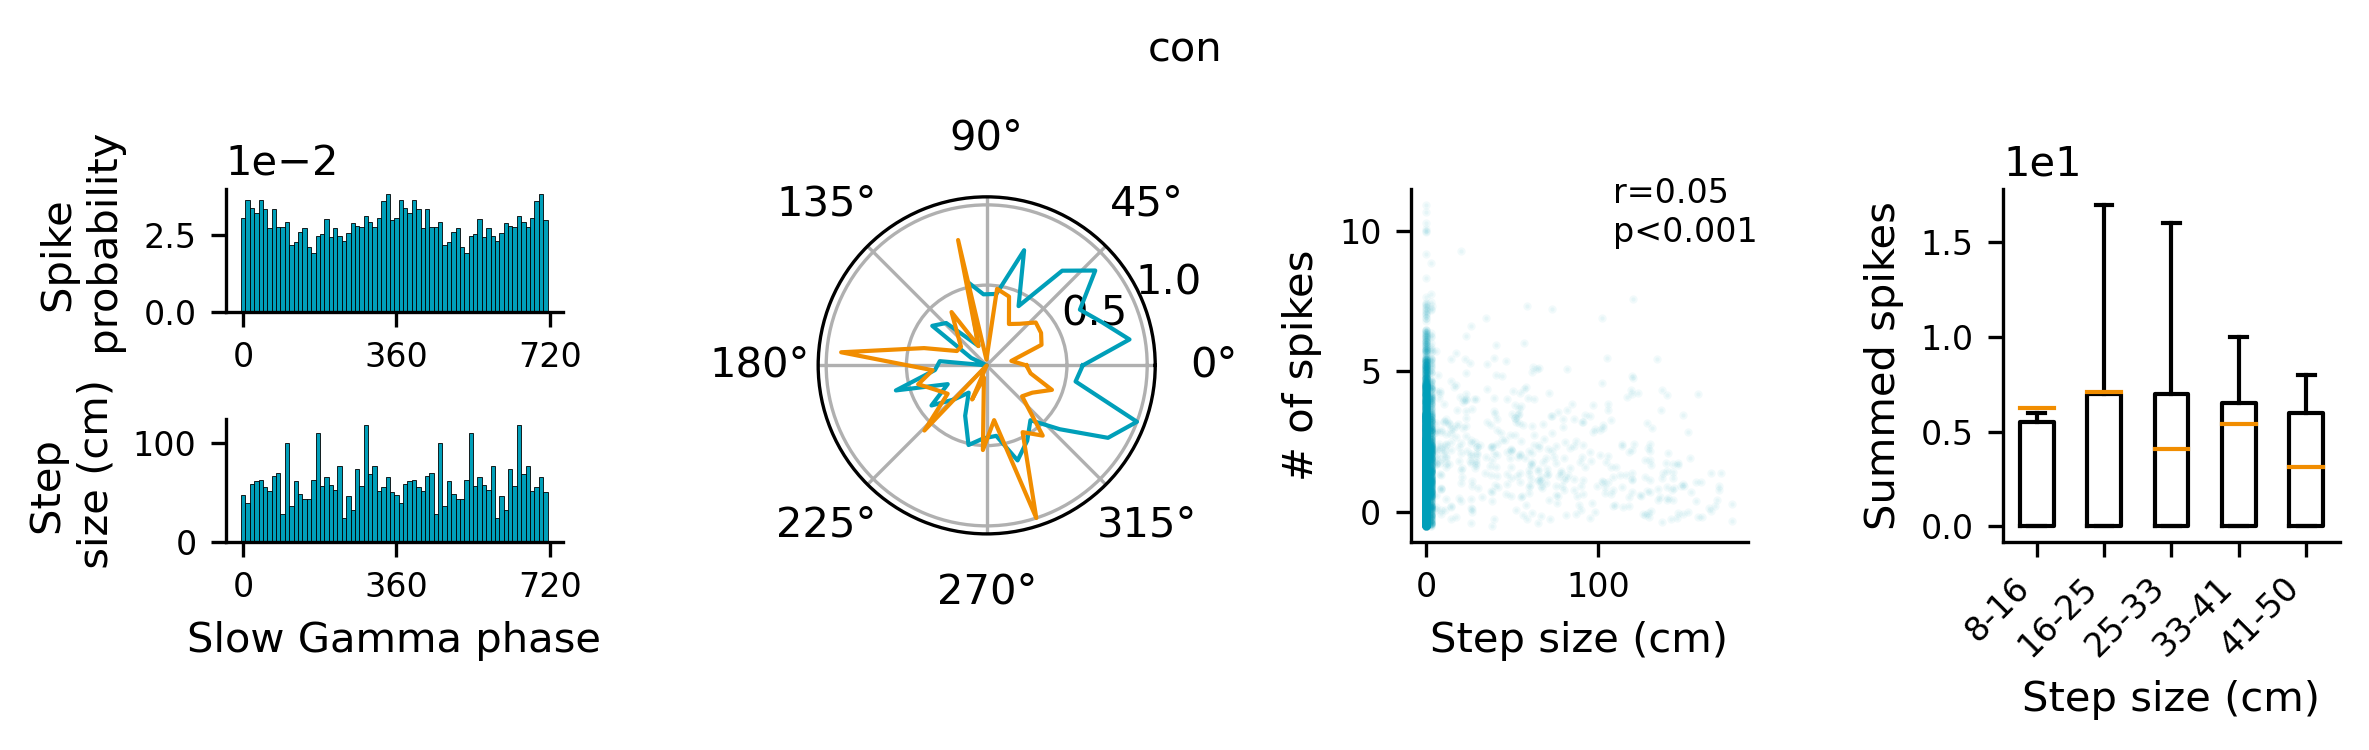

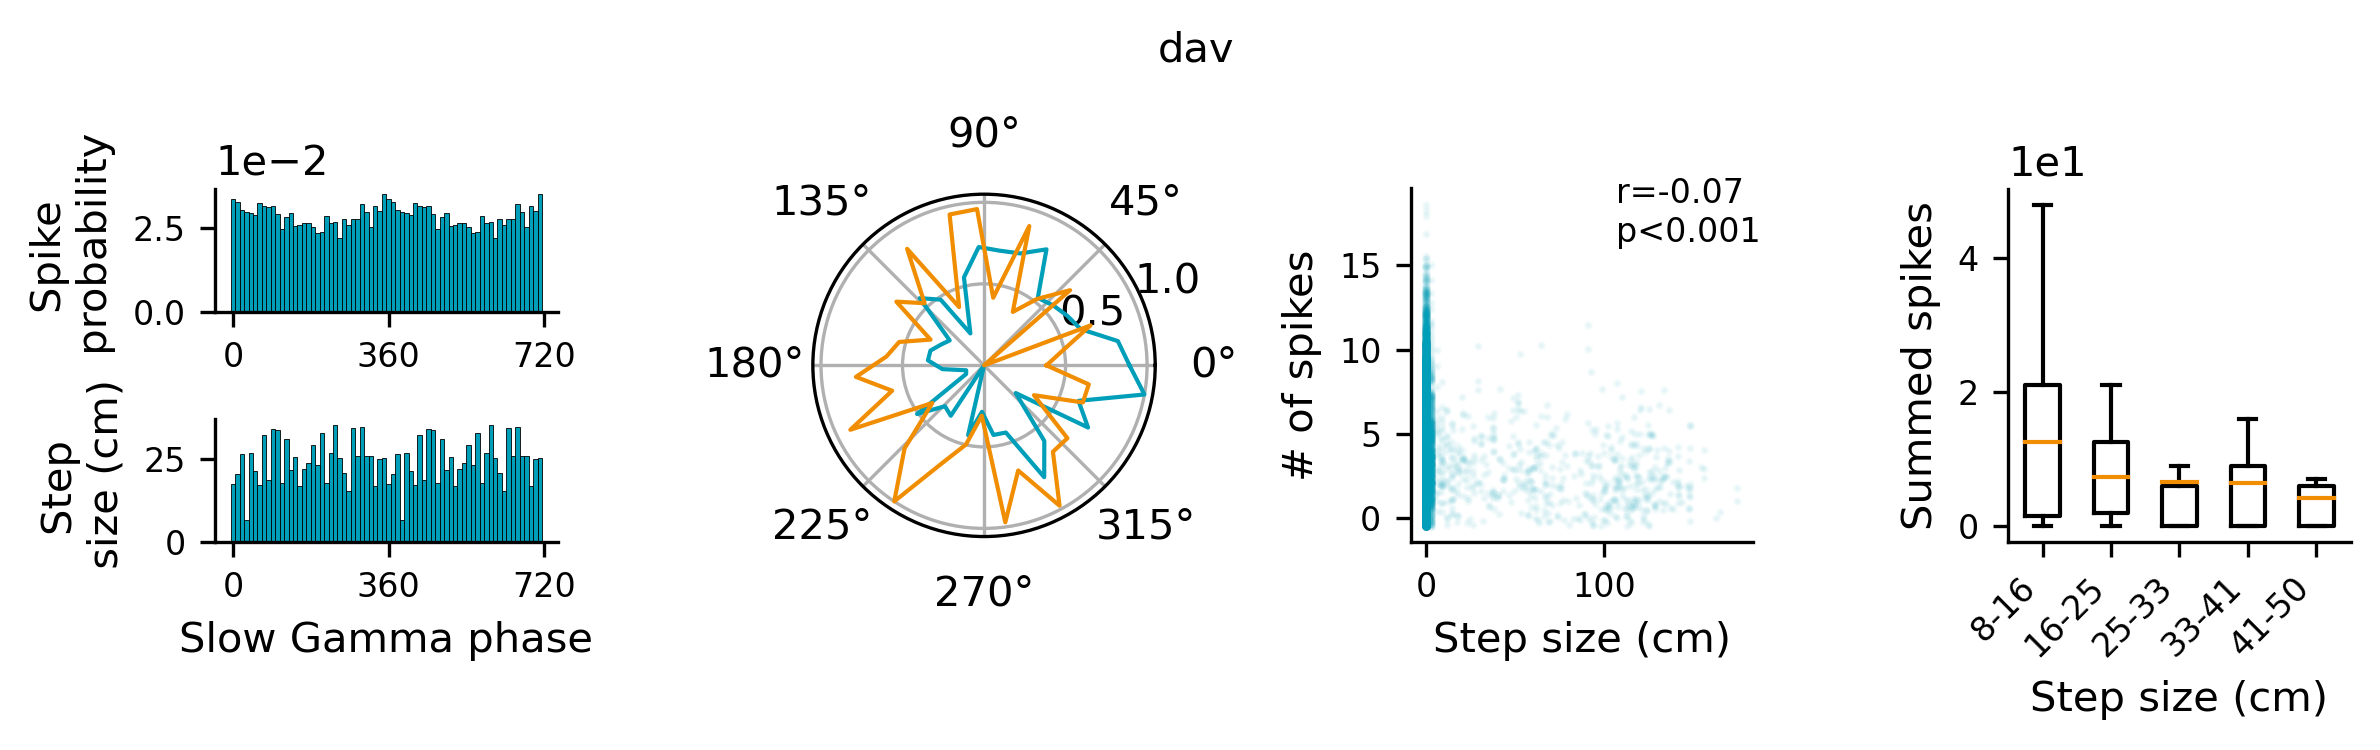

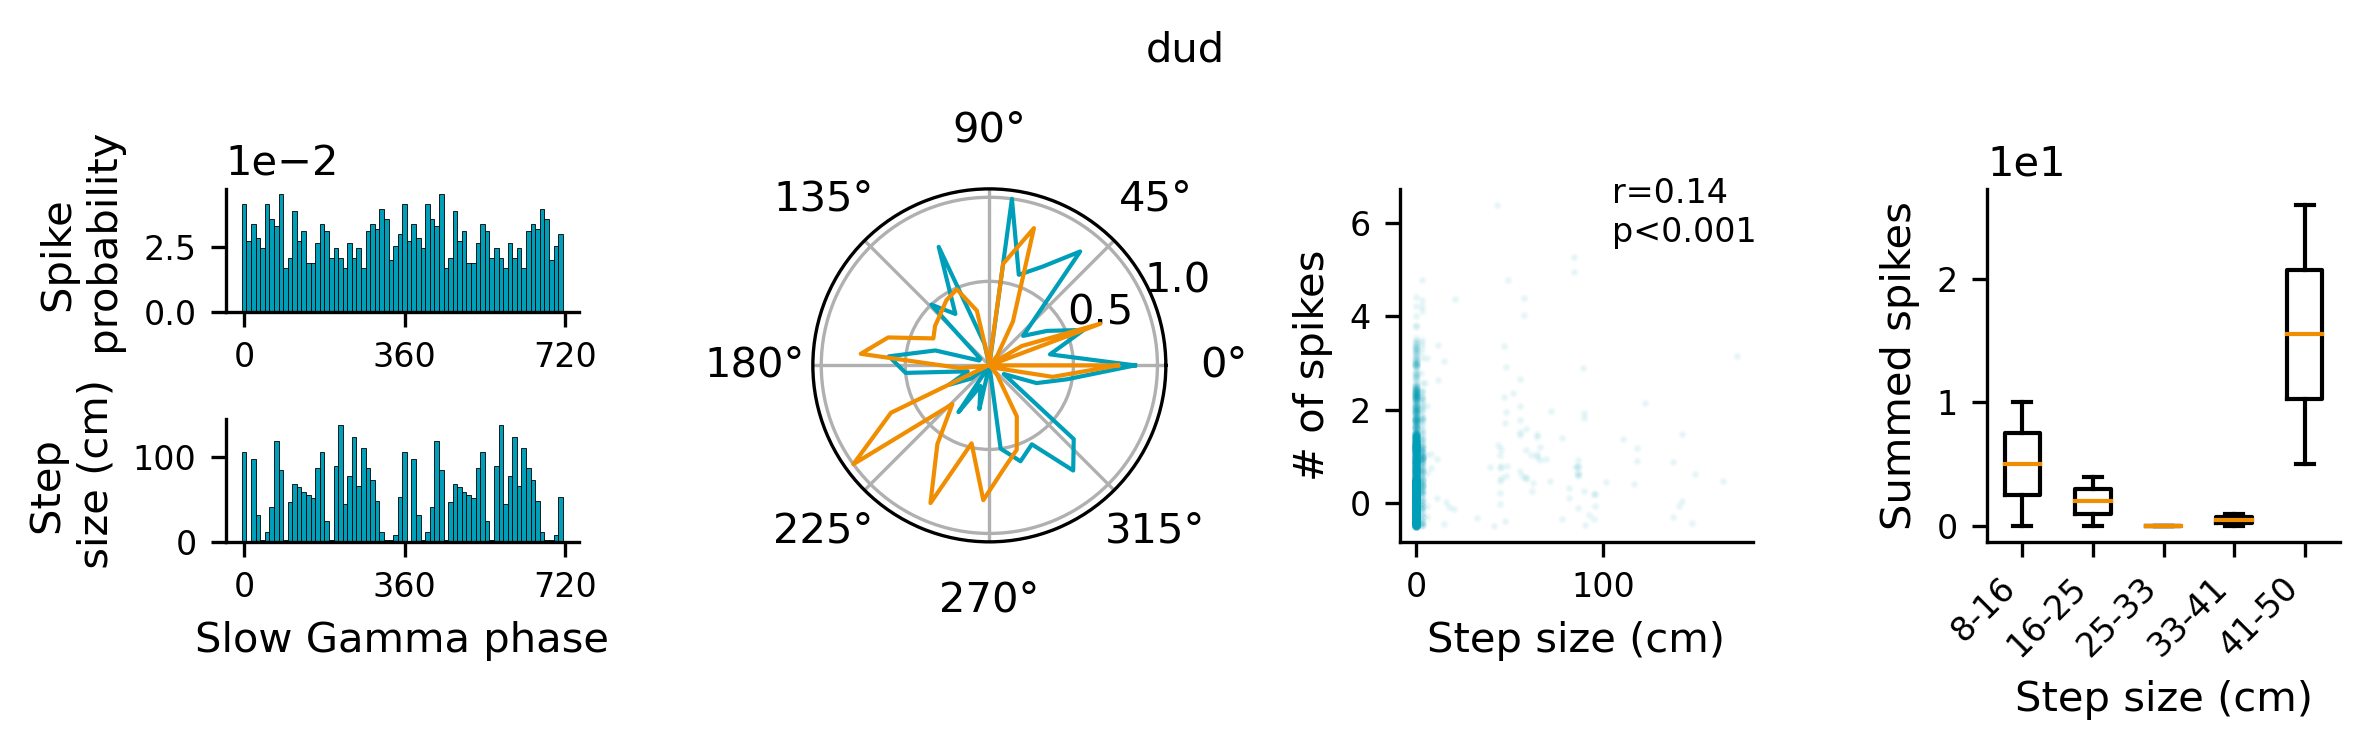

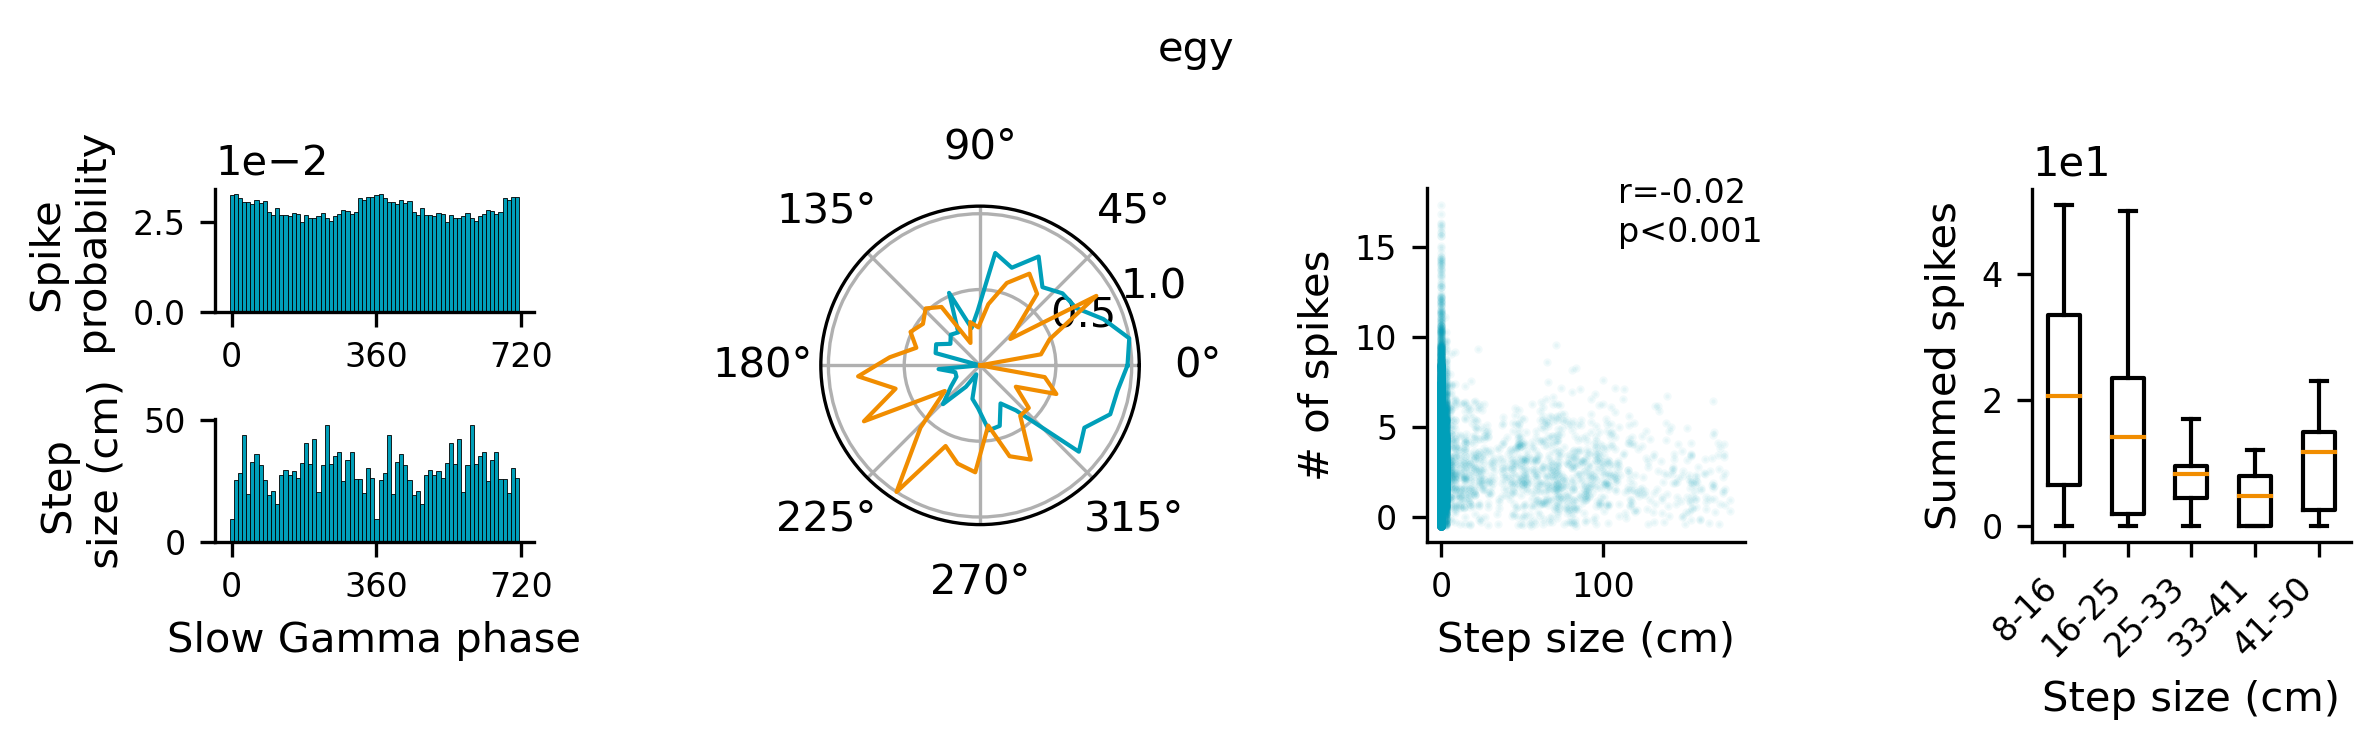

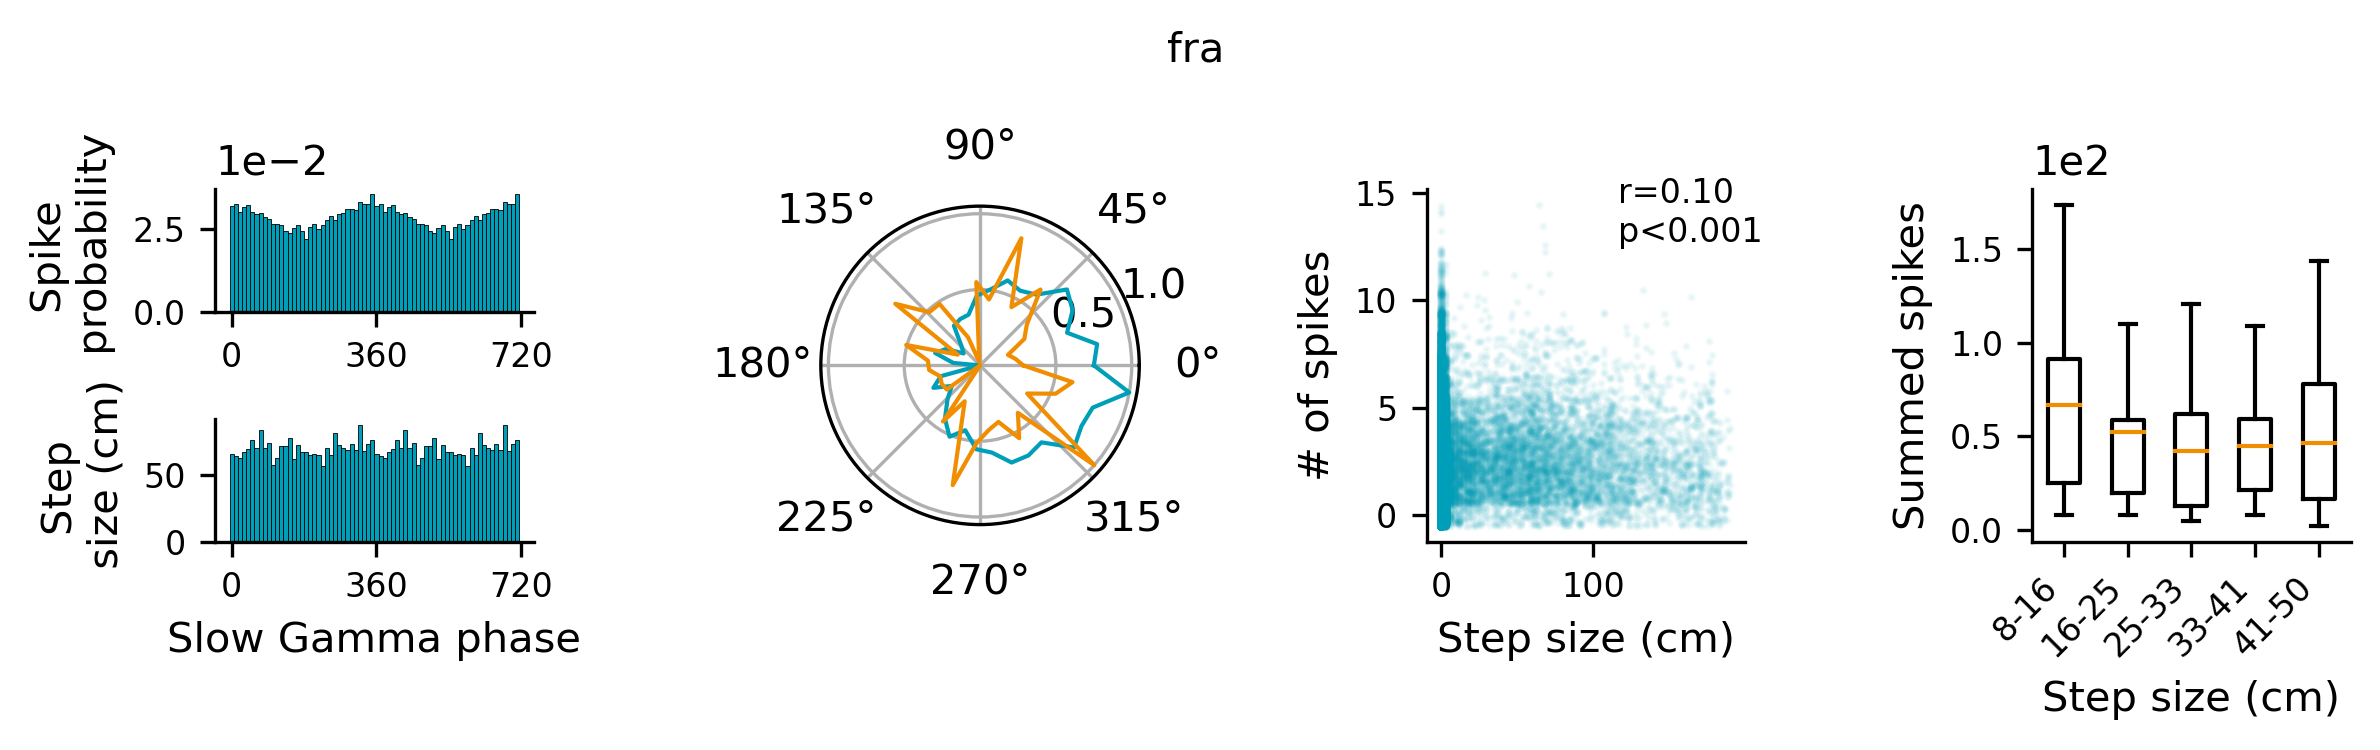

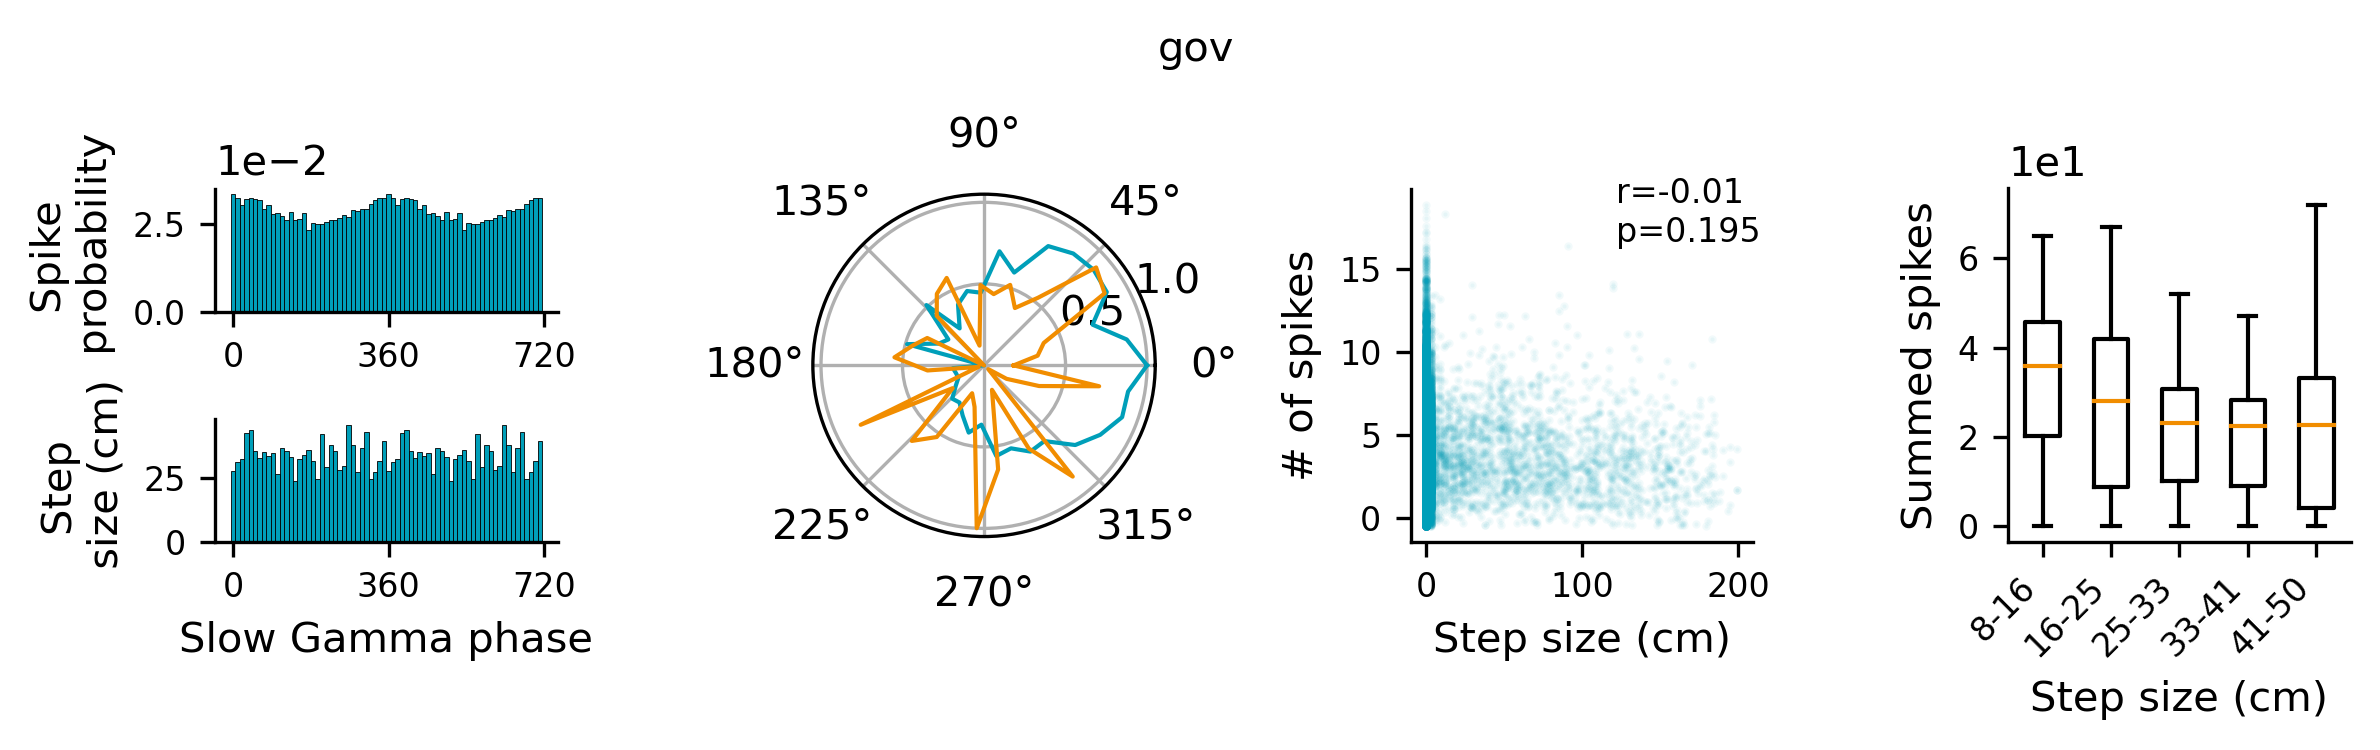

In [26]:
##merge the step size, multiunit spikes and multiunit firing rate from epochs under each animal into a list
all_step_size_peranimal = {}
all_multiunit_spikes_at_step_size_peranimal = {}
all_multiunit_fr_at_step_size_peranimal = {}
all_phase_at_step_size_peranimal = {}

for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    all_step_size_peranimal.setdefault(animal, []).extend(all_step_size[epoch_key])
    all_multiunit_spikes_at_step_size_peranimal.setdefault(animal, []).extend(all_multiunit_spikes_at_step_size[epoch_key])
    all_multiunit_fr_at_step_size_peranimal.setdefault(animal, []).extend(all_multiunit_fr_at_step_size[epoch_key])
    all_phase_at_step_size_peranimal.setdefault(animal, []).extend(all_phase_at_step_size[epoch_key])

#do the phase plot as above  for each animal
#all_multiunit_spikes_at_step_size_peranimal
for key in all_multiunit_spikes_at_step_size_peranimal.keys():
    
    step_size_array = np.array(all_step_size_peranimal[key])
    multiunit_spikes_at_step_size_array = np.array(all_multiunit_spikes_at_step_size_peranimal[key])
    phase_at_step_size_array = np.array(all_phase_at_step_size_peranimal[key])
    
    #filter out step_size_array<lthres and step_size_array>hthres for better visualization
    lthres = -1
    hthres = 200
    index = (step_size_array>lthres) & (step_size_array<hthres)
    step_size_array= step_size_array[index]
    multiunit_spikes_at_step_size_array = multiunit_spikes_at_step_size_array[index]
    phase_at_step_size_array = phase_at_step_size_array[index]
    

    fig = plt.figure(figsize=(8, 2.5), dpi=300)
    gs = gridspec.GridSpec(2, 4)

    #calculate the spike_phase and step_phase for each phase bin
    phase_bins = np.linspace(-np.pi, np.pi, 36)
    spike_phase = np.zeros(len(phase_bins)-1)
    step_phase = np.zeros(len(phase_bins)-1)
    for i in range(len(phase_bins)-1):
        summed_spike_i = np.sum(multiunit_spikes_at_step_size_array[(phase_at_step_size_array>=phase_bins[i]) & (phase_at_step_size_array<phase_bins[i+1])])
        spike_phase[i] = summed_spike_i/np.sum(multiunit_spikes_at_step_size_array)
        
        step_i = step_size_array[(phase_at_step_size_array>=phase_bins[i]) & (phase_at_step_size_array<phase_bins[i+1])]
        #get the mean value of top 10% step size
        step_i = np.sort(step_i)
        step_i = step_i[-int(len(step_i)*0.1):]
        mean_step_i = np.mean(step_i)
        #mean_step_i = np.mean(step_size_array[(phase_at_step_size_array>=phase_bins[i]) & (phase_at_step_size_array<phase_bins[i+1])])
        step_phase[i] = mean_step_i
        
    #scatter plot
    ax1 = plt.subplot(gs[0,0])
    #do bar plot with facecolor #009FB9, edge color black. repeat two cycles to make the bar plot continuous. set edgelinewidth=0.5
    ax1.bar(phase_bins[:-1]+np.pi, spike_phase, width=phase_bins[1]-phase_bins[0], facecolor='#009FB9', edgecolor='black', linewidth=0.2)
    ax1.bar(phase_bins[:-1]+3*np.pi, spike_phase, width=phase_bins[1]-phase_bins[0], facecolor='#009FB9', edgecolor='black', linewidth=0.2)

    #set x tciks from [0, 2*pi, 4*pi] to [0, 360, 720] degree
    ax1.set_xticks([0, 2*np.pi, 4*np.pi])
    ax1.set_xticklabels(['0', '360', '720'], fontsize=ticksize)

    ax1.set_ylabel('Spike \n probability', fontsize=labelsize)
    #y ticks in scientific notation
    ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    ############################################################################################################

    ax2 = plt.subplot(gs[1,0])
    #plot step_size_array at each phase bin
    #do bar plot with facecolor #009FB9, edge color black
    ax2.bar(phase_bins[:-1]+np.pi, step_phase, width=phase_bins[1]-phase_bins[0], facecolor='#009FB9', edgecolor='black', linewidth=0.2)
    ax2.bar(phase_bins[:-1]+3*np.pi, step_phase, width=phase_bins[1]-phase_bins[0], facecolor='#009FB9', edgecolor='black', linewidth=0.2)

    #set x tciks from [0, 2*pi, 4*pi] to [0, 360, 720] degree
    ax2.set_xticks([0, 2*np.pi, 4*np.pi])
    ax2.set_xticklabels(['0', '360', '720'], fontsize=ticksize)

    ax2.set_xlabel('Slow Gamma phase', fontsize=labelsize)
    ax2.set_ylabel('Step \n size (cm)', fontsize=labelsize)

    ############################################################################################################

    #change the histogram plot into a polor plot with different colors for spike_phase and step_phase
    ax3 = plt.subplot(gs[:,1], projection='polar')
    #normalize spike_phase and step_phase by dividing the sum of them BEFORE plotting bu subtracting the minimum value and dividing by the range
    spike_phase_norm = (spike_phase-np.min(spike_phase))/(np.max(spike_phase)-np.min(spike_phase))
    step_phase_norm = (step_phase-np.min(step_phase))/(np.max(step_phase)-np.min(step_phase))

    #plot spike_phase as a polar plot with the end linked to the start
    ax3.plot(np.linspace(0, 2*np.pi, len(spike_phase_norm)+1), np.append(spike_phase_norm, spike_phase_norm[0]), color='#009FB9', linewidth=1)
    #plot step_phase as a polar plot with the end linked to the start
    ax3.plot(np.linspace(0, 2*np.pi, len(step_phase_norm)+1), np.append(step_phase_norm, step_phase_norm[0]), color='#F18D00', linewidth=1)
    #add an arrow represent the circular weighted mean of spike_phase_norm
    #mean_spike_phase = np.angle(np.mean(np.exp(1j*phase_at_step_size)))

    ############################################################################################################

    #scatter plot
    ax4 = plt.subplot(gs[:,2])

    ax4.scatter(step_size_array, 
                multiunit_spikes_at_step_size_array+np.random.uniform(-0.5, 0.5, len(multiunit_spikes_at_step_size_array)),
                s=1, c='#009FB9', alpha=0.05)

    #check the person correlation between step size and multiunit spikes and add p abd r values to the plot, with p values as scientific notation
    from scipy.stats import pearsonr
    r, p = pearsonr(step_size_array, multiunit_spikes_at_step_size_array)
    if p<0.001:
        ax4.text(0.6, 0.85, f'r={r:.2f}\np<0.001', transform=plt.gca().transAxes, fontsize=ticksize)
    else:
        ax4.text(0.6, 0.85, f'r={r:.2f}\np={p:.3f}', transform=plt.gca().transAxes, fontsize=ticksize)

    ax4.set_xlabel('Step size (cm)', fontsize=labelsize)
    ax4.set_ylabel('# of spikes', fontsize=labelsize)

    ############################################################################################################

    ax5 = plt.subplot(gs[:,3])

    #merge the step size, multiunit spikes and multiunit firing rate from epochs under each animal each day into a list
    all_step_size_persession = {}
    all_multiunit_spikes_at_step_size_persession = {}
    all_multiunit_fr_at_step_size_persession = {}
    all_phase_at_step_size_persession = {}
    
    bined_multiunitspikeS = {}
    #get all the sessions for the animal under current key
    for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
        animal, day, epoch = epoch_key
        if animal==key:
            stepsizeS = np.array(all_step_size[epoch_key])
            multiunitspikeS = np.array(all_multiunit_spikes_at_step_size[epoch_key])
            #split stepsizeS into 10 bins, in each bin, count the number of multiunit spikes
            
            bins = np.linspace(0, 50, 7)
            #get the index of the bin that each stepsizeS belongs to
            inds = np.digitize(stepsizeS, bins)
            #get the number of multiunit spikes in each bin
            multiunitspikeS_binned = [np.sum(multiunitspikeS[inds==i]) for i in range(1, len(bins))]
            
            bined_multiunitspikeS[epoch_key] = multiunitspikeS_binned[1:]           

    #convert the dictionary to numpy array
    bined_multiunitspikeS_array = np.array(list(bined_multiunitspikeS.values()))
        
    #plot box plot with mean and std, change the color of mean to red, remove the median line
    ax5.boxplot(bined_multiunitspikeS_array, showmeans=True, meanline=True, showfliers=False, 
                flierprops=dict(markersize=3), 
                meanprops=dict(color='#F18D00', linestyle='-', linewidth=1), 
                medianprops=dict(color='#009FB9', alpha=0))

    #set the xlabels for each bin using values in bins
    ax5.set_xticklabels([f'{int(bins[i])}-{int(bins[i+1])}' for i in range(1, len(bins)-1)], rotation=45, ha='right')

    ax5.set_xlabel('Step size (cm)', fontsize=labelsize)
    ax5.set_ylabel('Summed spikes', fontsize=labelsize)
    #yticks in scientific notation
    ax5.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    #for all axes, set tick size as ticksize, set x and y tick label size as labelsize
    #remove top and right spines
    for ax in [ax1, ax2, ax4, ax5]:
        ax.tick_params(axis='both', which='major', labelsize=ticksize)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    #set a super title indicating the animal name
    plt.suptitle(key, fontsize=labelsize)

    
    plt.tight_layout()

epochs: 100%|██████████| 140/140 [00:00<00:00, 7888.58it/s]


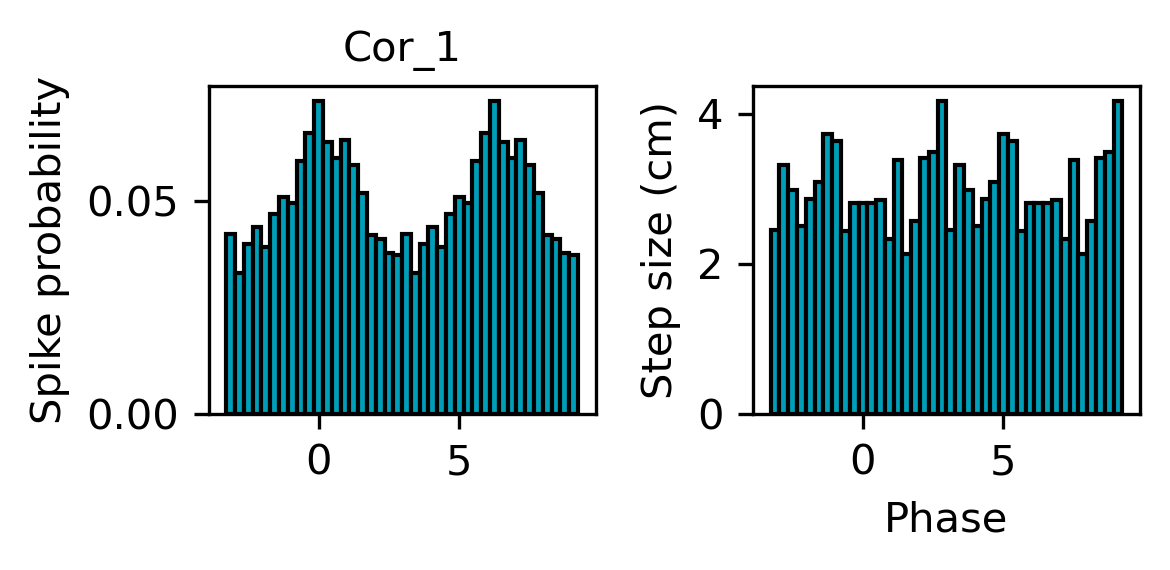

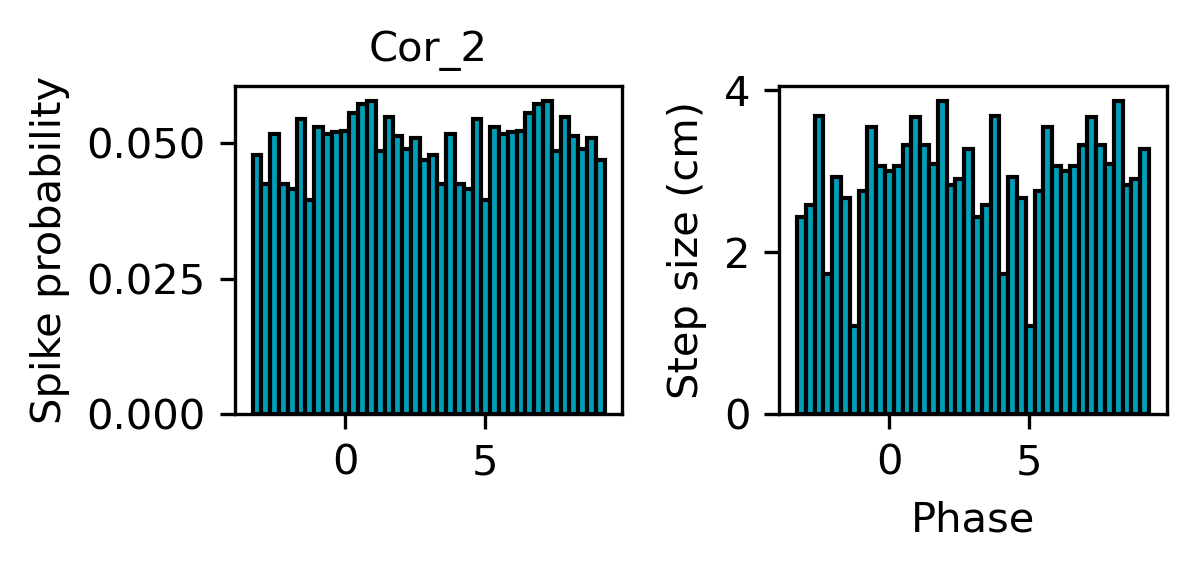

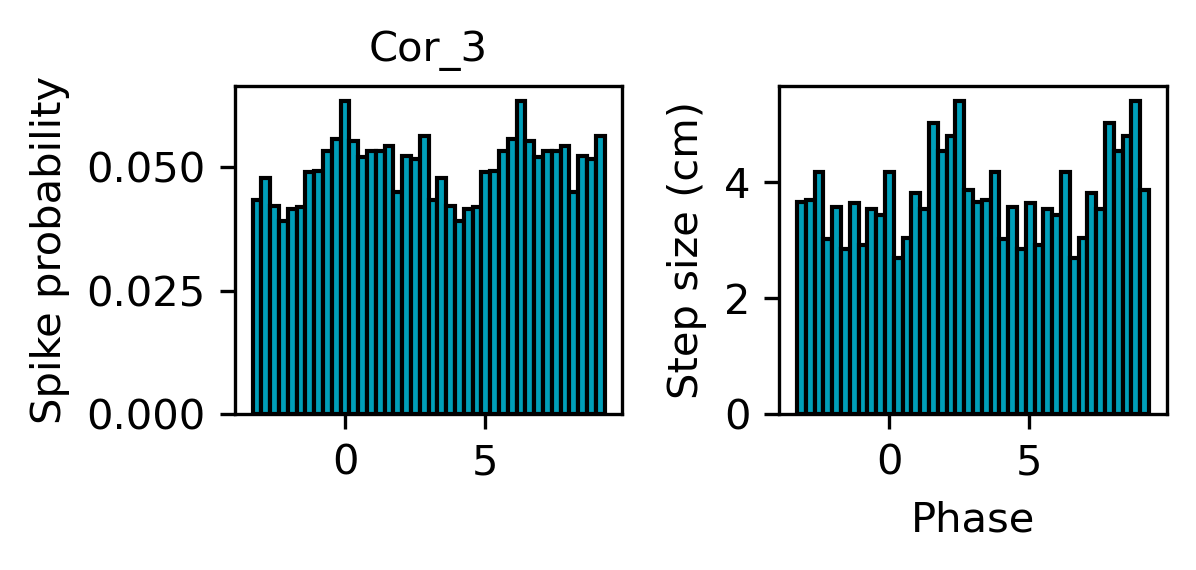

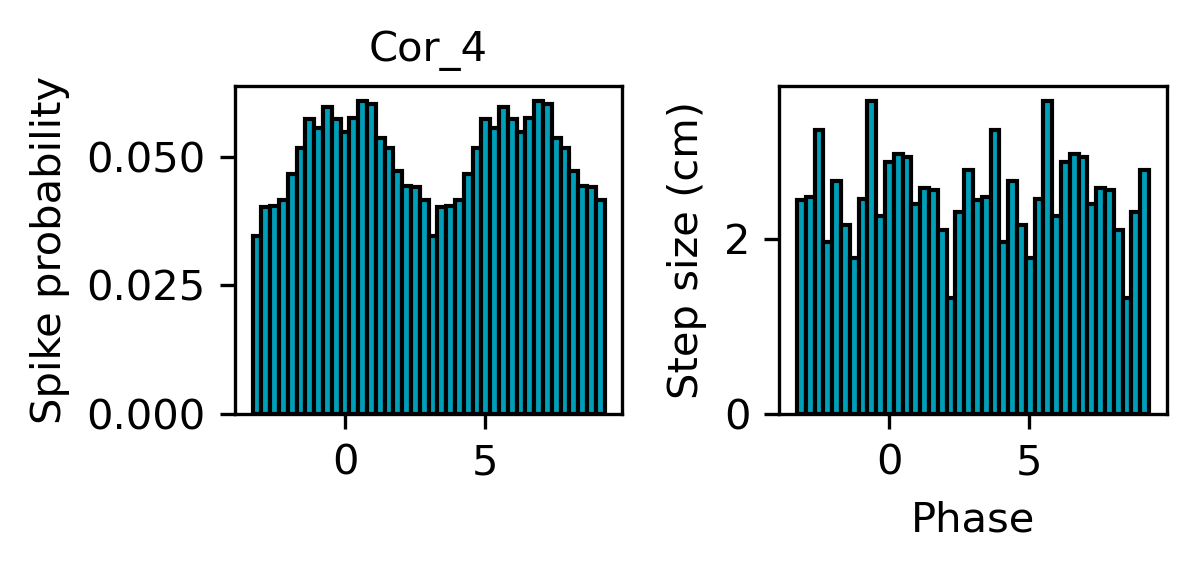

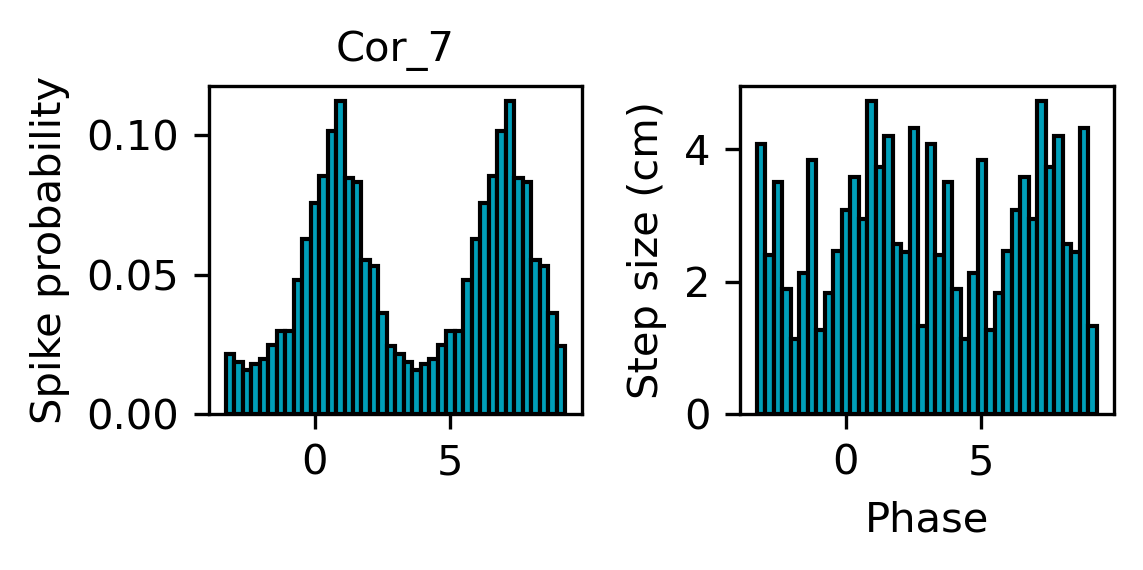

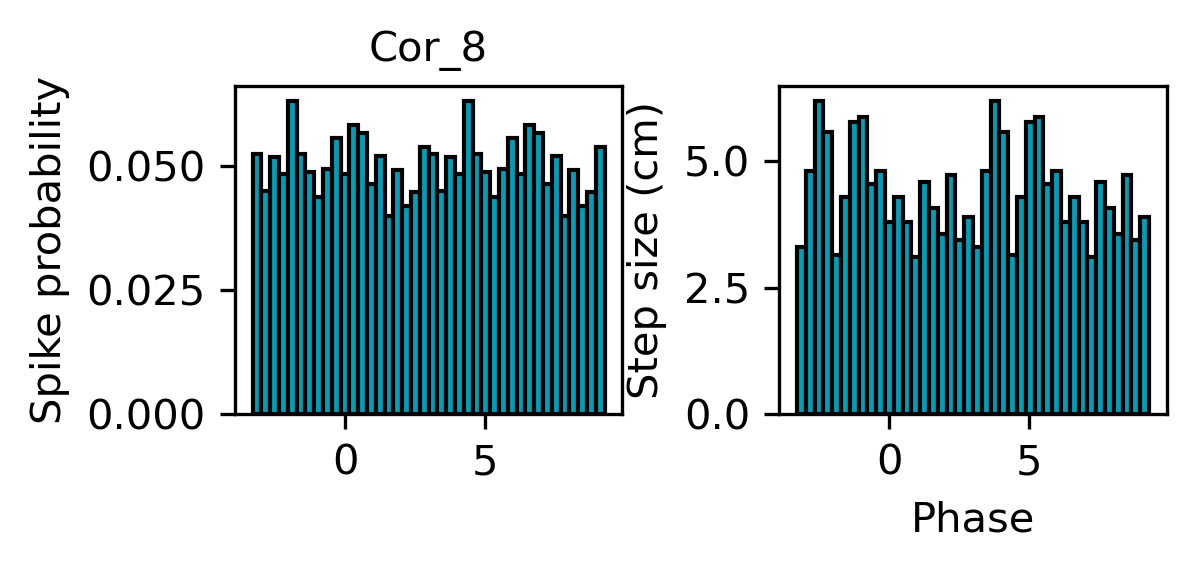

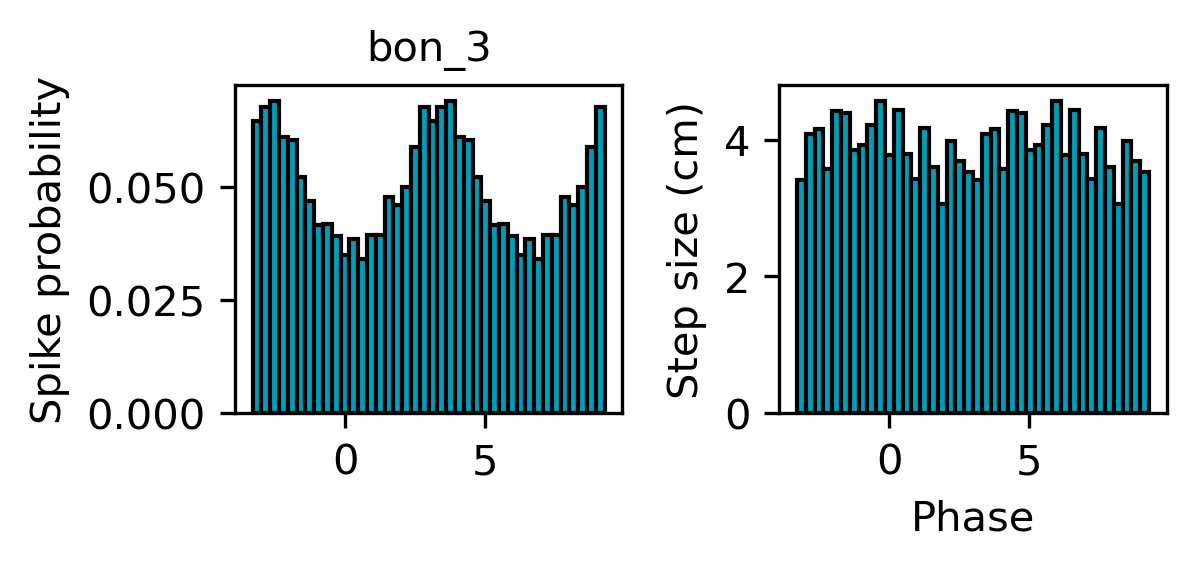

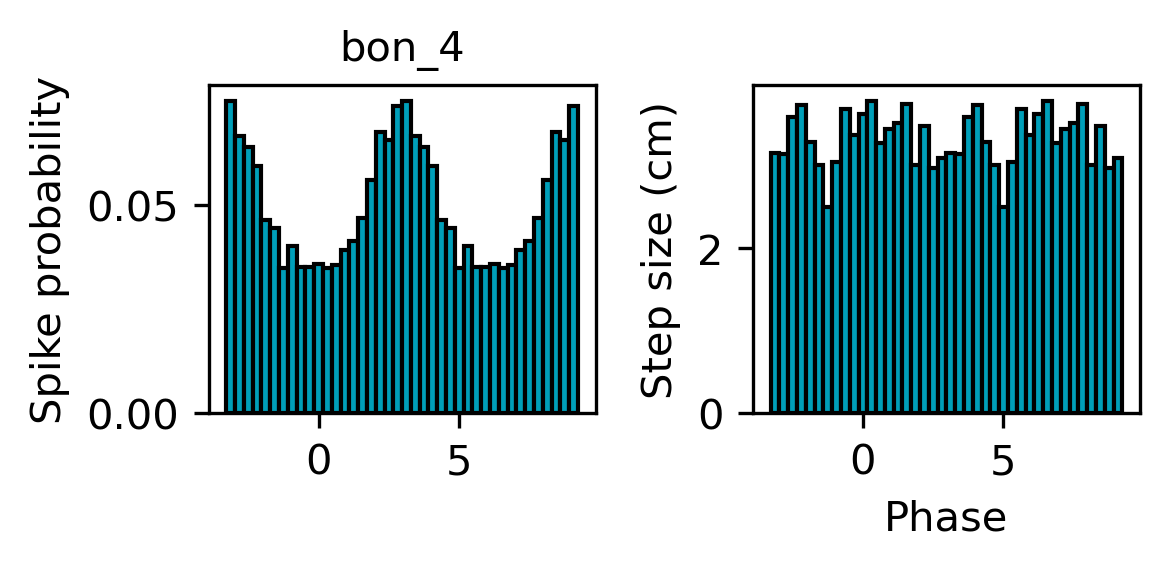

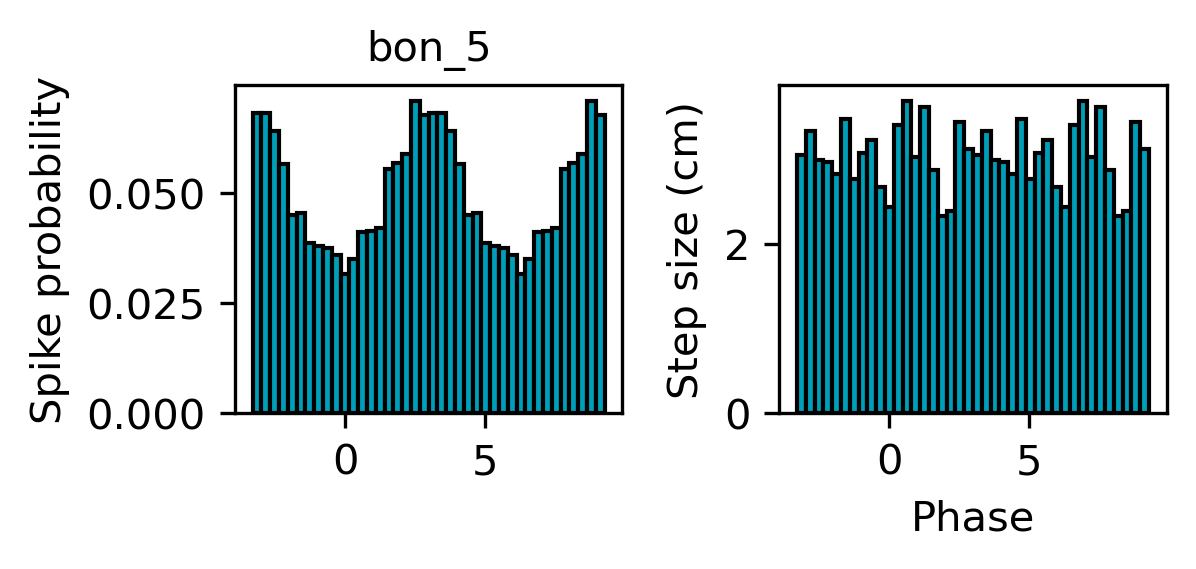

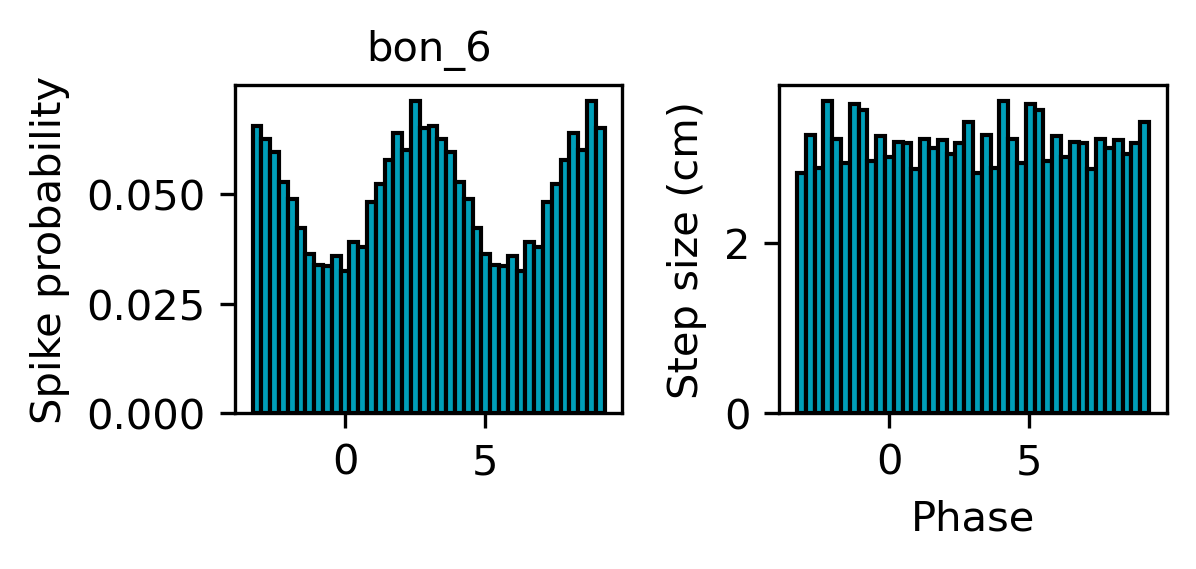

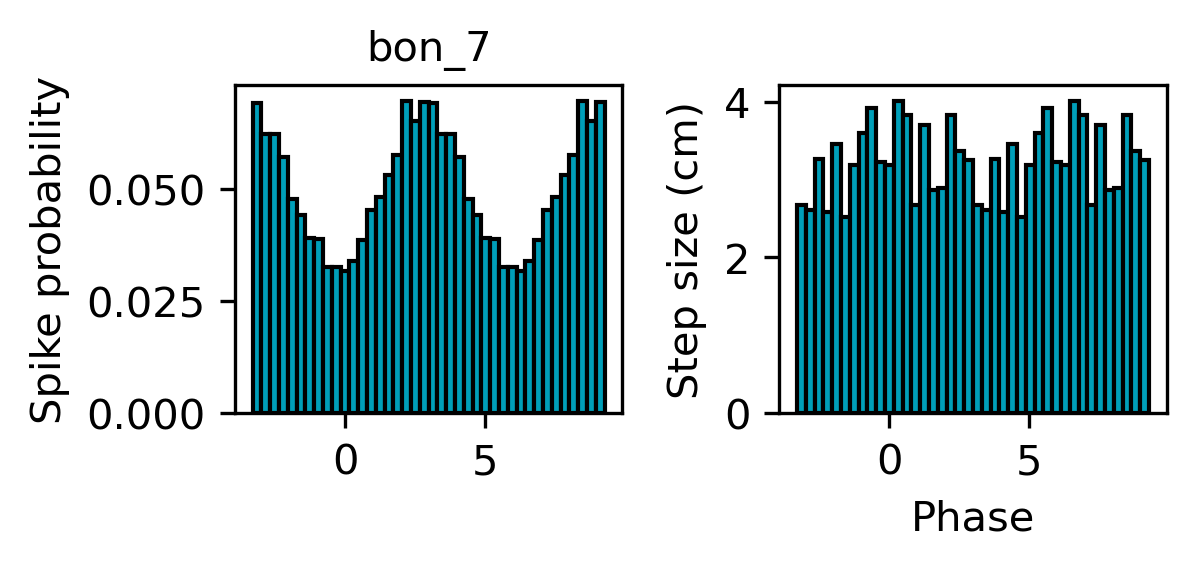

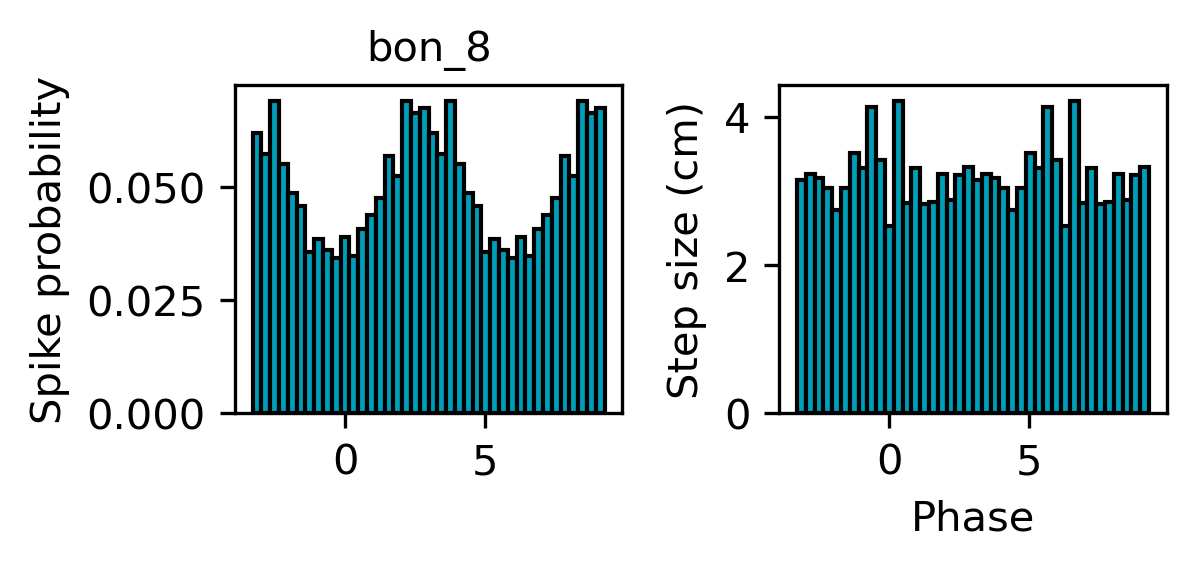

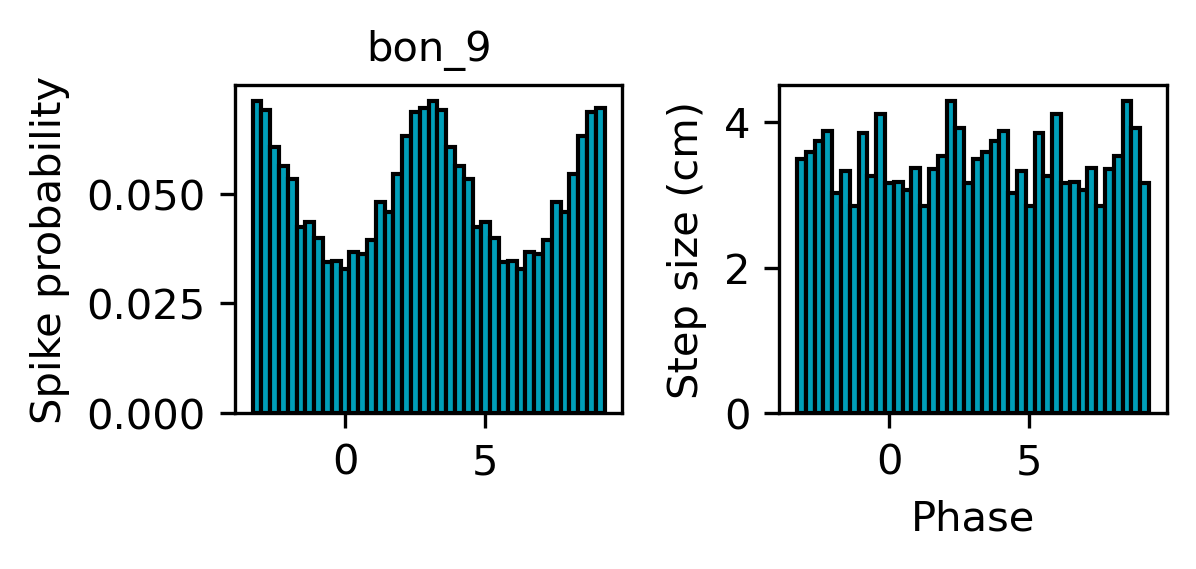

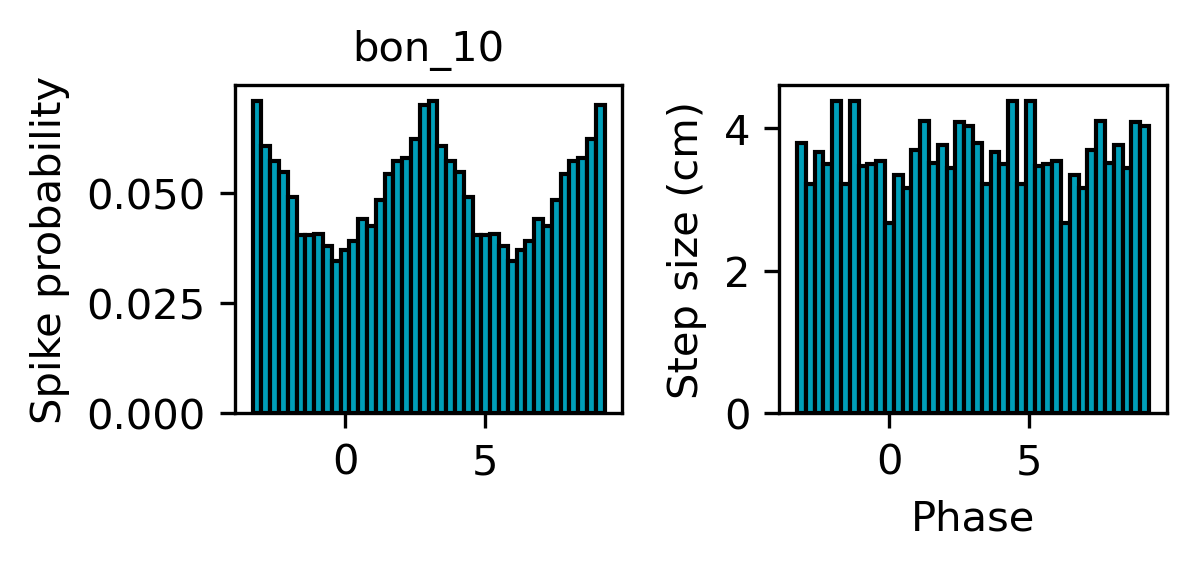

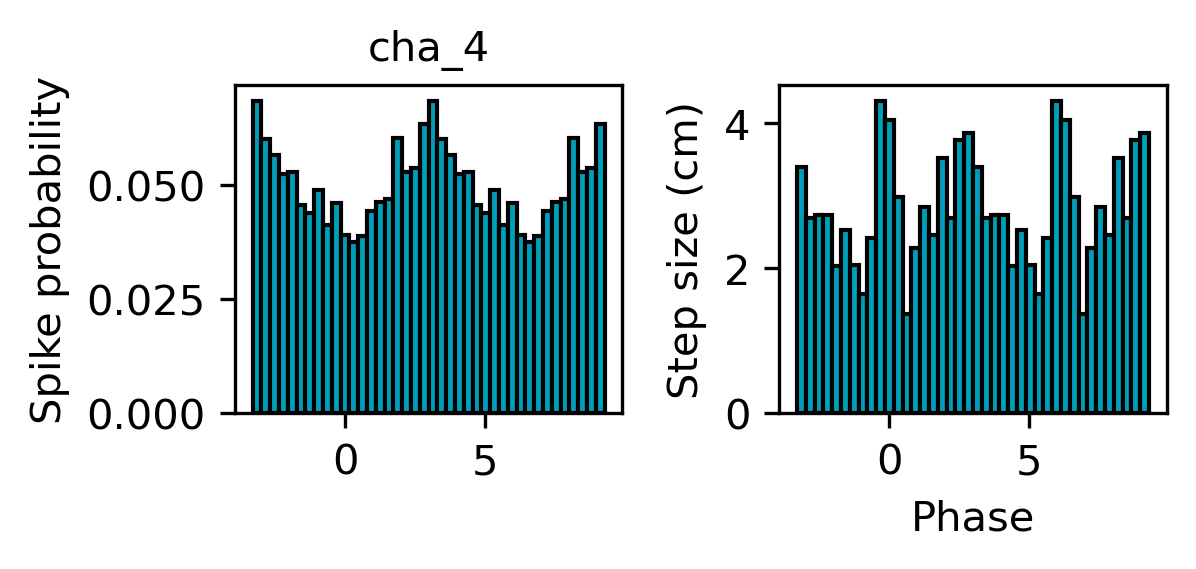

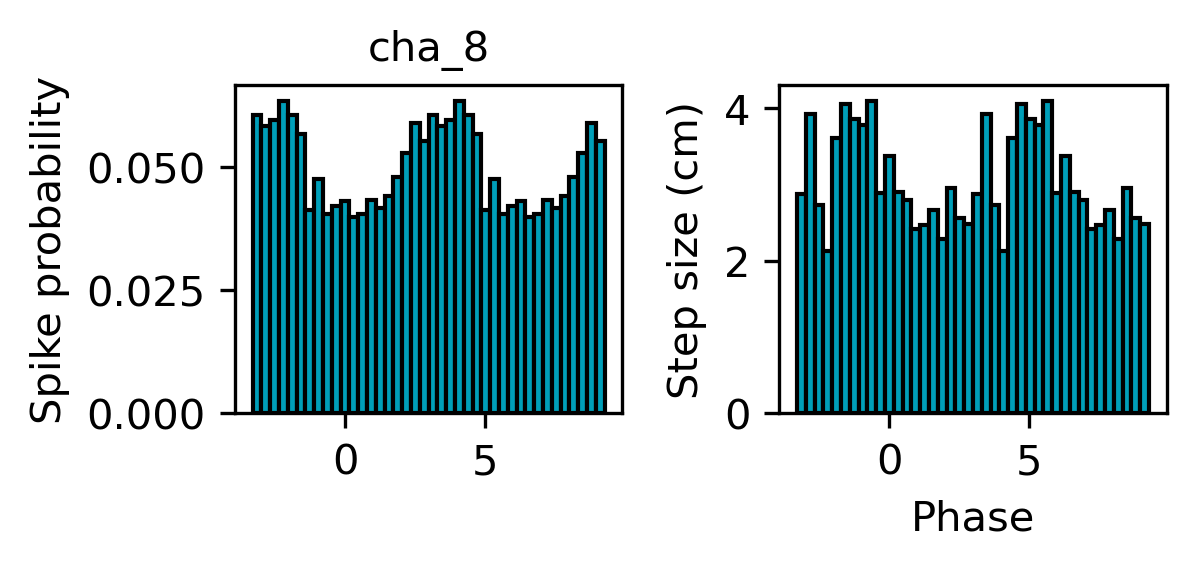

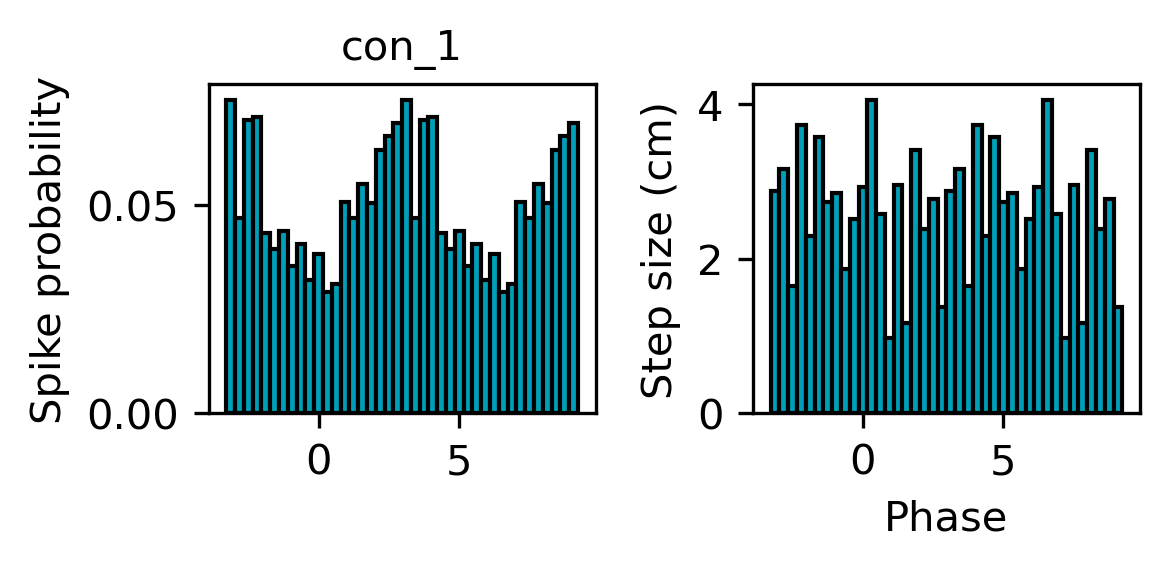

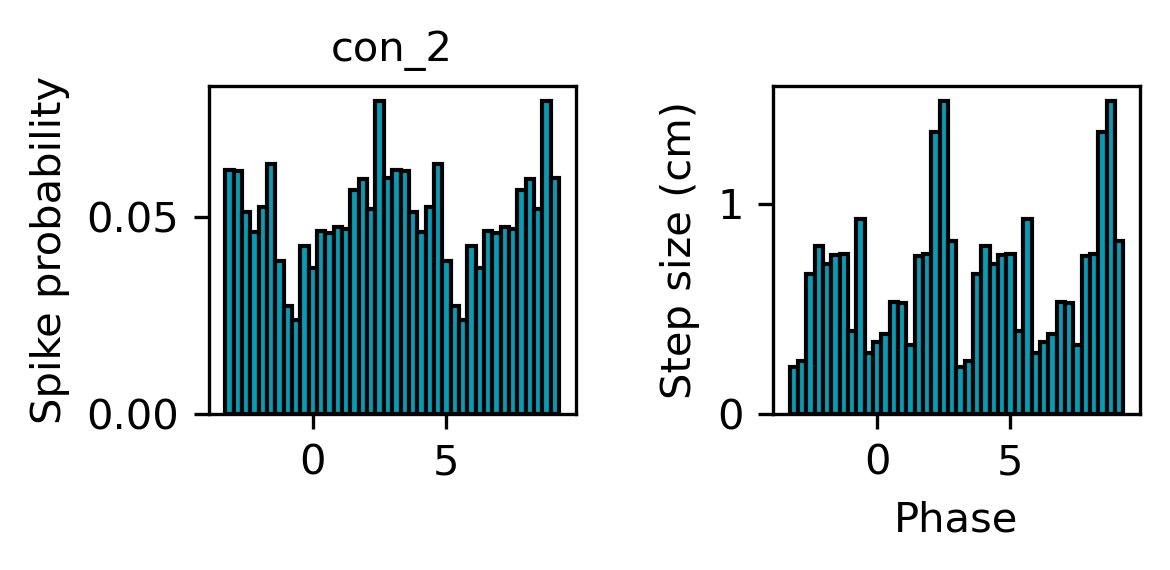

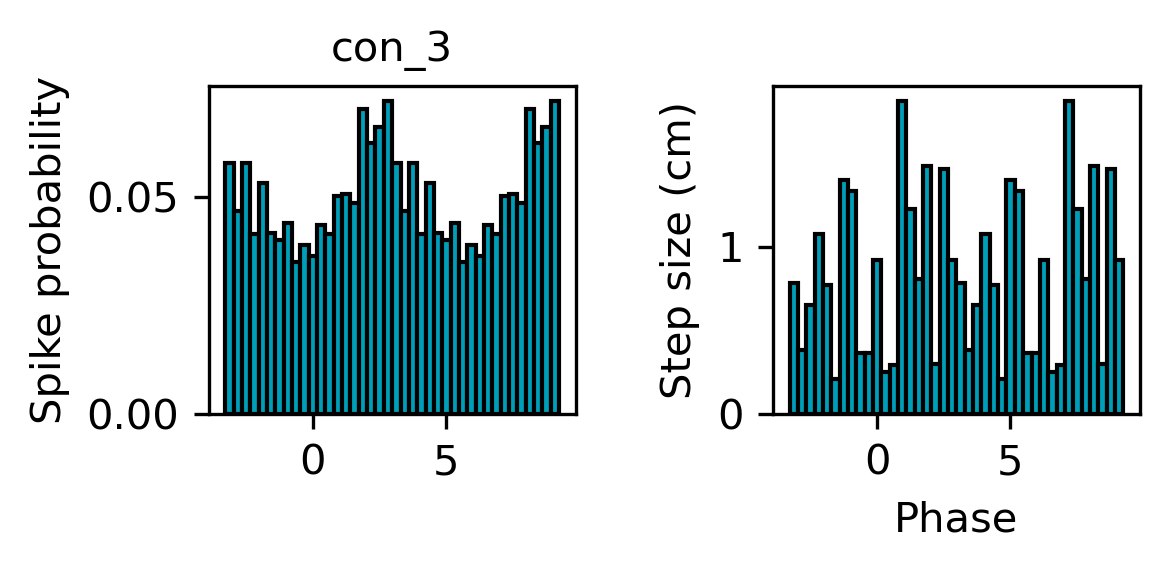

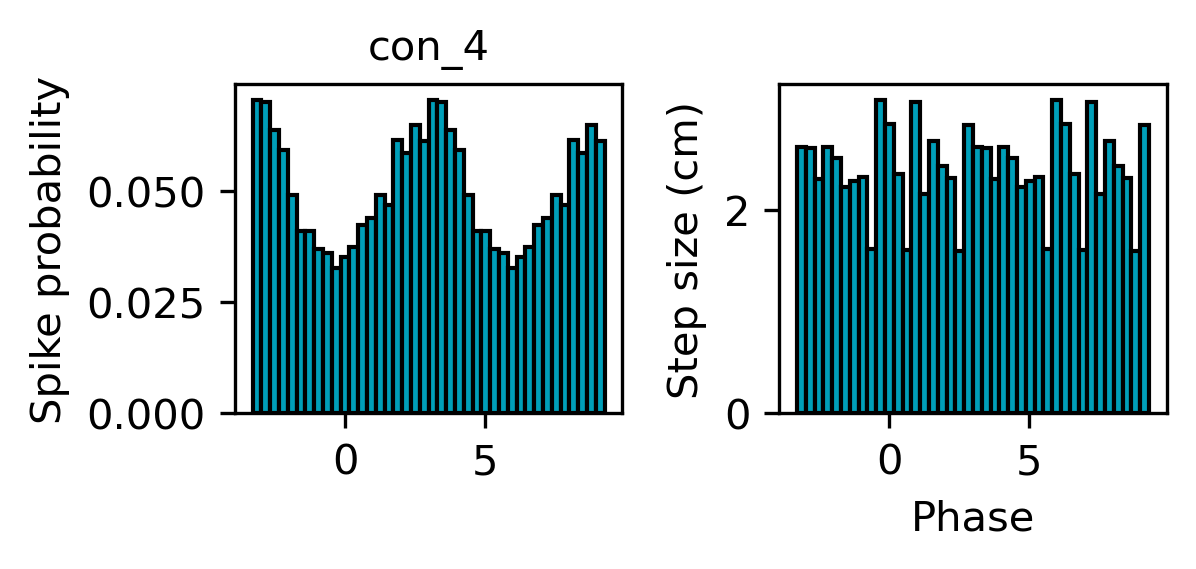

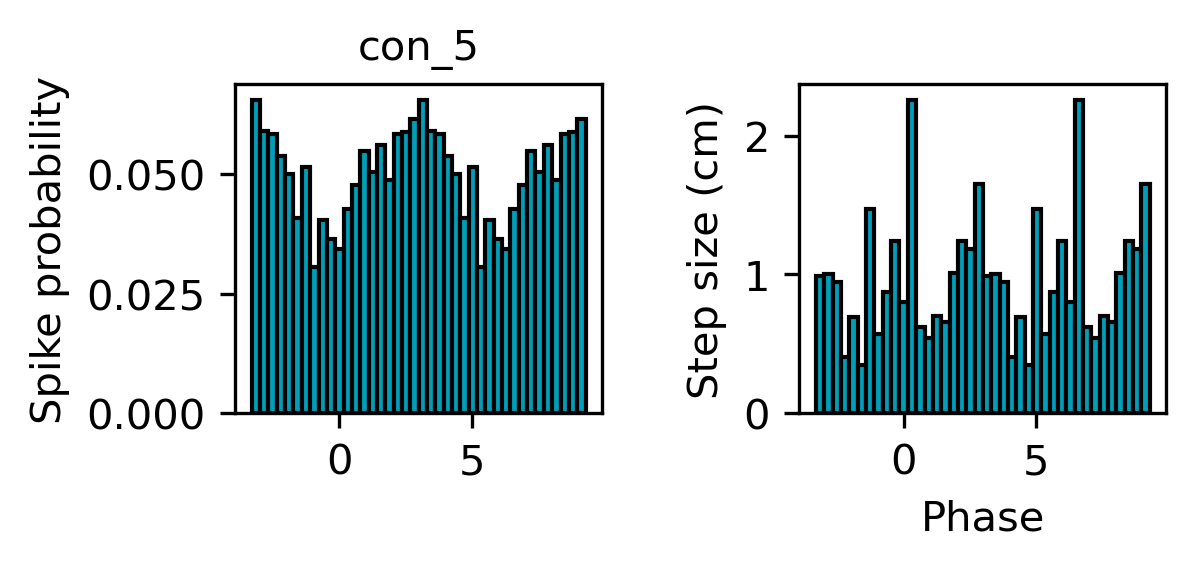

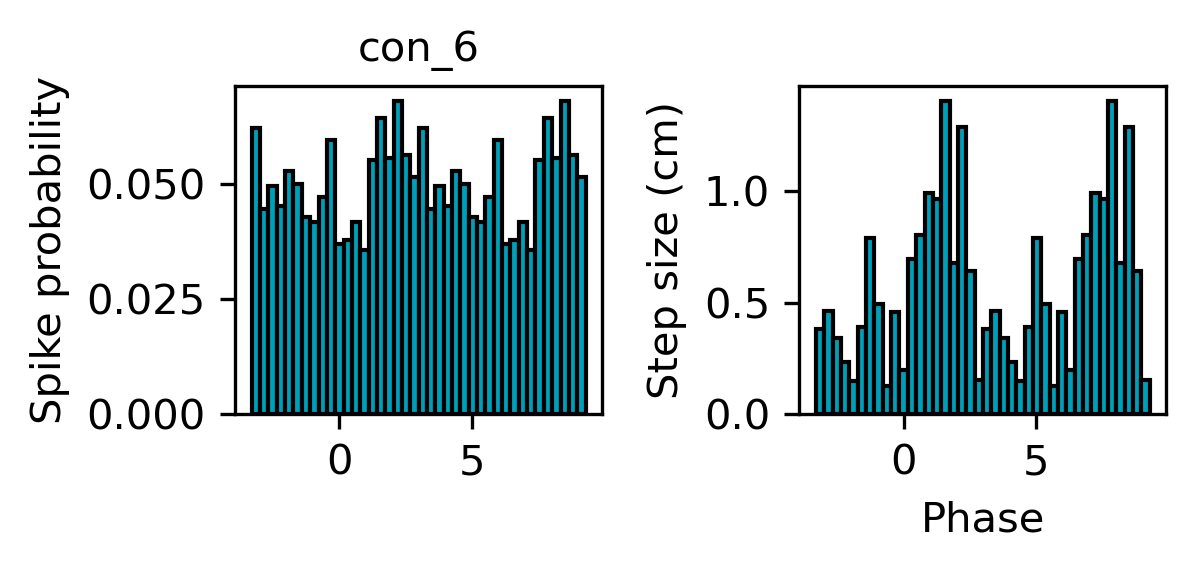

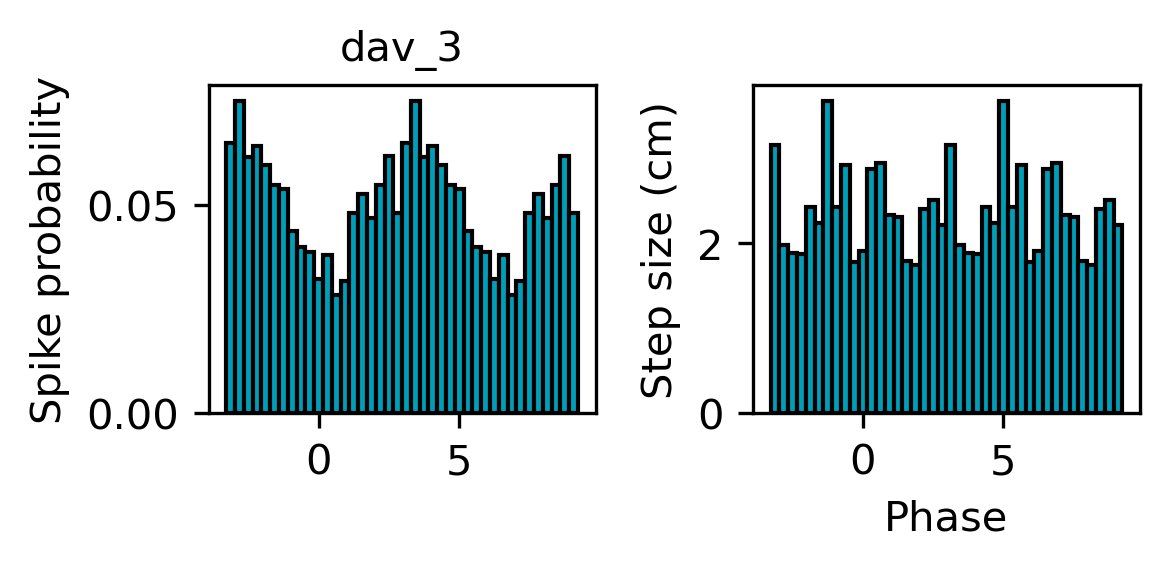

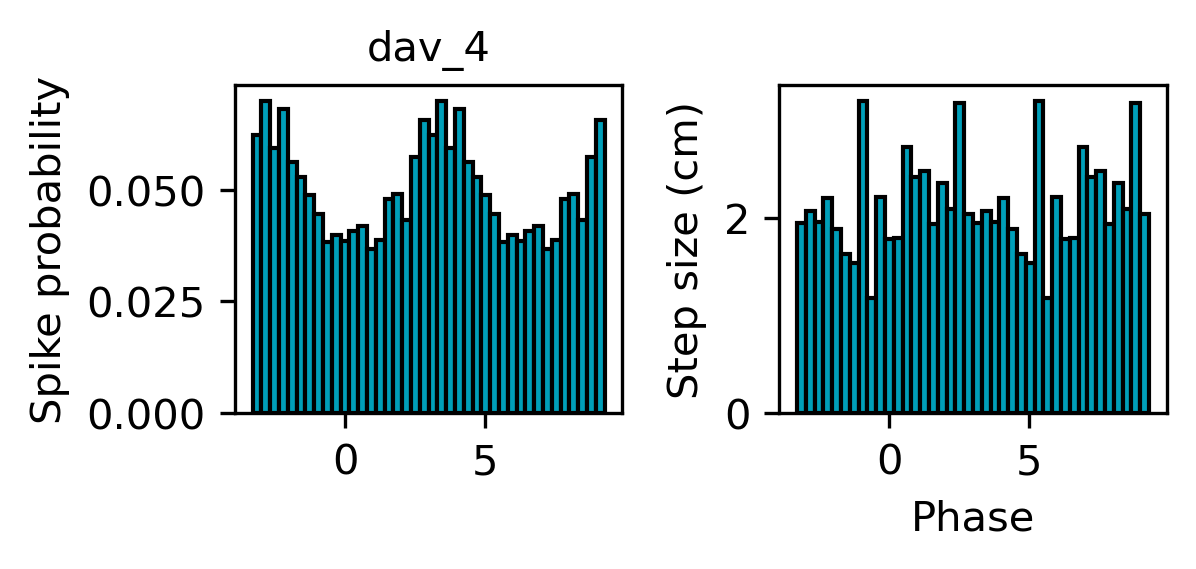

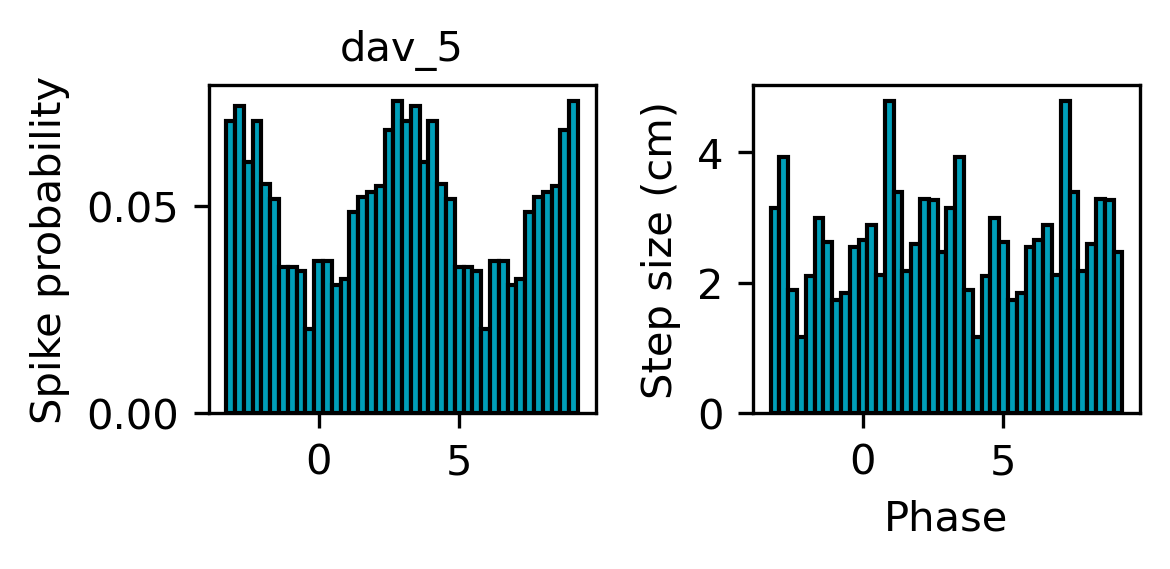

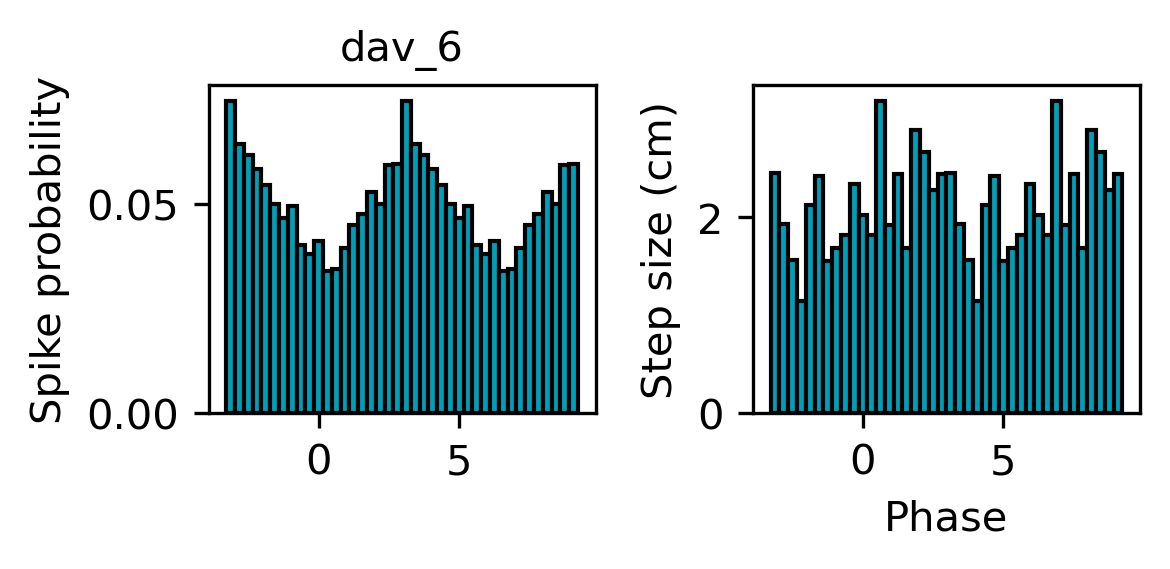

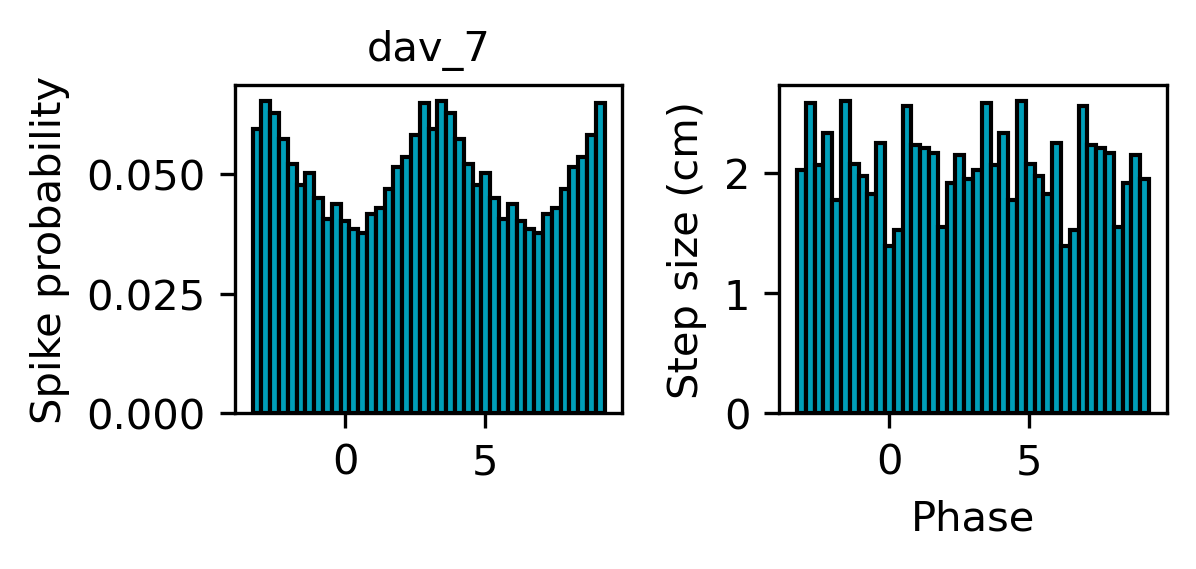

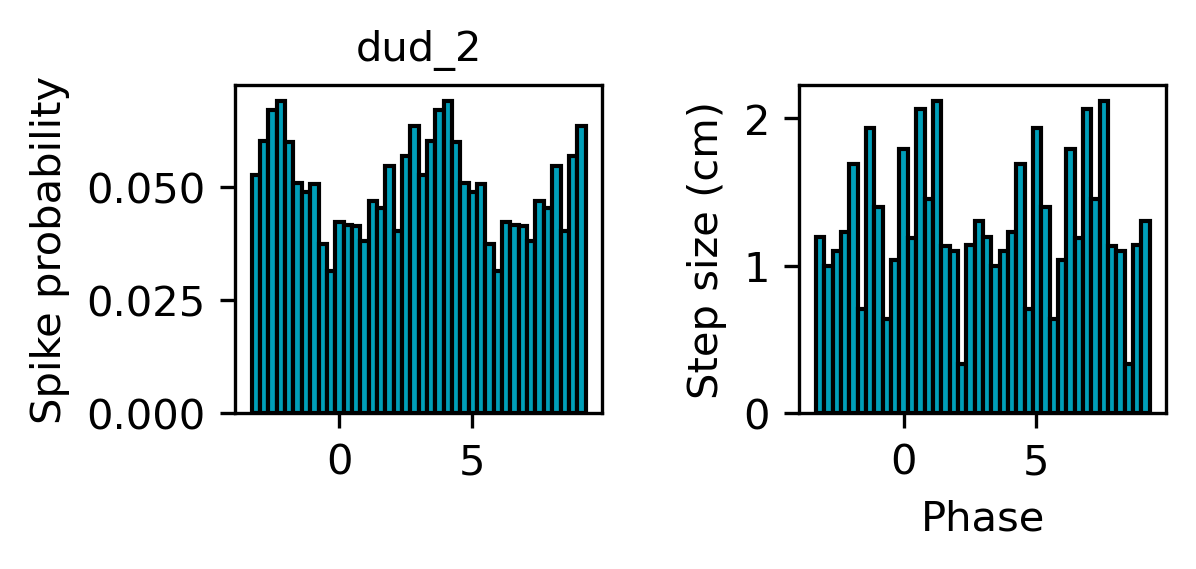

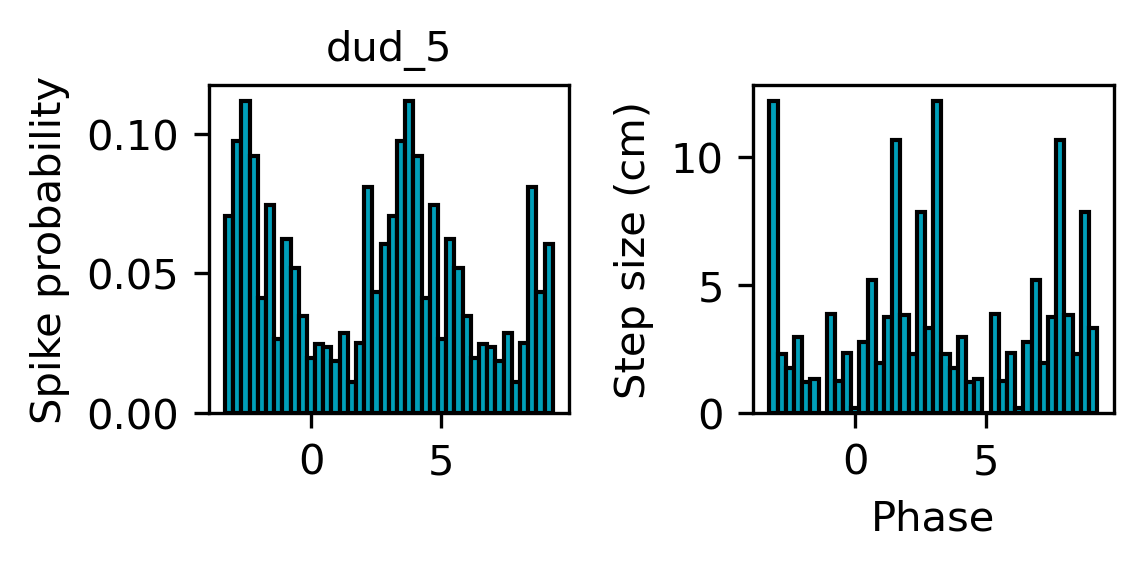

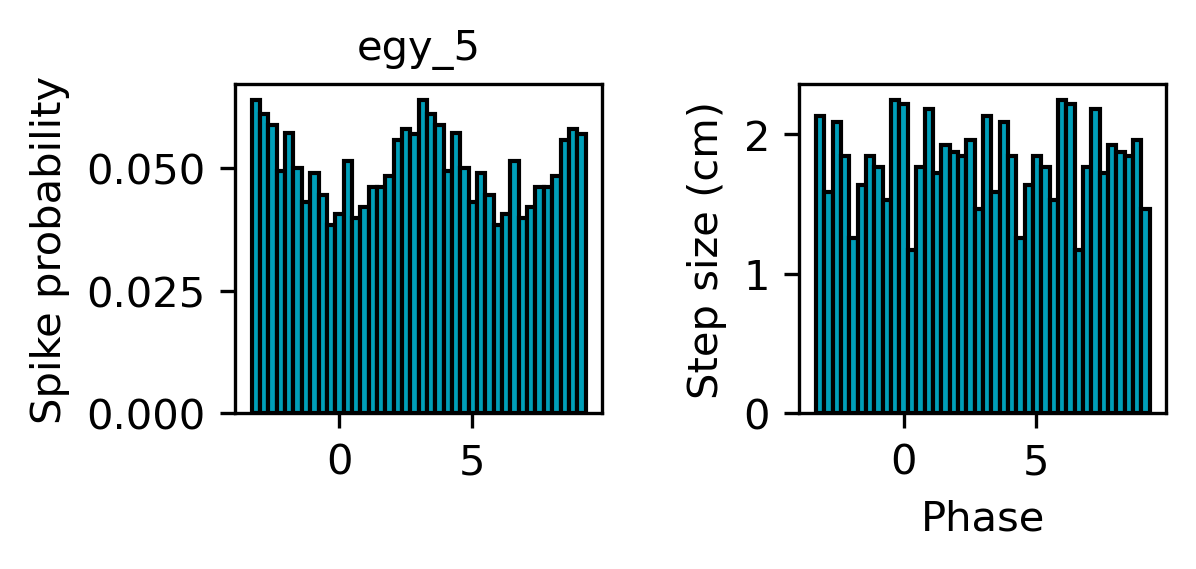

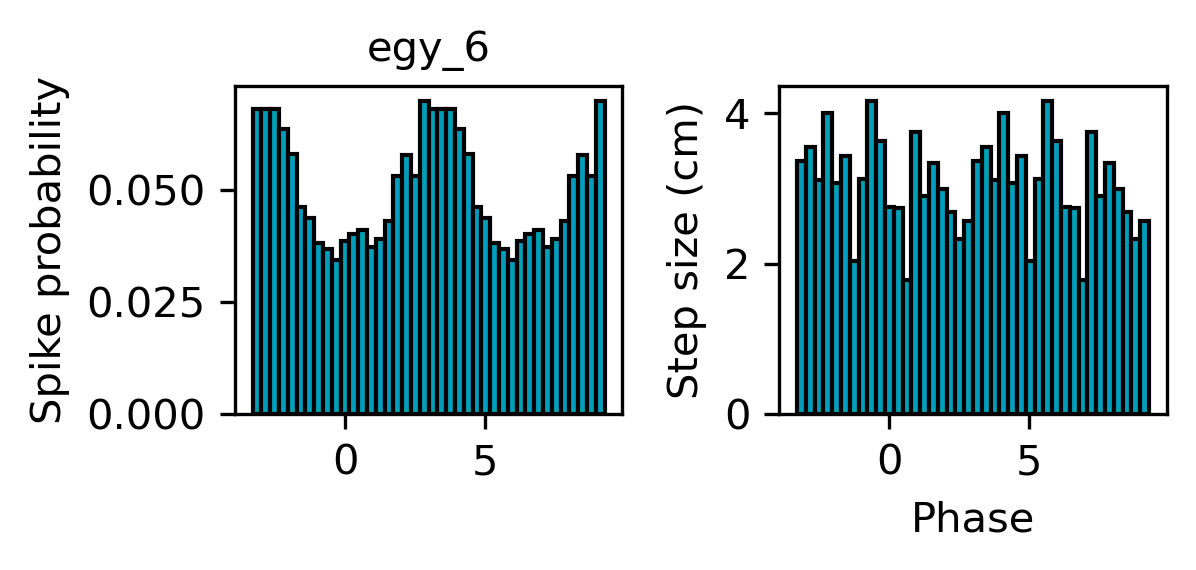

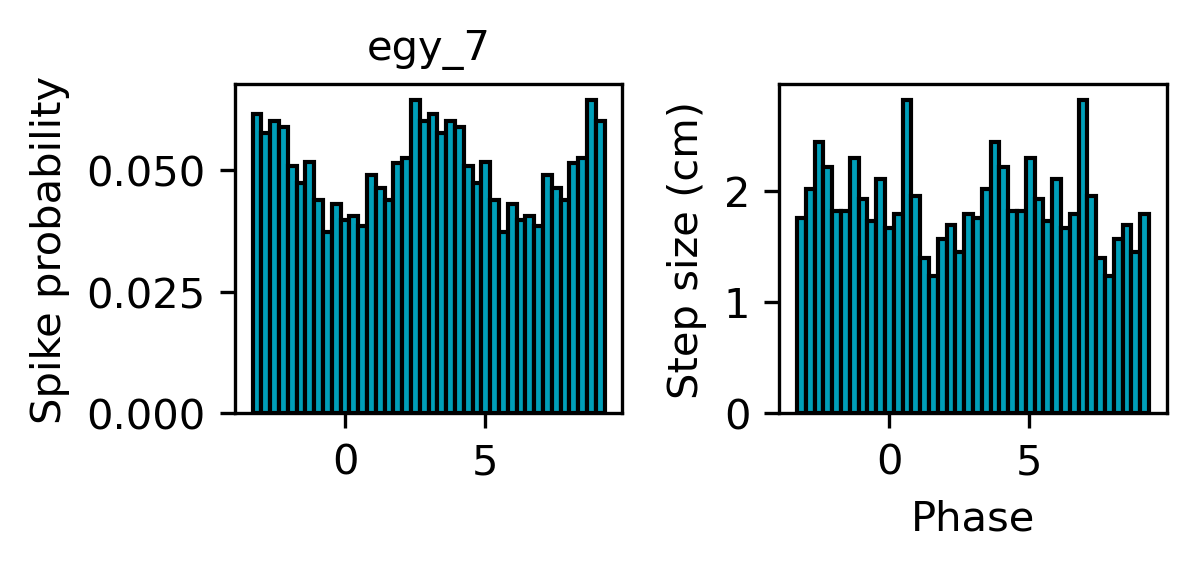

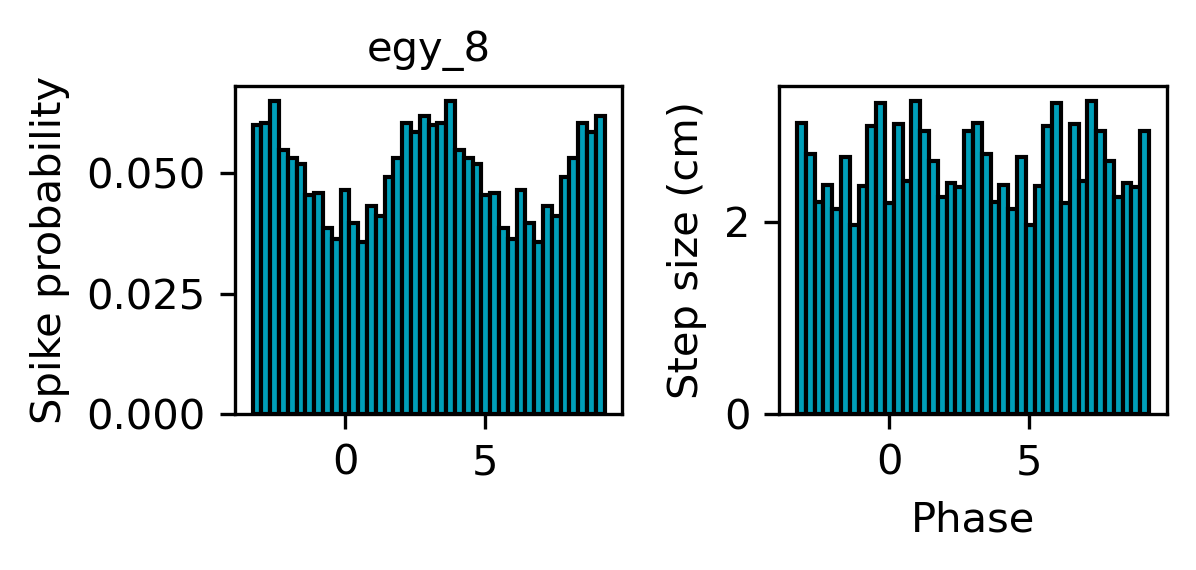

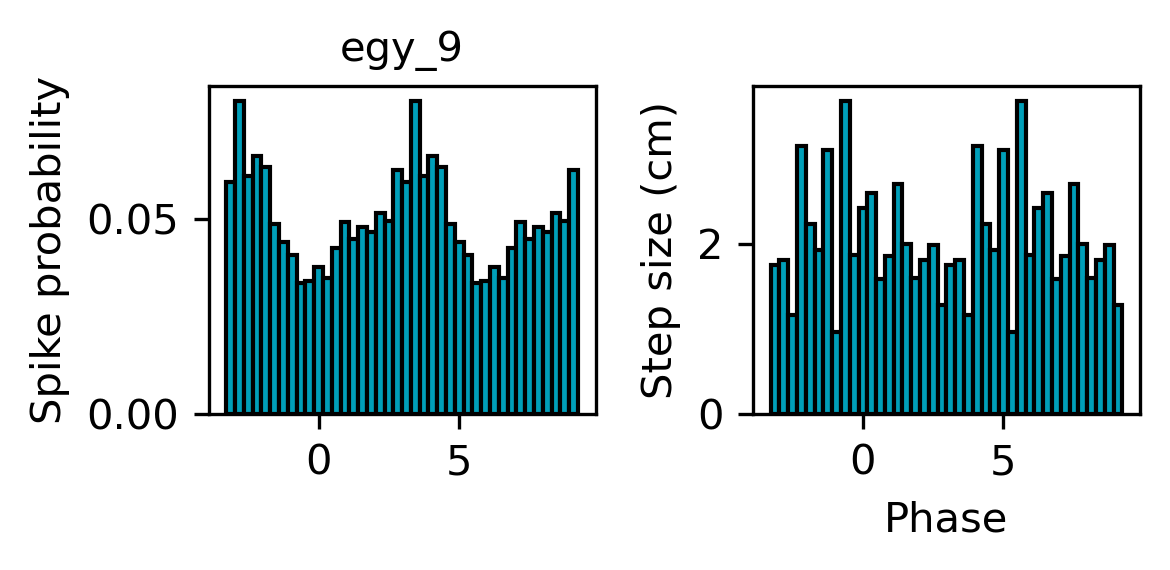

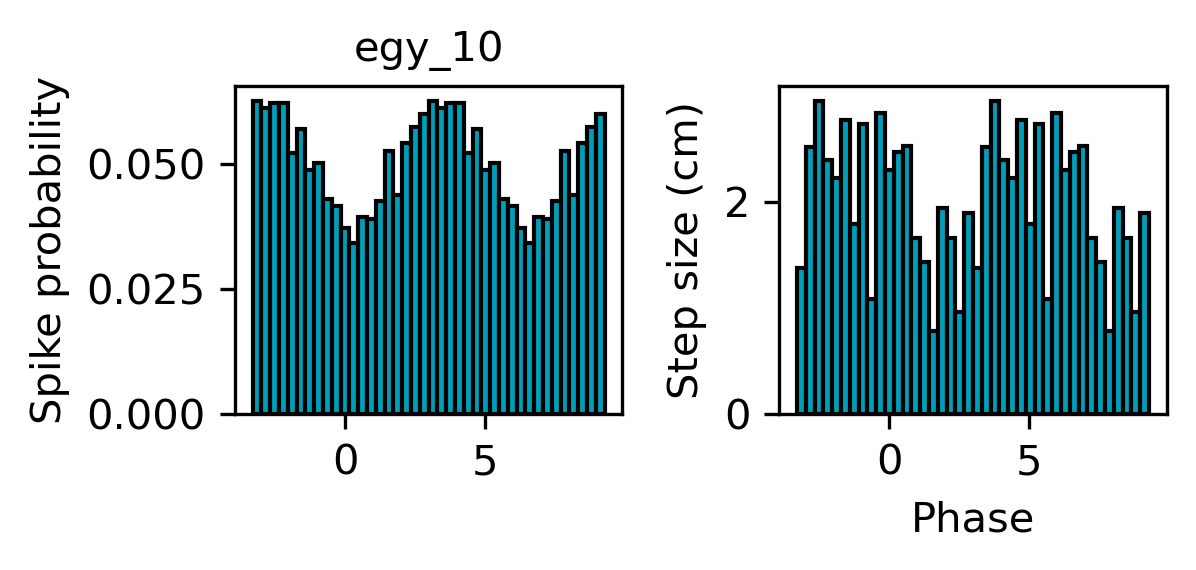

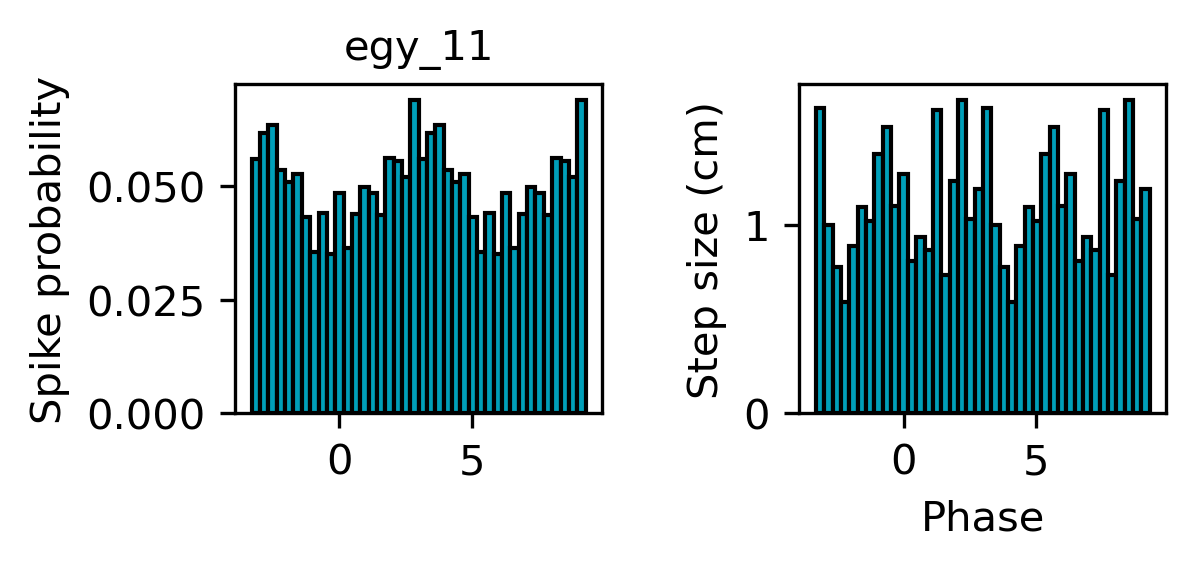

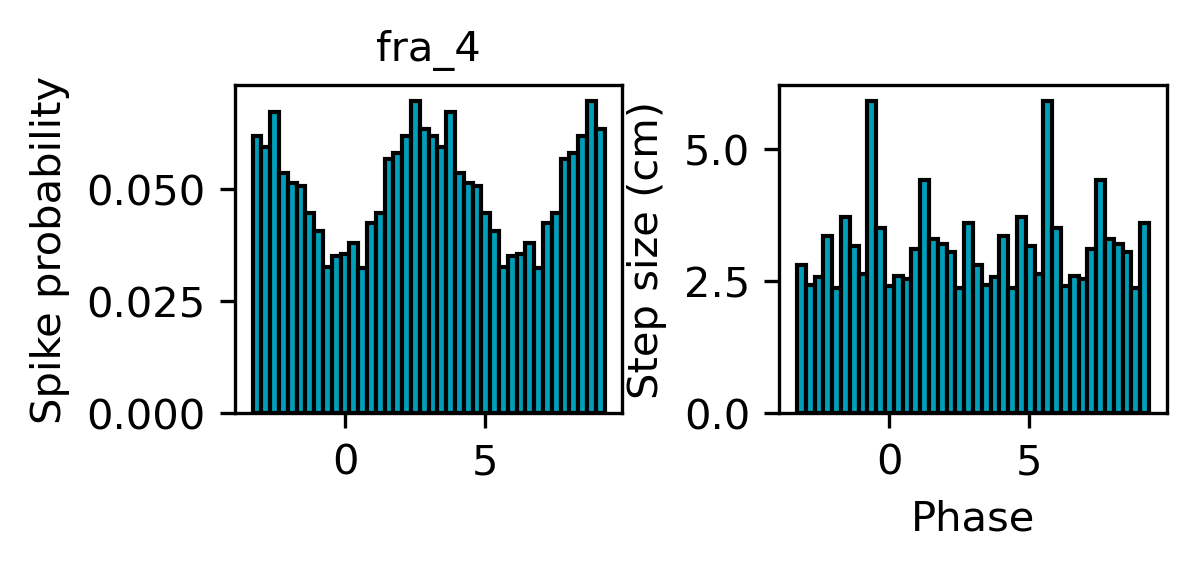

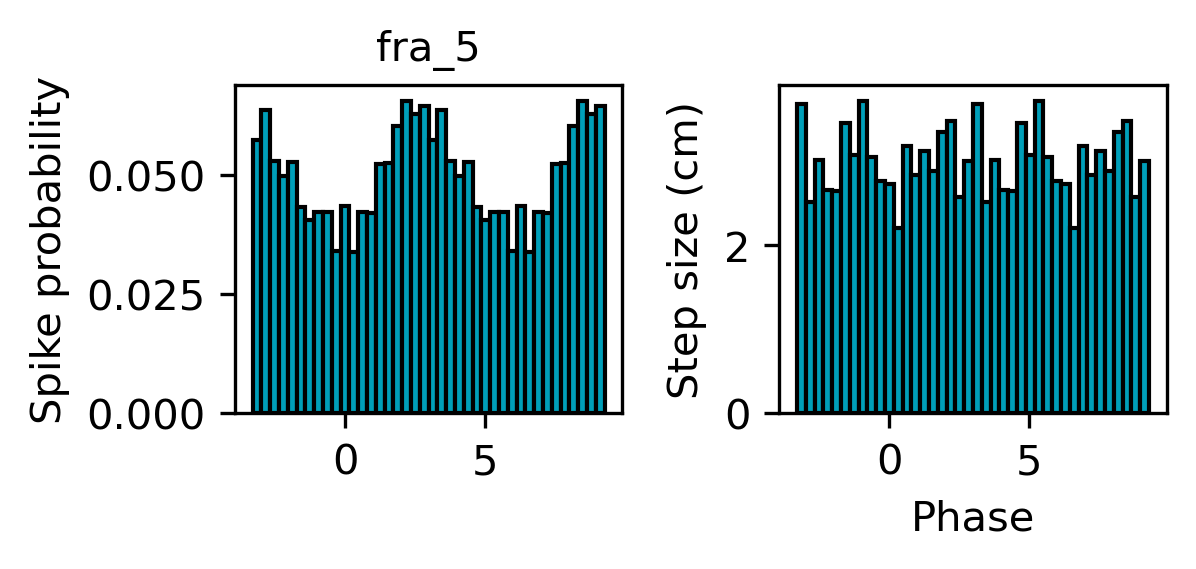

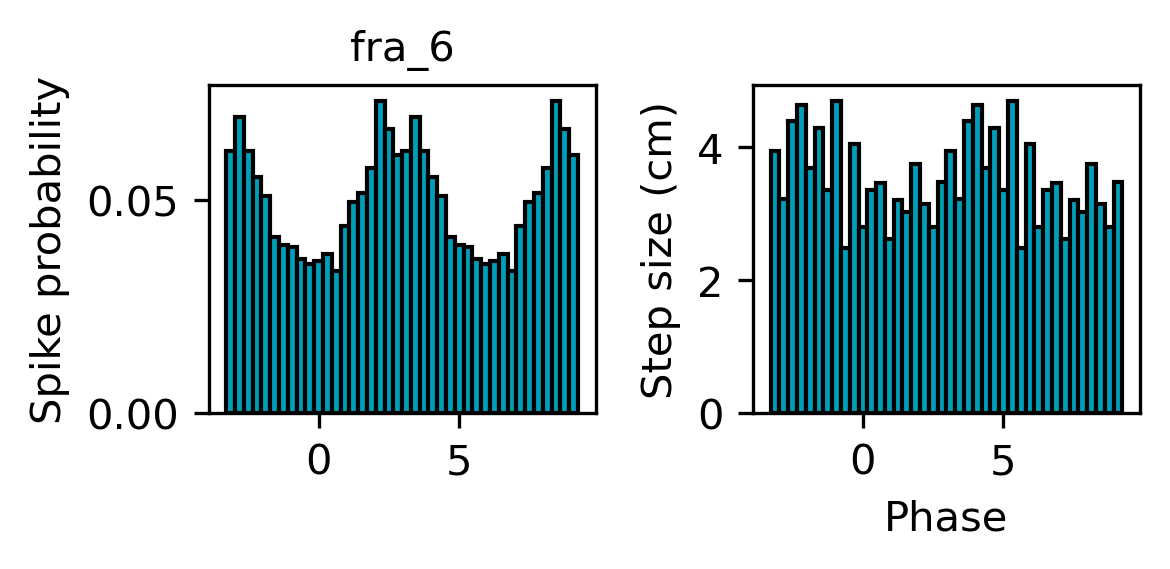

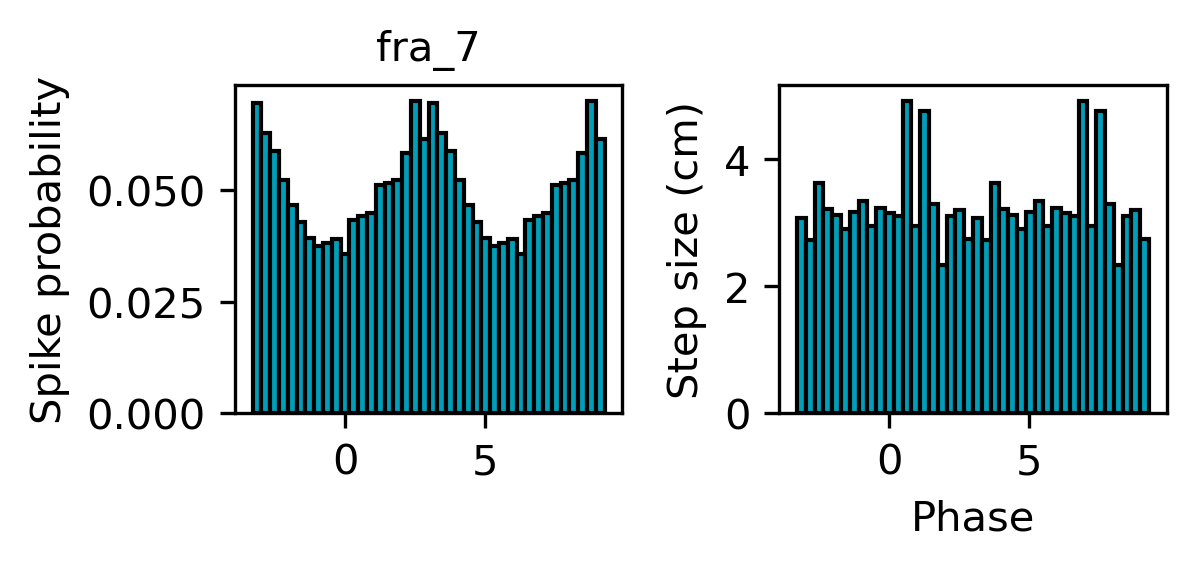

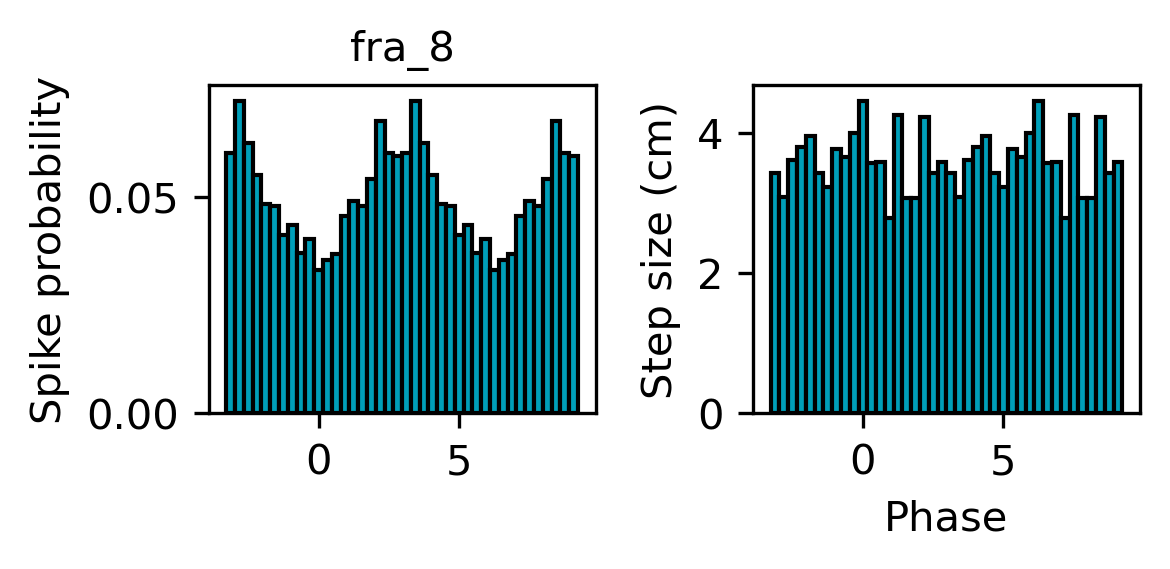

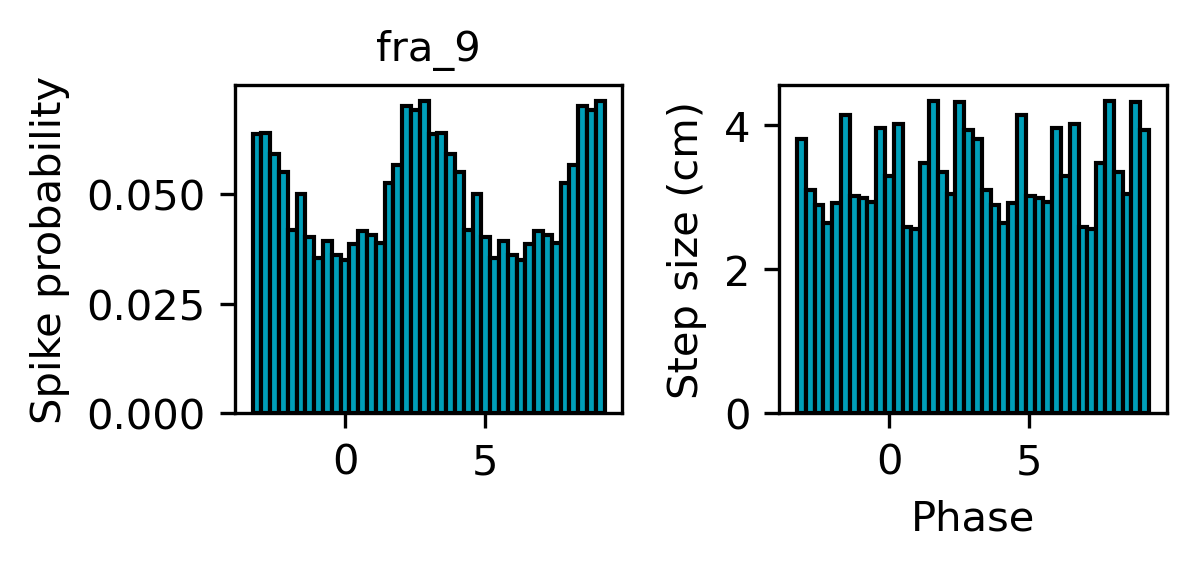

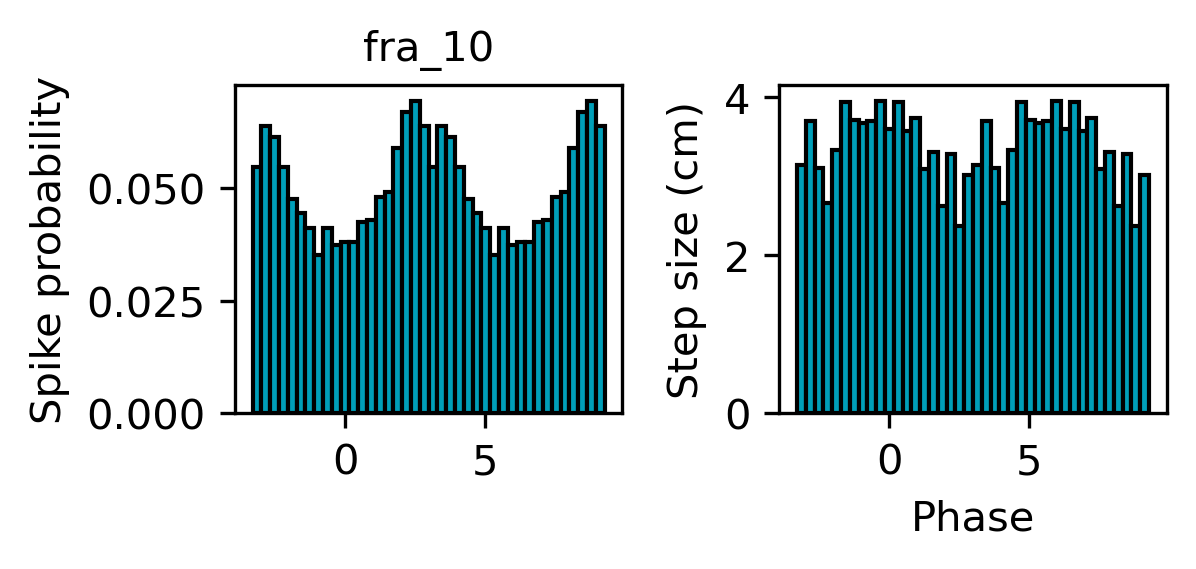

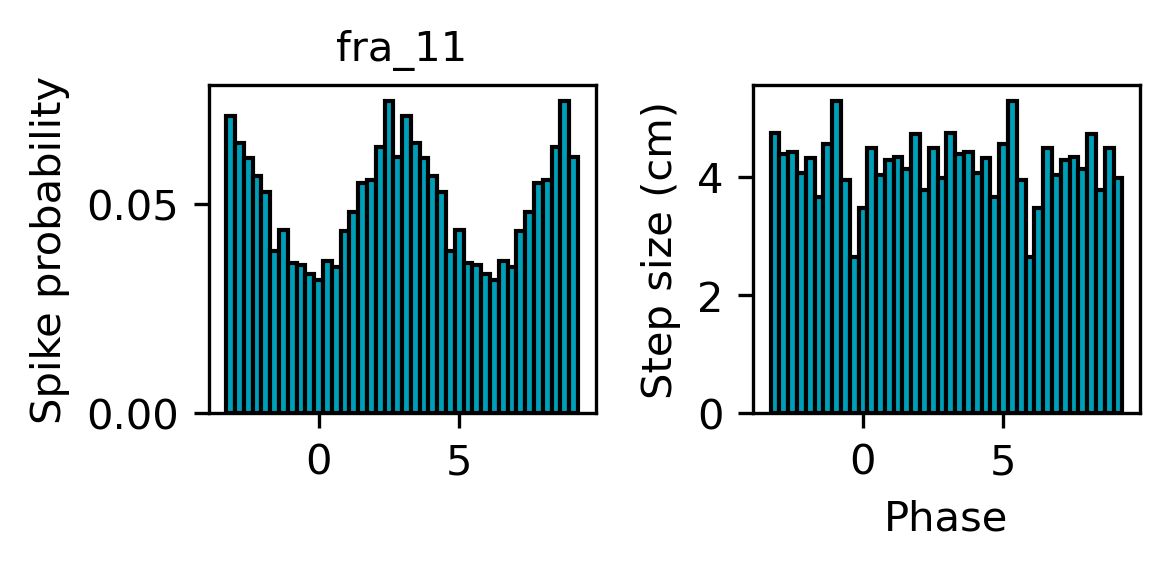

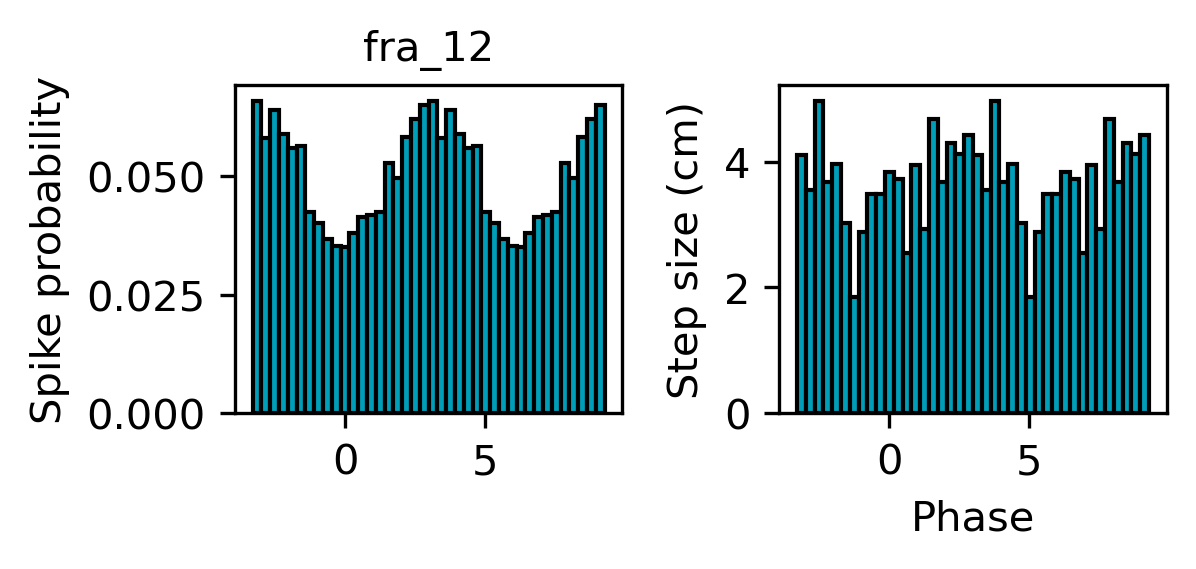

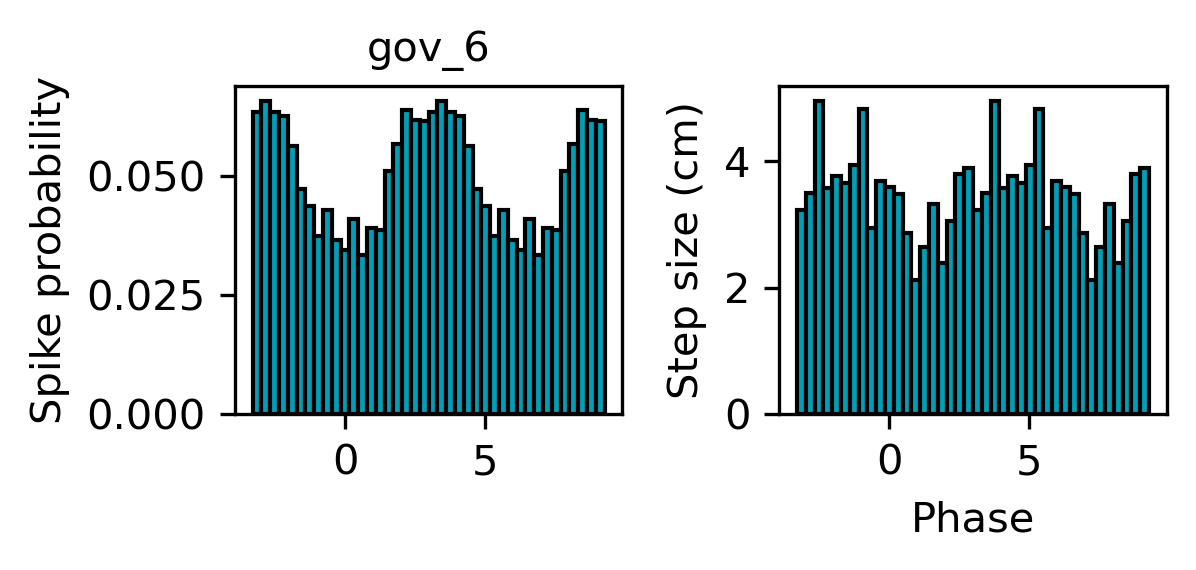

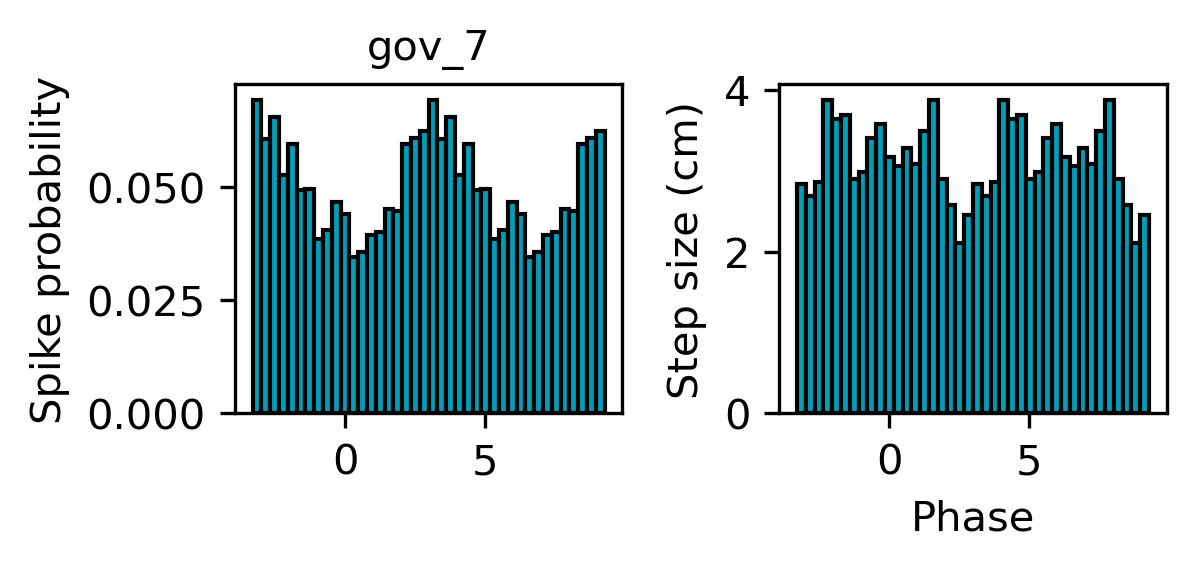

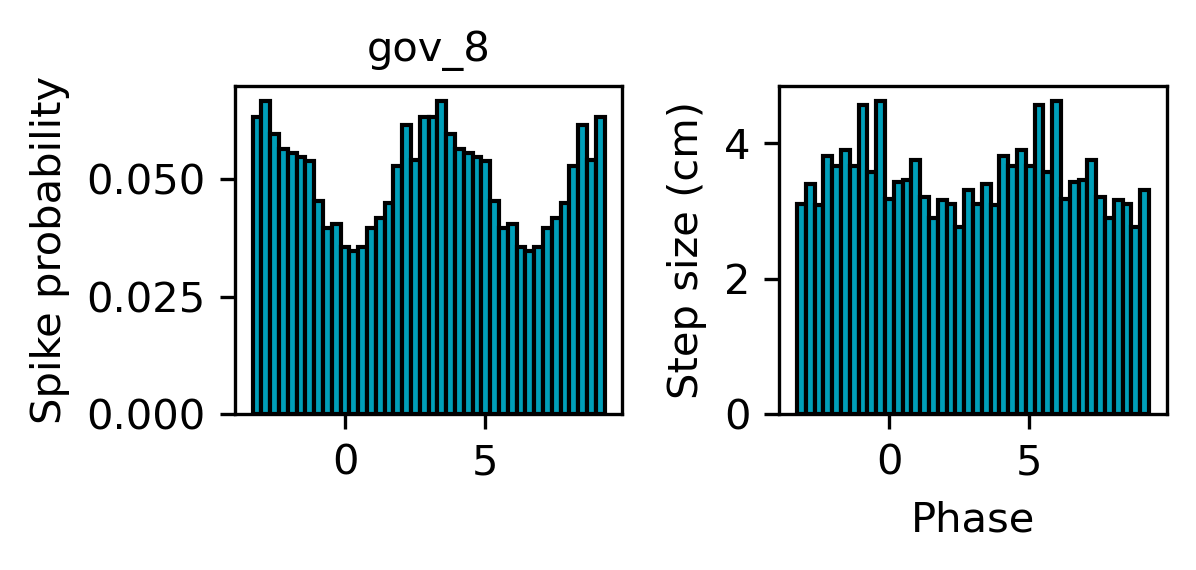

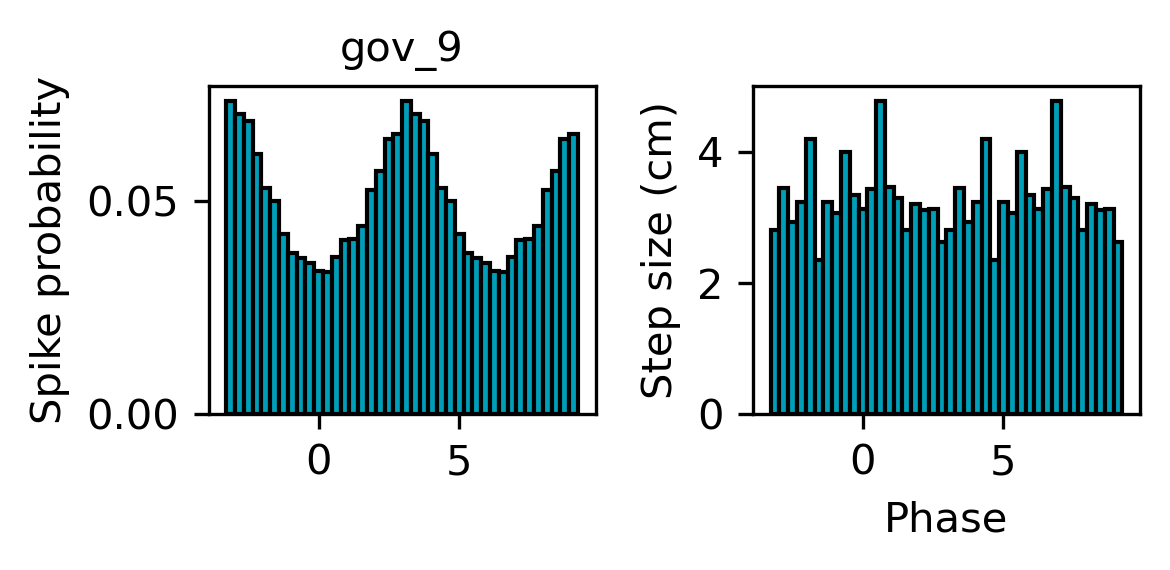

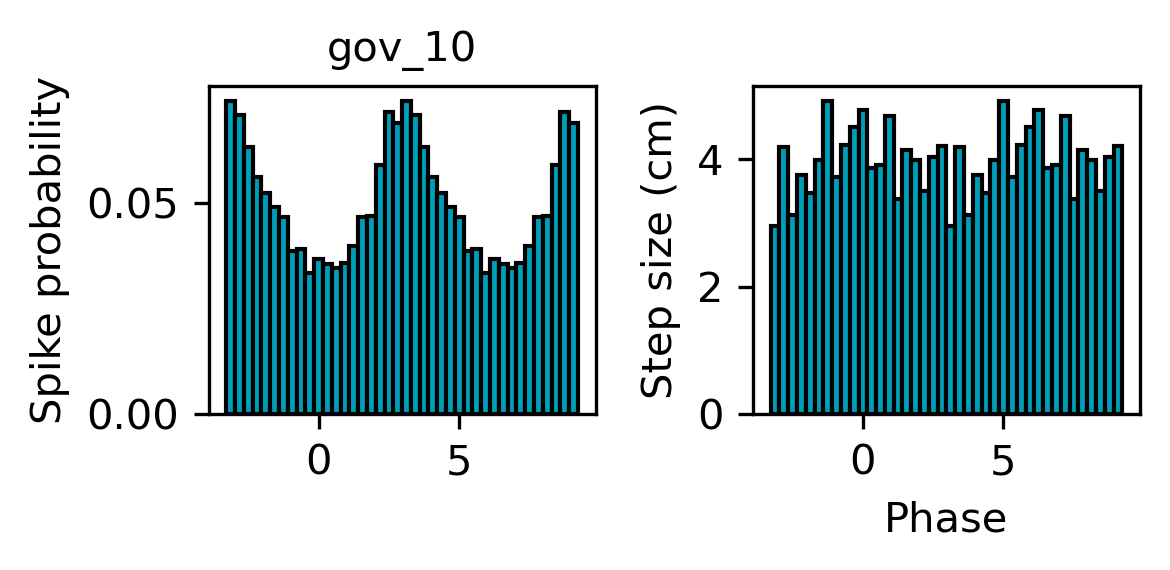

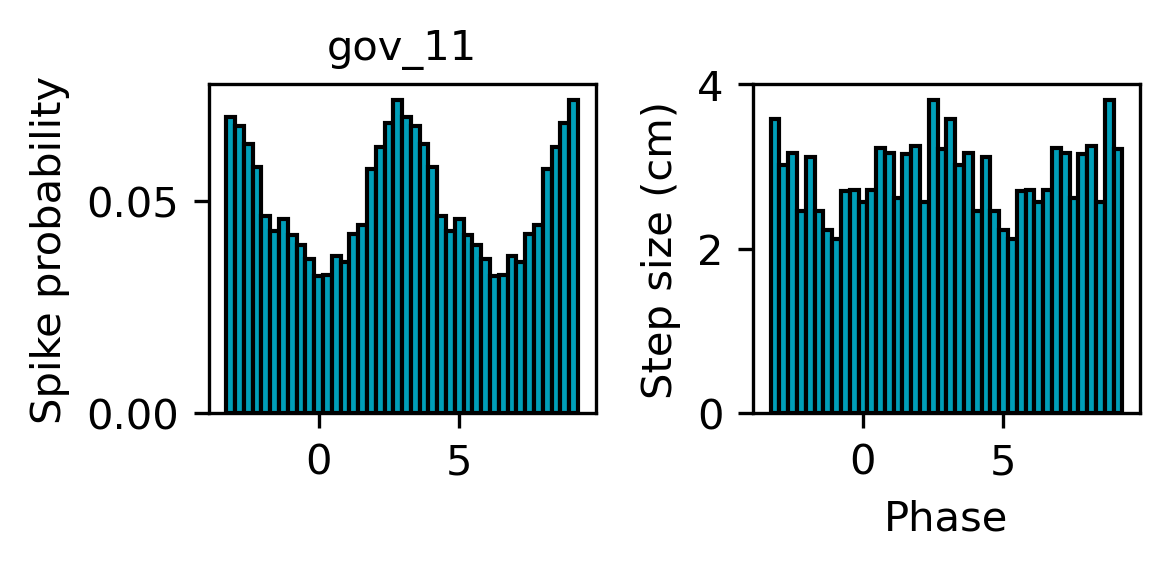

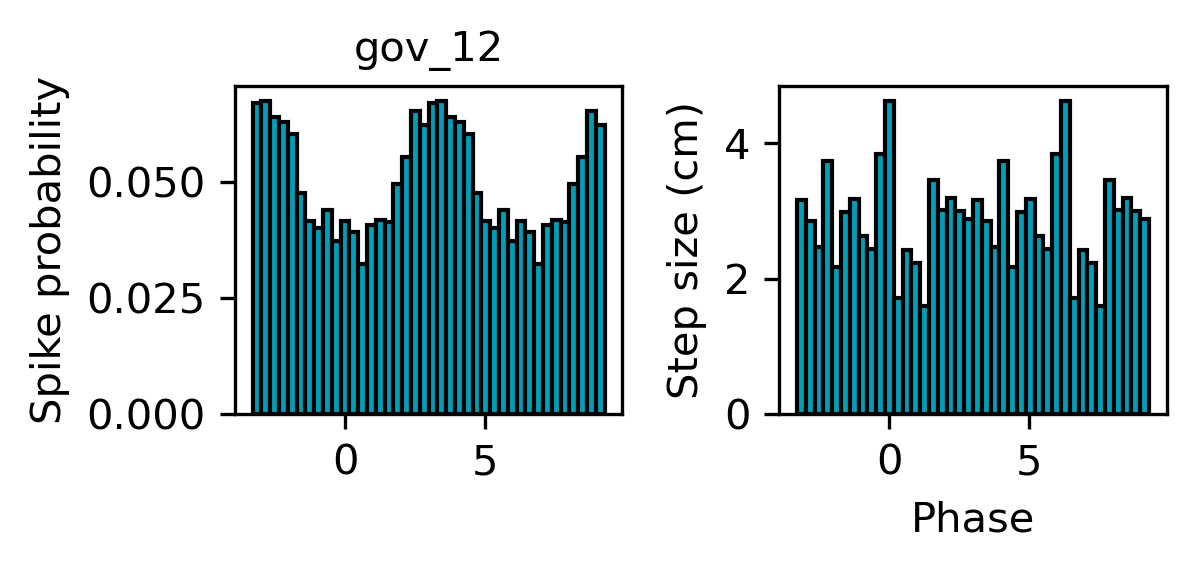

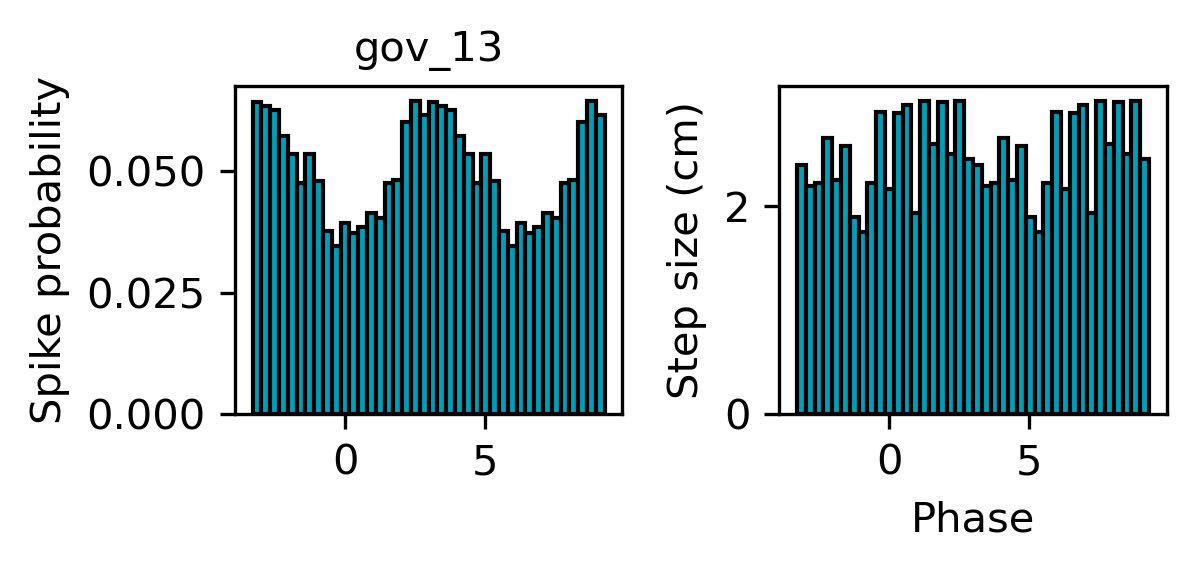

In [196]:
##merge the step size, multiunit spikes and multiunit firing rate from epochs under each animal each day into a list
all_step_size_perday= {}
all_multiunit_spikes_at_step_size_perday = {}
all_multiunit_fr_at_step_size_perday = {}
all_phase_at_step_size_perday = {}

for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    all_step_size_perday.setdefault((animal, day), []).extend(all_step_size[epoch_key])
    all_multiunit_spikes_at_step_size_perday.setdefault((animal, day), []).extend(all_multiunit_spikes_at_step_size[epoch_key])
    all_multiunit_fr_at_step_size_perday.setdefault((animal, day), []).extend(all_multiunit_fr_at_step_size[epoch_key])
    all_phase_at_step_size_perday.setdefault((animal, day), []).extend(all_phase_at_step_size[epoch_key])
    
#do the phase plot as above  for each animal
#all_multiunit_spikes_at_step_size_perday
for key in all_multiunit_spikes_at_step_size_perday.keys():
    step_size_array = np.array(all_step_size_perday[key])
    multiunit_spikes_at_step_size_array = np.array(all_multiunit_spikes_at_step_size_perday[key])
    phase_at_step_size_array = np.array(all_phase_at_step_size_perday[key])
    
    #filter out step_size_array<lthres and step_size_array>hthres for better visualization
    lthres =-1
    hthres = 200
    index = (step_size_array>lthres) & (step_size_array<hthres)
    step_size_array= step_size_array[index]
    multiunit_spikes_at_step_size_array = multiunit_spikes_at_step_size_array[index]
    phase_at_step_size_array = phase_at_step_size_array[index]
    
    fig = plt.figure(figsize=(4, 2), dpi=300)
    gs = gridspec.GridSpec(1, 2)
    
    #plot all_multiunit_spikes_at_step_size_array at each phase bin
    phase_bins = np.linspace(-np.pi, np.pi, 21)
    spike_phase = np.zeros(len(phase_bins)-1)
    step_phase = np.zeros(len(phase_bins)-1)
    for i in range(len(phase_bins)-1):
        summed_spike_i = np.sum(multiunit_spikes_at_step_size_array[(phase_at_step_size_array>=phase_bins[i]) & (phase_at_step_size_array<phase_bins[i+1])])
        spike_phase[i] = summed_spike_i/np.sum(multiunit_spikes_at_step_size_array)
        
        mean_step_i = np.mean(step_size_array[(phase_at_step_size_array>=phase_bins[i]) & (phase_at_step_size_array<phase_bins[i+1])])
        step_phase[i] = mean_step_i
        
    #scatter plot
    ax1 = plt.subplot(gs[0])
    #do bar plot with facecolor #009FB9, edge color black
    ax1.bar(phase_bins[:-1], spike_phase, width=phase_bins[1]-phase_bins[0], facecolor='#009FB9', edgecolor='black')
    #repeat another cycle of phase_bins to make the plot continuous
    ax1.bar(phase_bins[:-1]+2*np.pi, spike_phase, width=phase_bins[1]-phase_bins[0], facecolor='#009FB9', edgecolor='black')
    
    ax1.set_ylabel('Spike probability', fontsize=labelsize)


    ax2 = plt.subplot(gs[1])
    #plot all_step_size_array at each phase bin
    #do bar plot with facecolor #009FB9, edge color black
    ax2.bar(phase_bins[:-1], step_phase, width=phase_bins[1]-phase_bins[0], facecolor='#009FB9', edgecolor='black')
    #repeat another cycle of phase_bins to make the plot continuous
    ax2.bar(phase_bins[:-1]+2*np.pi, step_phase, width=phase_bins[1]-phase_bins[0], facecolor='#009FB9', edgecolor='black')

    ax2.set_xlabel('Phase', fontsize=labelsize)
    ax2.set_ylabel('Step size (cm)', fontsize=labelsize)
    
    #add animal and day to the title
    ax1.set_title(f'{key[0]}_{key[1]}', fontsize=labelsize)
    
    plt.tight_layout()
        


### check the correlation between step size and multiunit firing rate

epochs: 100%|██████████| 140/140 [00:00<00:00, 113491.02it/s]


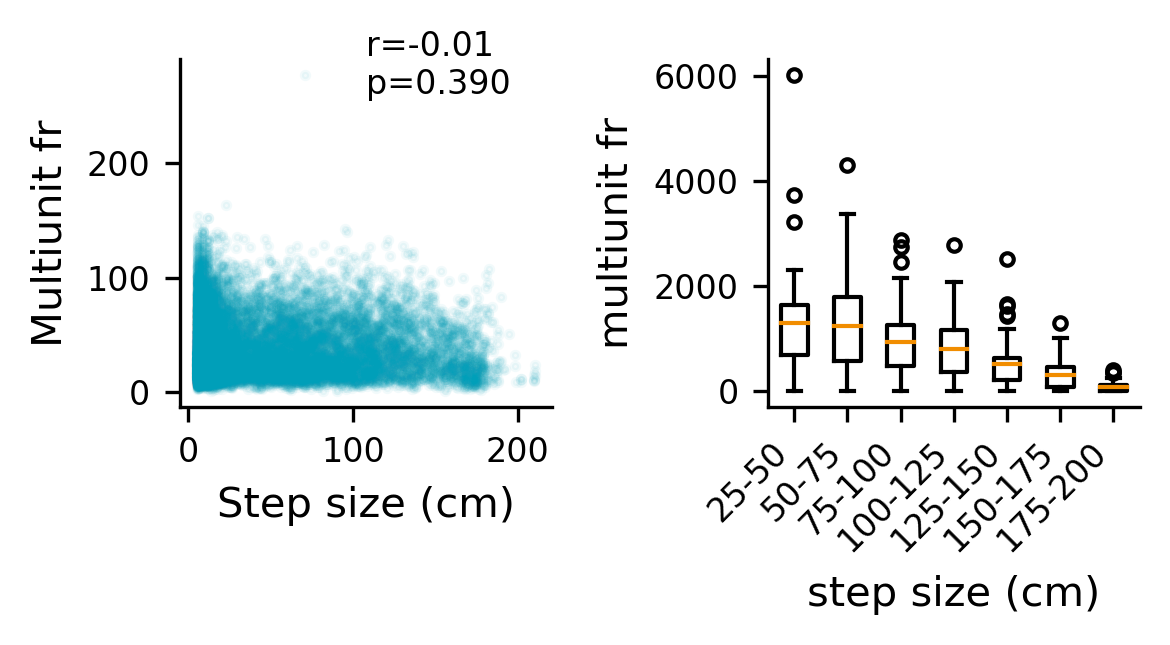

In [190]:
labelsize=10
ticksize=8

fig = plt.figure(figsize=(4, 2.2), dpi=300)

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

#scatter plot
ax1 = plt.subplot(gs[0])

#merge values in all_step_size and all_multiunit_spikes_at_step_size into a list and plot step_size vs multiunit_spikes_at_step_size as scatter plot
all_step_size_list = []
all_multiunit_fr_at_step_size_list = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    all_step_size_list.extend(all_step_size[epoch_key])
    all_multiunit_fr_at_step_size_list.extend(all_multiunit_fr_at_step_size[epoch_key])

#remove points with all_step_size_list<1 for better visualization
all_step_size_list = np.array(all_step_size_list)
all_multiunit_fr_at_step_size_list = np.array(all_multiunit_fr_at_step_size_list)
all_step_size_array= all_step_size_list[all_step_size_list>5]
all_multiunit_fr_at_step_size_array = all_multiunit_fr_at_step_size_list[all_step_size_list>5]

ax1.scatter(all_step_size_array, all_multiunit_fr_at_step_size_array,
            s=3, c='#009FB9', alpha=0.05)

#check the person correlation between step size and multiunit spikes and add p abd r values to the plot, with p values as scientific notation
from scipy.stats import pearsonr
r, p = pearsonr(all_step_size_array, all_multiunit_fr_at_step_size_array)
if p<0.001:
    ax1.text(0.5, 0.9, f'r={r:.2f}\np<0.001', transform=plt.gca().transAxes, fontsize=ticksize)
else:
    ax1.text(0.5, 0.9, f'r={r:.2f}\np={p:.3f}', transform=plt.gca().transAxes, fontsize=ticksize)

ax1.set_xlabel('Step size (cm)', fontsize=labelsize)
ax1.set_ylabel('Multiunit fr', fontsize=labelsize)

#scatter plot
ax2 = plt.subplot(gs[1])

all_bined_multiunitFR = {}
for animal_day in all_step_size_perday.keys():
    stepsizeS = np.array(all_step_size_perday[animal_day])
    multiunitFR = np.array(all_multiunit_fr_at_step_size_perday[animal_day])
    #split stepsizeS into 10 bins, in each bin, count the number of multiunit spikes
    
    bins = np.linspace(0, 200, 9)
    #get the index of the bin that each stepsizeS belongs to
    inds = np.digitize(stepsizeS, bins)
    #get the number of multiunit spikes in each bin
    multiunitFR_binned = [np.sum(multiunitFR[inds==i]) for i in range(1, len(bins))]
    
    all_bined_multiunitFR[animal_day] = multiunitFR_binned[1:]

#convert the dictionary to numpy array
all_bined_multiunitFR_array = np.array(list(all_bined_multiunitFR.values()))
    
#plot box plot
ax2.boxplot(all_bined_multiunitFR_array, showmeans=True, meanline=True, showfliers=True, 
            flierprops=dict(markersize=3), 
            meanprops=dict(color='#F18D00', linestyle='-', linewidth=1), 
            medianprops=dict(color='#009FB9', alpha=0))

#set the xlabels for each bin using values in bins
ax2.set_xticklabels([f'{int(bins[i])}-{int(bins[i+1])}' for i in range(1, len(bins)-1)], rotation=45, ha='right')

ax2.set_xlabel('step size (cm)', fontsize=labelsize)
ax2.set_ylabel('multiunit fr', fontsize=labelsize)

#for all axes, set tick size as ticksize, set x and y tick label size as labelsize
#remove top and right spines
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=ticksize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.show()


### check the replay speed with multiunit spikes

epochs: 100%|██████████| 140/140 [00:00<00:00, 624.31it/s]


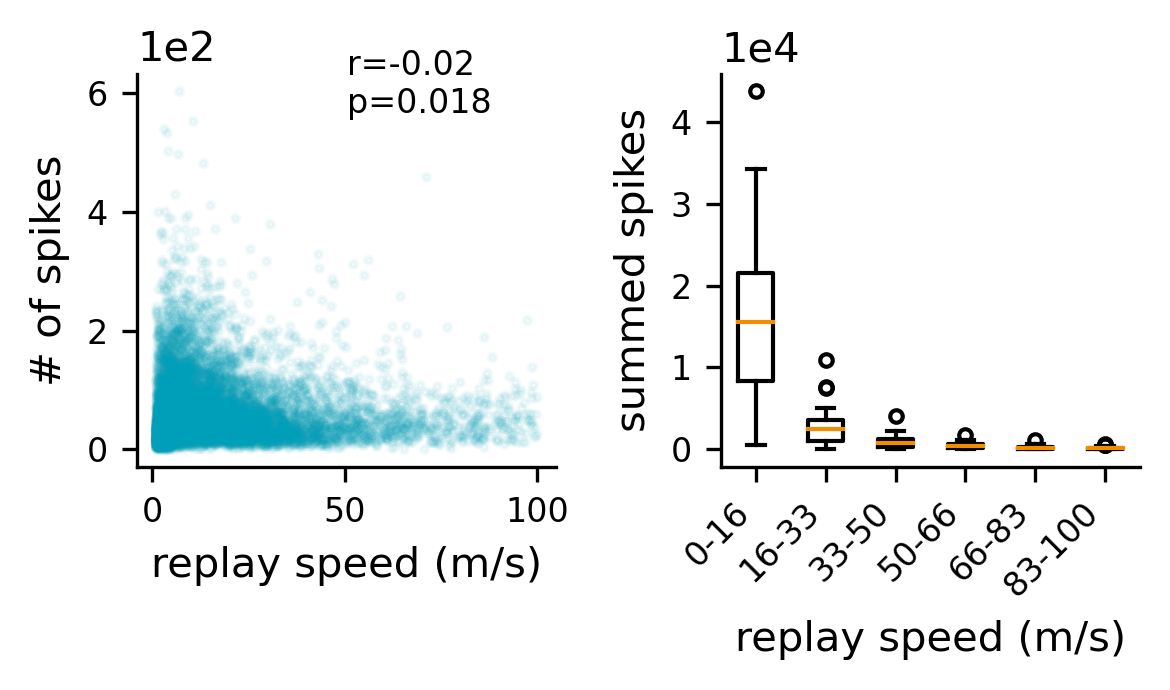

In [264]:
DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

all_spikes = {}
all_replay_speed = {}

all_spikes_perday = {}
all_replay_speed_perday = {}

for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    
    #get ripple time from csv file under folder: ReplayTrajectories
    replay_info_path = os.path.join(
        DATA_DIR,
        'ReplayTrajectories/'
        f"{animal}_{day:02d}_{epoch:02d}_clusterless_1D_no_interneuron_replay_info_80.csv",
    )
    
    #extract the column with column name 'n_total_spikes' and 'replay_speed'
    replay_info = pd.read_csv(replay_info_path, usecols=[0,6,17]) 
    
    all_spikes_perday.setdefault((animal, day), []).extend(replay_info['n_total_spikes'].values)
    all_replay_speed_perday.setdefault((animal, day), []).extend(replay_info['replay_speed'].values)
    
#generate a long list to merge all the values in all_spikes_perday and all_replay_speed_perday
all_spikes_list = []
all_replay_speed_list = []
for animal_day in all_spikes_perday.keys():
    all_spikes_list.extend(all_spikes_perday[animal_day])
    all_replay_speed_list.extend(all_replay_speed_perday[animal_day])

#remove replay speed under 500 and over 20000 for better visualization 
all_spikes_list = np.array(all_spikes_list)
all_replay_speed_list = np.array(all_replay_speed_list)
all_spikes_array= all_spikes_list[(all_replay_speed_list>100) & (all_replay_speed_list<10000)]
all_replay_speed_array = all_replay_speed_list[(all_replay_speed_list>100) & (all_replay_speed_list<10000)]


labelsize=10
ticksize=8

fig = plt.figure(figsize=(4, 2.4), dpi=300)

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

#scatter plot
ax1 = plt.subplot(gs[0])

#plot spikes vs replay speed as scatter plot
ax1.scatter(all_replay_speed_array, all_spikes_array, s=3, c='#009FB9', alpha=0.05)

from scipy.stats import pearsonr
r, p = pearsonr(all_replay_speed_array, all_spikes_array)
if p<0.001:
    ax1.text(0.5, 0.9, f'r={r:.2f}\np<0.001', transform=plt.gca().transAxes, fontsize=ticksize)
else:
    ax1.text(0.5, 0.9, f'r={r:.2f}\np={p:.3f}', transform=plt.gca().transAxes, fontsize=ticksize)

#remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

#set x ticks from cm to m
ax1.set_xticks([0, 5000, 10000])
ax1.set_xticklabels([0, 50, 100])
ax1.tick_params(axis='both', which='major', labelsize=ticksize)

ax1.set_xlabel('replay speed (m/s)', fontsize=labelsize)
ax1.set_ylabel('# of spikes', fontsize=labelsize)
#set y tick to scientific notation
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax2 = plt.subplot(gs[1])
all_bined_spikes = {}
for animal_day in all_replay_speed_perday.keys():
    replay_speedS = np.array(all_replay_speed_perday[animal_day])
    spikes = np.array(all_spikes_perday[animal_day])
    #split replay_speedS into 10 bins, in each bin, count the number of spikes
    
    bins = np.linspace(0, 10000, 7)
    #get the index of the bin that each replay_speedS belongs to
    inds = np.digitize(replay_speedS, bins)
    #get the number of spikes in each bin
    spikes_binned = [np.sum(spikes[inds==i]) for i in range(1, len(bins))]
    
    all_bined_spikes[animal_day] = spikes_binned[0:]

#convert the dictionary to numpy array
all_bined_spikes_array = np.array(list(all_bined_spikes.values()))

#plot box plot
ax2.boxplot(all_bined_spikes_array, showmeans=True, meanline=True, showfliers=True,
            flierprops=dict(markersize=3),
            meanprops=dict(color='#F18D00', linestyle='-', linewidth=1),
            medianprops=dict(color='#009FB9', alpha=0))

#remove top and right spines
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#set tickszie to ticksize
ax2.tick_params(axis='both', which='major', labelsize=ticksize)

#set the xlabels in scientific notation
ax2.set_xticklabels([f'{int(bins[i]/100)}-{int(bins[i+1]/100)}' for i in range(0, len(bins)-1)], rotation=45, ha='right')
#set y tick to scientific notation
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax2.set_xlabel('replay speed (m/s)', fontsize=labelsize)
ax2.set_ylabel('summed spikes', fontsize=labelsize)

savedir = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"
savename = "Fig6_anti_correlation_between_replayspeed_and_spikes.pdf"
plt.savefig(savedir+savename, dpi=300, bbox_inches='tight')

plt.tight_layout()